# Libraries, classes and auxiliary functions

## Libraries

In [1]:
!pip install pandas scipy pygsheets matplotlib joblib imageio

import os
import pygsheets
import matplotlib.pyplot as plt
from scipy.stats import norm
import csv
import pandas as pd
import numpy as np
import json
import math
import random

from datetime import datetime, timedelta

import imageio.v2 as iio #as imageio
# import imageio as iio



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


## Classes

### StgyApp

The main class for initializing everything and running simulations through reading prices in the dataset, updating all the parameters involved and executing the needed actions.

In [2]:
class StgyApp(object):

    def __init__(self, config):

        self.stk = config["stk"]
        self.total_costs_from_aave_n_dydx = 0
        self.total_non_controlled_costs = 0
        self.total_controlled_costs = 0
        self.total_pnl = 0
        self.gas_fees = 0

        # prices and intervals
        self.trigger_prices = {}
        self.intervals = {}

        # We create attributes to fill later
        self.aave = None
        self.aave_features = None
        self.aave_rates = None

        self.dydx = None
        self.dydx_features = None

        # self.volatility_calculator = None

        self.parameter_manager = ParameterManager()

        self.data_dumper = DataDamper()

    def launch(self, config):
        # self.call_binance_data_loader()
        self.initialize_aave(config['initial_parameters']['aave'])
        self.initialize_dydx(config['initial_parameters']['dydx'])


    # initialize classes
    def initialize_aave(self, config):
        # We initialize aave and dydx classes instances
        self.aave = Aave(config)
        # We load methods and attributes for aave and dydx to use later
        self.aave_features = {"methods": [func for func in dir(self.aave)
                                          if (callable(getattr(self.aave, func))) & (not func.startswith('__'))],
                              "attributes": {"values": list(self.aave.__dict__.values()),
                                             "keys": list(self.aave.__dict__.keys())}}

    def initialize_dydx(self, config):
        self.dydx = Dydx(config)
        self.dydx_features = {"methods": [func for func in dir(self.dydx)
                                          if (callable(getattr(self.dydx, func))) & (not func.startswith('__'))],
                              "attributes": {"values": list(self.dydx.__dict__.values()),
                                             "keys": list(self.dydx.__dict__.keys())}}

### Aave and DyDx modules

Modules with parameters for the protocols involved in the strategy (Aave and DyDx), methods for updating all the parameters given a new price read by the bot and methods for executing the actions needed.

#### Aave

In [3]:
class Aave(object):

    def __init__(self, config):
        self.market_price = config['market_price']

        self.entry_price = config['entry_price']

        self.collateral_eth_initial = config['collateral_eth']
        self.collateral_eth = config['collateral_eth']
        self.collateral_usdc = config['collateral_usdc']

        # self.reserve_margin_eth = 0
        # self.reserve_margin_usdc = 0

        self.borrowed_percentage = config['borrowed_pcg']
        self.usdc_status = config['usdc_status']

        self.debt = config['debt']
        self.debt_initial = config['debt']

        self.ltv = config['ltv']
        self.price_to_ltv_limit = config['price_to_ltv_limit']

        self.lending_rate = 0
        self.lending_rate_hourly = 0
        self.interest_on_lending_eth = 0  # aggregated fees
        self.interest_on_lending_usd = 0
        self.lending_fees_eth = 0 # fees between last 2 prices
        self.lending_fees_usd = 0

        self.borrowing_rate = 0
        self.borrowing_rate_hourly = 0
        self.interest_on_borrowing = 0 # aggregated fees
        self.borrowing_fees = 0 # fees between last 2 prices

        self.lend_minus_borrow_interest = 0

        self.costs = 0
        
    def collateral_usd(self):
        return self.collateral_eth * self.market_price

    def update_debt(self):
        """
        it requires having called borrowing_fees_calc() in order to use updated values of last earned fees
        """
        self.debt = self.debt + self.borrowing_fees

    def update_collateral(self):
        """
        it requires having called lending_fees_calc() in order to use updated values of last earned fees
        """
        self.collateral_eth = self.collateral_eth + self.lending_fees_eth
        self.collateral_usdc = self.collateral_usd()

    def track_lend_borrow_interest(self):
        """
        it requires having called borrowing_fees_calc() and lending_fees_calc()
        in order to use updated values of last earned fees
        """
        self.lend_minus_borrow_interest = self.interest_on_lending_usd - self.interest_on_borrowing

    def lending_fees_calc(self, freq):
        self.simulate_lending_rate()
        self.lending_rate_freq = self.lending_rate / freq

        self.lending_fees_eth = self.collateral_eth * self.lending_rate_freq
        self.lending_fees_usd = self.lending_fees_eth * self.market_price
        self.interest_on_lending_eth = self.interest_on_lending_eth + self.lending_fees_eth
        self.interest_on_lending_usd = self.interest_on_lending_usd + self.lending_fees_usd

    def borrowing_fees_calc(self, freq):
        self.simulate_borrowing_rate()
        self.borrowing_rate_freq = self.borrowing_rate / freq

        self.borrowing_fees = self.debt * self.borrowing_rate_freq
        self.interest_on_borrowing = self.interest_on_borrowing + self.borrowing_fees

    def simulate_lending_rate(self):
        # self.lending_rate = round(random.choice(list(np.arange(0.5/100, 1.5/100, 0.25/100))), 6)  # config['lending_rate']

        # best case
        # self.lending_rate = 1.5 / 100

        # worst case
        self.lending_rate = 0.5 / 100

    def simulate_borrowing_rate(self):
        # self.borrowing_rate = round(random.choice(list(np.arange(1.5/100, 2.5/100, 0.25/100))), 6)  # config['borrowing_rate']

        # best case
        # self.borrowing_rate = 1.5/100

        # worst case
        self.borrowing_rate = 2.5/100

    def ltv_calc(self):
        if self.collateral_usd() == 0:
            return 0
        else:
            return self.debt / self.collateral_usd()

    def price_to_liquidation(self, dydx_class_instance):
        return self.entry_price - (dydx_class_instance.pnl()
                                   + self.debt - self.lend_minus_borrow_interest) / self.collateral_eth

    def price_to_ltv_limit_calc(self):
        return round(self.entry_price * self.borrowed_percentage / self.ltv_limit(), 3)

    def buffer_for_repay(self):
        return 0.01

    def ltv_limit(self):
        return 0.5

    # Actions to take
    def return_usdc(self, stgy_instance):
        gas_fees = stgy_instance.gas_fees
        time = 0
        if self.usdc_status:
            # update parameters
            # AAVE parameters
            self.usdc_status = False
            self.debt = 0
            self.ltv = 0
            self.price_to_ltv_limit = 0

            # fees
            self.costs = self.costs + gas_fees

            time = 1
        return time

    def repay_aave(self, stgy_instance):
        gas_fees = stgy_instance.gas_fees
        dydx_class_instance = stgy_instance.dydx
        #
        time = 0
        if self.usdc_status:
            # update parameters
            short_size_for_debt = self.debt / (self.market_price - dydx_class_instance.entry_price)
            new_short_size = dydx_class_instance.short_size - short_size_for_debt

            # We have to repeat the calculations for pnl and notional methods, but using different size_eth
            pnl_for_debt = short_size_for_debt * (self.market_price - dydx_class_instance.entry_price)
            self.debt = self.debt - pnl_for_debt
            self.ltv = self.ltv_calc()

            self.price_to_ltv_limit = round(self.entry_price * (self.debt / self.collateral_usdc) / self.ltv_limit(), 3)
            self.costs = self.costs + gas_fees

            dydx_class_instance.short_size = new_short_size
            dydx_class_instance.notional = dydx_class_instance.notional_calc()
            dydx_class_instance.equity = dydx_class_instance.equity_calc()
            dydx_class_instance.leverage = dydx_class_instance.leverage_calc()
            dydx_class_instance.pnl = dydx_class_instance.pnl_calc()

            # fees
            # withdrawal_fees = pnl_for_debt * dydx_class_instance.withdrawal_fees
            dydx_class_instance.simulate_maker_taker_fees()
            notional_for_fees = abs(short_size_for_debt) * self.market_price
            dydx_class_instance.costs = dydx_class_instance.costs \
                                        + dydx_class_instance.maker_taker_fees * notional_for_fees \
                                        + pnl_for_debt * dydx_class_instance.withdrawal_fees

            # Note that a negative self.debt is actually a profit
            # We update the parameters
            if self.debt > 0:
                self.usdc_status = True
            else:
                self.usdc_status = False
            # simulate 2min delay for tx
            time = 1
        return time
    
    def repay_aave_partially(self, stgy_instance):
        gas_fees = stgy_instance.gas_fees
        dydx_class_instance = stgy_instance.dydx
        time = 0
        if self.usdc_status:
            # update parameters
            short_size_for_debt = self.debt / (self.market_price - dydx_class_instance.entry_price)
            new_short_size = dydx_class_instance.short_size - short_size_for_debt

            # We have to repeat the calculations for pnl and notional methods, but using different size_eth
            pnl_for_debt = short_size_for_debt * (self.market_price - dydx_class_instance.entry_price)
            self.debt = self.debt - pnl_for_debt
            self.ltv = self.ltv_calc()

            self.price_to_ltv_limit = round(self.entry_price * (self.debt / self.collateral_usdc) / self.ltv_limit(), 3)
            self.costs = self.costs + gas_fees

            dydx_class_instance.short_size = new_short_size
            dydx_class_instance.notional = dydx_class_instance.notional_calc()
            dydx_class_instance.equity = dydx_class_instance.equity_calc()
            dydx_class_instance.leverage = dydx_class_instance.leverage_calc()
            dydx_class_instance.pnl = dydx_class_instance.pnl_calc()

            # fees
            # withdrawal_fees = pnl_for_debt * dydx_class_instance.withdrawal_fees
            dydx_class_instance.simulate_maker_taker_fees()
            notional_for_fees = abs(short_size_for_debt) * self.market_price
            dydx_class_instance.costs = dydx_class_instance.costs \
                                        + dydx_class_instance.maker_taker_fees * notional_for_fees \
                                        + pnl_for_debt * dydx_class_instance.withdrawal_fees

            # Note that a negative self.debt is actually a profit
            # We update the parameters
            if self.debt > 0:
                self.usdc_status = True
            else:
                self.usdc_status = False
            # simulate 2min delay for tx
            time = 1
        return time

#### DyDx

In [4]:
class Dydx(object):

    def __init__(self, config):
        self.market_price = config['market_price']
 
        self.entry_price = config['entry_price']
        self.short_size = config['short_size']
        self.collateral = config['collateral']
        self.notional = config['notional']
        self.equity = config['equity']
        self.leverage = config['leverage']
        self.pnl = config['pnl']
        # self.price_to_liquidation = config['price_to_liquidation']
        self.collateral_status = config['collateral_status']
        self.short_status = config['short_status']
        self.order_status = True
        self.withdrawal_fees = 0.01/100
        self.funding_rates = 0
        self.maker_taker_fees = 0
        self.maker_fees_counter = 0
        self.costs = 0
        self.non_controlled_costs = 0
        self.controlled_costs = 0

    # auxiliary functions
    def pnl_calc(self):
        return self.short_size * (self.market_price-self.entry_price)

    def notional_calc(self):
        return abs(self.short_size)*self.market_price

    def equity_calc(self):
        return self.collateral + self.pnl_calc()

    def leverage_calc(self):
        if self.equity_calc() == 0:
            return 0
        else:
            return self.notional_calc() / self.equity_calc()

    def price_to_repay_aave_debt_calc(self, pcg_of_debt_to_cover, aave_class_instance):
        return self.entry_price \
               + aave_class_instance.debt * pcg_of_debt_to_cover / self.short_size

    @staticmethod
    def price_to_liquidation_calc(dydx_client_class_instance):
        return dydx_client_class_instance.dydx_margin_parameters["liquidation_price"]

    def add_funding_rates(self):
        self.simulate_funding_rates()
        self.costs = self.costs - self.funding_rates * self.notional
        self.non_controlled_costs = self.non_controlled_costs - self.funding_rates * self.notional
        

    def simulate_funding_rates(self):
        # self.funding_rates = round(random.choice(list(np.arange(-0.0075/100, 0.0075/100, 0.0005/100))), 6)

        # best case
        # self.funding_rates = 0.0075 / 100

        # average -0.00443%

        # worst case
        self.funding_rates = -0.0075 / 100

    def simulate_maker_taker_fees(self):
        # We add a counter for how many times we call this function
        # i.e. how many times we open and close the short
        self.maker_fees_counter += 1
        # self.maker_taker_fees = round(random.choice(list(np.arange(0.01/100, 0.035/100, 0.0025/100))), 6)
        
        # maker fees
        self.maker_taker_fees = 0.05 / 100 # <1M
        # self.maker_taker_fees = 0.04 / 100 # <5M
        # self.maker_taker_fees = 0.035 / 100 # <10M
        # self.maker_taker_fees = 0.03 / 100 # <50M
        # self.maker_taker_fees = 0.025 / 100 # <200M
        # self.maker_taker_fees = 0.02 / 100  # >200M

    # Actions to take
    def remove_collateral(self, stgy_instance):
        self.cancel_order()
        time = 0
        if self.collateral_status:
            self.collateral_status = False
            withdrawal_fees = self.collateral * self.withdrawal_fees
            self.collateral = 0
            # self.price_to_liquidation = 0

            # fees
            self.costs = self.costs + withdrawal_fees
            self.controlled_costs = self.controlled_costs + withdrawal_fees
            

            time = 1
        return time


    def open_short(self, stgy_instance):
        aave_class_instance = stgy_instance.aave
        # dydx_client_class_instance = stgy_instance.dydx_client
        if (not self.short_status) and self.order_status:
            self.short_status = True
            # dydx parameters
            self.entry_price = self.market_price
            # self.short_size = -aave_class_instance.collateral_eth_initial##
            self.short_size = -stgy_instance.stk
            # self.collateral = aave_class_instance.debt_initial
            self.notional = self.notional_calc()
            self.equity = self.equity_calc()
            self.leverage = self.leverage_calc()
            # Simulate maker taker fees
            self.simulate_maker_taker_fees()
            # Add costs
            self.costs = self.costs + self.maker_taker_fees * self.notional
            self.controlled_costs = self.controlled_costs + self.maker_taker_fees * self.notional
            

            stgy_instance.trigger_prices['repay_aave'] = self.price_to_repay_aave_debt_calc(1 + aave_class_instance.buffer_for_repay(),
                                                                     aave_class_instance)
            i = 0
            while stgy_instance.trigger_prices['ltv_limit'] > stgy_instance.trigger_prices['repay_aave']:
                print("CAUTION: P_ltv > P_repay")
                print("Difference of: ", stgy_instance.trigger_prices['ltv_limit'] - stgy_instance.trigger_prices['repay_aave'])
                stgy_instance.trigger_prices['repay_aave'] = self.price_to_repay_aave_debt_calc(0.5, aave_class_instance)
                i += 1
                print("P_repay defined to repay 0.5 (half) of debt. This logic was repeated" + str(i) + " times.")
            self.order_status = False
        return 0

    def close_short(self, stgy_instance):
        if self.short_status:
            self.notional = self.notional_calc()
            self.equity = self.equity_calc()
            self.leverage = self.leverage_calc()
            self.pnl = self.pnl_calc()
            stgy_instance.total_pnl = stgy_instance.total_pnl + self.pnl
            # We update short parameters after the calculation of pnl
            self.entry_price = 0
            self.short_status = False
            self.short_size = 0
            self.simulate_maker_taker_fees()
            self.costs = self.costs + self.maker_taker_fees * self.notional
            self.controlled_costs = self.controlled_costs + self.maker_taker_fees * self.notional - self.pnl # We substract pnl because this is a cost so if pnl < 0 should be added with positive sign, otherwise should be substracted from controlled_costs
            self.place_order(stgy_instance.trigger_prices['open_close'])
        return 0

    def place_order(self, price):
        self.order_status = True

    def cancel_order(self):
        self.order_status = False

### ParameterManager Module

This module is in charge of defining trigger points and intervals, updating parameters given a new price, and fining/executing the needed actions.

In [5]:
class ParameterManager(object):
    # auxiliary functions
    @staticmethod
    def define_target_prices(stgy_instance, slippage, vol, floor):
        mu = vol[0]
        sigma = vol[1]
        p_open_close = floor# * (1+slippage)*(1+mu+2*sigma)
        stgy_instance.floor = floor
        stgy_instance.open_close = p_open_close 
        ##########################################################
        # We define the intervals
        list_of_triggers = ["open_close",
                             "floor",
                             "ltv_limit"]
        list_of_trigger_prices = [p_open_close,
                                  floor,
                                  stgy_instance.aave.price_to_ltv_limit]
        # We define/update trigger prices
        for i in range(len(list_of_triggers)):
            trigger_name = list_of_triggers[i]
            trigger_price = list_of_trigger_prices[i]
            stgy_instance.trigger_prices[trigger_name] = trigger_price
    
    @staticmethod
    def calc_vol(last_date, data):
        periods_for_vol = [6*30*24*60, 3*30*24*60, 1*30*24*60]
        last_six_months = data.loc[:last_date][-periods_for_vol[0]:]
        for i in range(len(periods_for_vol)):
            N = periods_for_vol[i]
            log_returns = np.log(last_six_months[-N:]['close']) - np.log(last_six_months[-N:]['close'].shift(1))
            globals()['sigma_'+str(i)] = log_returns.ewm(alpha=0.8, adjust=False).std().mean()
            globals()['mu_'+str(i)] = log_returns.ewm(alpha=0.8, adjust=False).mean().mean()
        mu = mu_0 * 0.1 + mu_1 * 0.3 + mu_2 * 0.6
        sigma = sigma_0 * 0.1 + sigma_1 * 0.3 + sigma_2 * 0.6
        vol = [mu, sigma]
        return vol
    
    @staticmethod
    def load_initial_parameters(stgy, initial_index):
        stgy.aave.market_price = stgy.data['close'][initial_index]

        # What is the price at which we place the collateral in AAVE given our initial_index?
        stgy.aave.entry_price = stgy.aave.market_price
        # We place 90% of staked as collateral and save 10% as a reserve margin
        stgy.aave.collateral_eth = round(stgy.stk, 3)
        stgy.aave.collateral_eth_initial = round(stgy.stk, 3)
        # stgy.reserve_margin_eth = stgy.stk * 0.1
        # We calculate collateral and reserve current value
        stgy.aave.collateral_usdc = stgy.aave.collateral_eth * stgy.aave.market_price
        # stgy.reserve_margin_usdc = stgy.aave.reserve_margin_eth * stgy.aave.market_price

        stgy.aave.usdc_status = True
        stgy.aave.debt = (stgy.aave.collateral_eth_initial * stgy.floor) * stgy.aave.borrowed_percentage
        stgy.aave.debt_initial = (stgy.aave.collateral_eth_initial * stgy.floor) * stgy.aave.borrowed_percentage
        # debt_initial
        stgy.aave.price_to_ltv_limit = round(stgy.aave.entry_price * stgy.aave.borrowed_percentage / stgy.aave.ltv_limit(), 3)

        # DyDx
        stgy.dydx.market_price = stgy.data['close'][initial_index]
        stgy.dydx.collateral = stgy.aave.debt
        stgy.dydx.equity = stgy.dydx.equity_calc()
        stgy.dydx.collateral_status = True

    @staticmethod
    # Checking and updating data
    def update_parameters(stgy_instance, new_market_price):
        # AAVE
        stgy_instance.aave.market_price = new_market_price
        # Before updating collateral and debt we have to calculate last earned fees + update interests earned until now
        # As we are using hourly data we have to convert anual rate interest into hourly interest, therefore freq=365*24
        stgy_instance.aave.lending_fees_calc(freq=365 * 24 * 60)
        stgy_instance.aave.borrowing_fees_calc(freq=365 * 24 * 60)
        # We have to execute track_ first because we need the fees for current collateral and debt values
        stgy_instance.aave.track_lend_borrow_interest()
        stgy_instance.aave.update_debt()  # we add the last borrowing fees to the debt
        stgy_instance.aave.update_collateral()  # we add the last lending fees to the collateral and update both eth and usd values
        stgy_instance.aave.ltv = stgy_instance.aave.ltv_calc()

        # DYDX
        stgy_instance.dydx.market_price = new_market_price
        stgy_instance.dydx.notional = stgy_instance.dydx.notional_calc()
        stgy_instance.dydx.equity = stgy_instance.dydx.equity_calc()
        stgy_instance.dydx.leverage = stgy_instance.dydx.leverage_calc()
        stgy_instance.dydx.pnl = stgy_instance.dydx.pnl_calc()

    @staticmethod
    def reset_costs(stgy_instance):
        # We reset the costs in order to always start in 0
        stgy_instance.aave.costs = 0
        stgy_instance.dydx.costs = 0
        
    @staticmethod
    def simulate_fees(stgy_instance):
        # stgy_instance.gas_fees = round(random.choice(list(np.arange(1, 10, 0.5))), 6)

        # best case
        # stgy_instance.gas_fees = 1

        # stgy_instance.gas_fees = 3

        # stgy_instance.gas_fees = 6

        # worst case
        stgy_instance.gas_fees = 10

    @staticmethod
    def update_pnl(stgy_instance):
        stgy_instance.total_pnl = stgy_instance.total_pnl - stgy_instance.aave.costs - stgy_instance.dydx.costs + stgy_instance.aave.lending_fees_usd - stgy_instance.aave.borrowing_fees

    @staticmethod
    def add_costs(stgy_instance):
        stgy_instance.total_costs_from_aave_n_dydx = stgy_instance.total_costs_from_aave_n_dydx \
                                                     + stgy_instance.aave.costs + stgy_instance.dydx.costs
        stgy_instance.total_controlled_costs = stgy_instance.total_controlled_costs - stgy_instance.dydx.controlled_costs
        stgy_instance.total_non_controlled_costs = stgy_instance.total_non_controlled_costs - stgy_instance.aave.costs + stgy_instance.aave.lending_fees_usd - stgy_instance.aave.borrowing_fees - stgy_instance.dydx.non_controlled_costs

### DataDamper Module

This module will write the results and is also used for plotting (for analysis porpuses).

In [6]:
class DataDamper:
    def __init__(self):
        self.data = None

    @staticmethod
    def write_data(stgy_instance, previous_price, current_ema, prev_ema, diff_current, pcg_below,#out,last_out,
                   date, file_dydx_location):
        dydx_instance = stgy_instance.dydx
        data_dydx = []
        dydx_wanted_keys = [
            "market_price",
            "entry_price",
            "pnl",
            "short_status",
            "maker_fees_counter",
            "non_controlled_costs",
            "controlled_costs"]
        data_dydx.append(date)
        for i in range(len(dydx_instance.__dict__.values())):
            if list(dydx_instance.__dict__.keys())[i] in dydx_wanted_keys:
                if list(dydx_instance.__dict__.keys())[i] == "market_price":
                    data_dydx.append(str(list(dydx_instance.__dict__.values())[i]))
                    # data_dydx.append(previous_price)
                    data_dydx.append(current_ema)
                    # data_dydx.append(prev_ema)
                    # data_dydx.append(diff_current)
                    data_dydx.append(stgy_instance.outside)
                    data_dydx.append(stgy_instance.last_outside)
                    data_dydx.append(stgy_instance.open_close_range[0])
                    data_dydx.append(stgy_instance.open_close_range[1])
                else:
                    data_dydx.append(str(list(dydx_instance.__dict__.values())[i]))
        data_dydx.append(stgy_instance.total_pnl)
        data_dydx.append(stgy_instance.total_pnl + stgy_instance.dydx.pnl)
        path_to_dydx = file_dydx_location
        with open(path_to_dydx, 'a',
                  newline='', encoding='utf-8') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(data_dydx)

    @staticmethod
    def delete_results(stgy_instance, file_dydx_location):
        file_dydx = file_dydx_location
        if (os.path.exists(file_dydx) and os.path.isfile(file_dydx)):
            os.remove(file_dydx)

    @staticmethod
    def add_header(stgy_instance, file_dydx_location):
        dydx_headers = [
            "date",
            "P",
            # "prev_P",
            "ema",
            # "prev_ema",
            # "P/ema-1",
            "out",
            "last_out",
            "oc_rge_0",
            "oc_rge_1",
            "entry_price",
            "pnl",
            "short_status",
            "maker_fees_counter",
            "non_controlled_costs",
            "controlled_costs",
            "realised_pnl",
            "unrealised_pnl"]
        path_to_dydx = file_dydx_location
        with open(path_to_dydx, 'a',
                  newline='', encoding='utf-8') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(dydx_headers)

## Auxiliary functions

### Aux

Next we define a function to plot a given market period = [dates, floor_candidate].

In [7]:
from matplotlib.pyplot import cm
import numpy as np
def plot_period(data, periods_n_open_close, slippage, oc_width, ema_days):   
    period = periods_n_open_close[0]
    data_ = data.loc[period[0]:period[1]]
    parameter_manager = ParameterManager()
    last_date = period[1]
    vol = parameter_manager.calc_vol(last_date, data_)
    mu, sigma = vol
    open_close = periods_n_open_close[1]
    floor = open_close# / ((1+slippage)*(1+mu+2*sigma))
    fig, axs = plt.subplots(1, 1, figsize=(21, 7))
    axs.plot(data_['close'], color='tab:blue', label='market price')
    axs.axhline(y=open_close, 
                color='green', 
                linestyle='--', 
                label='oc1='+str(round(open_close,3)))
    color=cm.rainbow(np.linspace(0,1,int(ema_days[-1]/(24*60))+1))
    # for ema_day in ema_days:
    #     axs.plot(data['close'].ewm(span=ema_day).mean(), 
    #              label='ema_'+str(int(ema_day/(24*60))), 
    #              color=color[int(ema_day/(24*60))])
    # # plt.fill_between(data['close'].index, open_close,open_close*(1+0.0001),color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
    # plt.fill_between(data['close'].index, open_close,open_close*(1+oc_width),color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
    axs.grid()
    axs.legend(loc='lower left')
    plt.show()

Let's define a function to count how many times a given price is cross given a dataset.

In [8]:
def cross_counter(data_set, price):
    crossed_down = 0
    crossed_up = 0
    index_up = []
    index_down = []
    for index in range(1,len(data_set)):
        previous_price = data_set['close'][index-1]
        current_price = data_set['close'][index]
        if previous_price <= price < current_price:
            crossed_up += 1
            index_up.append(index-1)
        elif previous_price >= price > current_price:
            crossed_down += 1
            index_down.append(index-1)
    return {'down':
                {'crossed_down': crossed_down,
                'index_down': index_down},
            'up':
                {'crossed_up': crossed_up,
                'index_up': index_up}}

Next we define a function to write the results in a .txt file at the end of each simulation.

In [9]:
def write_file(path_to_results, parameters, 
               realised_pnl_results, unrealised_pnl_results, 
               controlled_costs, non_controlled_costs, 
               user_expectation):
    file = open(path_to_results, "a", newline='', encoding='utf-8')
    stk, oc_width, pcg_below, window_days, fraction = parameters
    realised = realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, window_days, fraction])]
    unrealised = unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, window_days, fraction])]
    final_result = unrealised - user_expectation
    # with open(path_to_results, 'a',
    #           newline='', encoding='utf-8') as file:
    print("User expectation: " + str(round(user_expectation,2)) + " ---> " + str(round(user_expectation/stk * 100,2)) + "%", 
          file=file)
    # print("##################################", file=file)
    # # print("Case [oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, window_days, fraction]) + ":",file=file)
    # print("Realised PnL: " +  
    #       str(round(realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, window_days, fraction])],3)) + 
    #      " ---> " +
    #      str(round(realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, window_days, fraction])]/stk*100,3))+'%', file=file)
    print("Generated PnL: " +
          str(round(unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, window_days, fraction])],2)) + 
         " ---> " +
         str(round(unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, window_days, fraction])]/stk*100,2))+'%', file=file)
    # print("Non_controlled costs: " + str(round(non_controlled_costs/stk*100,3)) + "%",file=file)
    # print("Controlled costs: ", str(round(controlled_costs/stk*100,3)) + "%", file=file)
    print("Difference: ", str(round((unrealised-user_expectation)/stk*100,2)) + "%", file=file)
    print("############################################### \n",file=file)
    file.close()

We define a function to run the simulations for a combination of parameters (width of oc range, the percentage below at which we close and the amount of days taken for ema calculation).

### For simulations

Finally we define a function that will
- Initiallize the main module, load the data, define the floor in a way that the open_close we get is the price associated with the period, and definining trigger prices.
- Create a new directory "Ideas/Files/Tests/From_"from period"_to_"to period"_open_close_at_"relevant price"
- Initiallize all the parameters for both protocols and add the trigger point price_to_ltv_limit 
- Initiallize open_close range
- Call data_dumper to create dydx_results.csv only with the headers
- Run through the dataset executing everything as discussed in the dev doc.


In [201]:
def run(data, stk, slippage, 
        pcgs_below, ema_days,
        period_name, periods_n_open_close, run_sim_func, case):
    globals()["results_"+period_name] = pd.DataFrame(columns=["oc_width", 
                                                              "pcg_below", 
                                                              "EMA_days", 
                                                              # "taker_fees_counter", 
                                                              "final_result_pcg"])
    period = periods_n_open_close[0]
    data_ = data.loc[period[0]:period[1]]
    parameter_manager = ParameterManager()
    last_date = period[1]
    vol = parameter_manager.calc_vol(last_date, data_)
    mu, sigma = vol
    open_close = periods_n_open_close[1]
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))

    # Usr expec
    size_eth = -stk/data_['close'][1]

    # We create a .txt file with results
    path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
    # We delete last .txt if such a file exists
    if (os.path.exists(path_to_results) and os.path.isfile(path_to_results)):
                os.remove(path_to_results)

    with open(path_to_results, 'a',
                      newline='', encoding='utf-8') as file:
        print("Simulation for period ", period_name, file=file)
        # print("##################################",file=file)

    file_location = "Ideas/Files/Tests/%s_with_open_close_at_%s/" % (period_name, open_close)
    # for oc_width in oc_widths:
    for pcg_below in pcgs_below:
        for i in range(len(ema_days)):
            for fraction in fractions:
                # pcg_below = oc_width/2
                oc_width = pcg_below * fraction
                # oc_width = pcg_below

                file_aave_location = file_location + 'aave_results_for_%s_[oc_width, pcg_below, window_days, fraction]_[%s,%s,%s,%s].csv' % (period_name, oc_width, pcg_below, ema_days[i]/(24*60), fraction)
                file_dydx_location = file_location + 'dydx_results_for_%s_[oc_width, pcg_below, window_days, fraction]_[%s,%s,%s,%s].csv' % (period_name, oc_width, pcg_below, ema_days[i]/(24*60), fraction)
                results = run_sim_func(data, stk, period, open_close, slippage, 
                                  oc_width, pcg_below,#trail_pcg, 
                                  ema_days[i],
                                  file_location, file_dydx_location, 
                                  fraction, case)

                taker_fees_counter = results[0]
                taker_fees_counter_lengths["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=taker_fees_counter
                dydx_results = pd.read_csv(file_dydx_location, low_memory=False)
                realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=dydx_results['realised_pnl'][len(dydx_results)-1]
                unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=dydx_results['realised_pnl'][len(dydx_results)-1]+dydx_results['pnl'][len(dydx_results)-1]
                # Let's isolate controlled and non_controlled costs to have a more appropiate usr exp by substracting the non_controlled costs
                non_controlled_costs = dydx_results['non_controlled_costs'][len(dydx_results)-1]
                controlled_costs = dydx_results['controlled_costs'][len(dydx_results)-1]
                if data_['close'][-1]<=floor:
                    user_expectation = size_eth*(data_['close'][-1]-floor) - non_controlled_costs
                else:
                    user_expectation = - non_controlled_costs
                
                
                realised = realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]
                unrealised = unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]
                
                final_result = unrealised - user_expectation
                final_result_pcg = round(final_result/stk*100,3)
                
                # We write the .txt file
                parameters = [stk, oc_width, pcg_below, ema_days[i]/(24*60), fraction]
                write_file(path_to_results, parameters,
                           realised_pnl_results, unrealised_pnl_results, 
                           controlled_costs, non_controlled_costs, 
                           user_expectation)
                globals()["results_"+period_name].loc[len(globals()["results_"+period_name])]=[oc_width, 
                                                                                               pcg_below, 
                                                                                               ema_days[i]/(24*60), 
                                                                                               # taker_fees_counter, 
                                                                                               final_result_pcg]
    # print(globals()["results_"+period_name])
    return globals()["results_"+period_name]

## Ideas

### Working Ideas

#### FIRST APPROACH TO COMPARE AGAINST
- Follow price (withou range, EMA, pcg)

In [11]:
def react_to_price_FIRST_APPROACH(stgy, 
                   market_price, previous_price):
    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)
        
    if (previous_price >= stgy.open_close) and \
        (stgy.open_close > market_price):
        stgy.dydx.open_short(stgy)
            

    if (previous_price <= stgy.open_close) and \
    (stgy.open_close < market_price):
        stgy.dydx.close_short(stgy)

In [12]:
def run_sim_FIRST_APPROACH(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    ema = stgy.data['close'].ewm(span=span_ema).mean()
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close# / ((1+slippage)*(1+mu+2*sigma))
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,# * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma))]
    oc_range_1 = stgy.open_close_range
    
    if (stgy.data['close'][initial_index] <= stgy.open_close):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    stgy.last_outside = 1
    stgy.outside = 1
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        
        react_to_price_FIRST_APPROACH(stgy, 
                   market_price, previous_price)
        
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea 1: oc_range + pcg_below + EMA (+ONLY WHEN CLOSE < OPEN)
- React when EMA crossed oc_range
- Close when an increasing reversal reaches pcg_below

In [13]:
def react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case):
    # React to ema
    if (stgy.open_close_range[1] < ema_price):
        stgy.outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        stgy.outside = False
    elif (ema_price < stgy.open_close_range[0]):
        stgy.outside = -1
    # print(outside)
    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)

    # open_close_range action
    if (stgy.last_outside == 1) and (stgy.outside == -1):
        stgy.dydx.open_short(stgy)
        stgy.last_outside = stgy.outside
    elif (stgy.last_outside == -1) and (stgy.outside == 1):
        stgy.dydx.close_short(stgy)
        stgy.last_outside = stgy.outside
    if case == 'with_pcg_below':
        if (ema_previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < ema_price):
            if market_price < stgy.dydx.entry_price:
                stgy.dydx.close_short(stgy)
                distance = stgy.open_close_range[0]*pcg_below
                next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
                stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
                # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
                stgy.last_outside = 1
    elif case == 'without_pcg_below':
        pass

In [14]:
def react_to_price_REPORT(stgy, 
                   market_price, previous_price,
                   # last_outside,
                   fraction, pcg_below, case):
    # React to price
    if (stgy.open_close_range[1] < market_price):
        stgy.outside = 1
    elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
        stgy.outside = False
    elif (market_price < stgy.open_close_range[0]):
        stgy.outside = -1

    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)

     # open_close_range action
    if (stgy.last_outside == 1) and (stgy.outside == -1):
        stgy.dydx.open_short(stgy)
        stgy.last_outside = stgy.outside
    elif (stgy.last_outside == -1) and (stgy.outside == 1):
        stgy.dydx.close_short(stgy)
        stgy.last_outside = stgy.outside
    
    if case == 'with_pcg_below':
        if (previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < market_price):
            stgy.dydx.close_short(stgy)
            distance = stgy.open_close_range[0]*pcg_below
            next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
            stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
            # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
            last_outside = 1
    elif case == 'without_pcg_below':
        pass

In [15]:
def run_sim_REPORT(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    ema = stgy.data['close'].ewm(span=span_ema).mean()
    # slope_period = 2*24*60
    # slow_slope = ema.pct_change(slope_period).dropna()
    # ema_2 = ema + slow_slope
    # ema = ema_2
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1#slope_period

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if (stgy.open_close_range[1] < ema_price):
        stgy.last_outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        stgy.last_outside = False
    elif (ema_price < stgy.open_close_range[0]):
        stgy.last_outside = -1
    
    # if stgy.last_outside == False:
    stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

<font color='red'>**Conclusion**:</font>
- *Good results*
- *Not good enough in best month*
- *Average of -3% losses*

### New ideas

#### Idea: oc_range + pcg_below + price/EMA
- a. open with EMA; close with price
- b. open with price; close with EMA

In [79]:
def run_sim_a(stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.eth_historical = eth_historical.loc[period[0]:period[1]]
    ema = stgy.eth_historical['close'].ewm(span=span_ema).mean()
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, eth_historical)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close / ((1+slippage)*(1+mu+2*sigma))
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.eth_historical['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * ((1+slippage)*(1+mu+2*sigma)) * (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if (stgy.open_close_range[1] < ema_price):
        last_outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        last_outside = False
    elif (ema_price < stgy.open_close_range[0]):
        last_outside = -1
    
    if last_outside == False:
        last_outside = 1
    while(i < len(stgy.eth_historical)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.eth_historical["close"][i]
        previous_price = stgy.eth_historical["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        
        # Open with EMA
        if (stgy.open_close_range[1] < ema_price):
            outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            outside = False
        elif (ema_price < stgy.open_close_range[0]):
            outside = -1
        
        #########################
        # Update parameters
        # First we update everything in order to execute scenarios with updated values
        # We have to update
        # AAVE: market_price, lending and borrowing fees (and the diference),
        # debt value, collateral value and ltv value
        # DyDx: market_price, notional, equity, leverage and pnl
        stgy.parameter_manager.update_parameters(stgy, market_price)
        
        # open_close_range action
        if (last_outside == 1) and (outside == -1):
            stgy.dydx.open_short(stgy)
            last_outside = outside
        elif (last_outside == -1) and (outside == 1):
            stgy.dydx.close_short(stgy)
            last_outside = outside
        
        # Close with price
        if (previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < market_price):
            stgy.dydx.close_short(stgy)
            distance = stgy.open_close_range[0]*pcg_below
            next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
            stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
            # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
            last_outside = 1
        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.eth_historical.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

In [80]:
def run_sim_b(stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.eth_historical = eth_historical.loc[period[0]:period[1]]
    ema = stgy.eth_historical['close'].ewm(span=span_ema).mean()
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, eth_historical)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close / ((1+slippage)*(1+mu+2*sigma))
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.eth_historical['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * ((1+slippage)*(1+mu+2*sigma)) * (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    market_price = stgy.eth_historical['close'][i-1]
    ema_price = ema[i-1]
    if (stgy.open_close_range[1] < market_price):
        last_outside = 1
    elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
        last_outside = False
    elif (market_price < stgy.open_close_range[0]):
        last_outside = -1
    
    if last_outside == False:
        last_outside = 1
    while(i < len(stgy.eth_historical)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.eth_historical["close"][i]
        previous_price = stgy.eth_historical["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        
        # Open with price
        if (stgy.open_close_range[1] < market_price):
            outside = 1
        elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
            outside = False
        elif (market_price < stgy.open_close_range[0]):
            outside = -1
        
        #########################
        # Update parameters
        # First we update everything in order to execute scenarios with updated values
        # We have to update
        # AAVE: market_price, lending and borrowing fees (and the diference),
        # debt value, collateral value and ltv value
        # DyDx: market_price, notional, equity, leverage and pnl
        stgy.parameter_manager.update_parameters(stgy, market_price)
        
        # open_close_range action
        if (last_outside == 1) and (outside == -1):
            stgy.dydx.open_short(stgy)
            last_outside = outside
        elif (last_outside == -1) and (outside == 1):
            stgy.dydx.close_short(stgy)
            last_outside = outside
        
        # Close with EMA
        if (ema_previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < ema_price):
            stgy.dydx.close_short(stgy)
            distance = stgy.open_close_range[0]*pcg_below
            next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
            stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
            # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
            last_outside = 1
        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.eth_historical.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: pcg_below + price/EMA
- React to price instead of range (same but for small ranges)

In [13]:
def run_trigger_oc(data, stk, slippage, 
        pcgs_below, ema_days,
        period_name, periods_n_open_close, run_sim_func, case):
    globals()["results_"+period_name] = pd.DataFrame(columns=["oc_width", "pcg_below", "EMA_days", "taker_fees_counter", "final_result_pcg"])
    period = periods_n_open_close[0]
    data = eth_historical.loc[period[0]:period[1]]
    parameter_manager = ParameterManager()
    last_date = period[1]
    vol = parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    open_close = periods_n_open_close[1]
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close / ((1+slippage)*(1+mu+2*sigma))

    # Usr expec
    size_eth = -stk/data['close'][1]

    # We create a .txt file with results
    path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
    # We delete last .txt if such a file exists
    if (os.path.exists(path_to_results) and os.path.isfile(path_to_results)):
                os.remove(path_to_results)

    with open(path_to_results, 'a',
                      newline='', encoding='utf-8') as file:
        print("Simulation for period ", period_name, file=file)
        print("##################################",file=file)

    file_location = "Ideas/Files/Tests/%s_with_open_close_at_%s/" % (period_name, open_close)
    oc_width = 0.00001
    dict_of_img_list = {}
    for pcg_below in pcgs_below:
        for i in range(len(ema_days)):
            for fraction in fractions:
                file_aave_location = file_location + 'aave_results_for_%s_[oc_width, pcg_below, window_days, fraction]_[%s,%s,%s,%s].csv' % (period_name, oc_width, pcg_below, ema_days[i]/(24*60), fraction)
                file_dydx_location = file_location + 'dydx_results_for_%s_[oc_width, pcg_below, window_days, fraction]_[%s,%s,%s,%s].csv' % (period_name, oc_width, pcg_below, ema_days[i]/(24*60), fraction)
                results = run_sim_func(data, stk, period, open_close, slippage, 
                                  oc_width, pcg_below,#trail_pcg, 
                                  ema_days[i],
                                  file_location, file_dydx_location, 
                                  fraction, case)

                taker_fees_counter = results[0]
                taker_fees_counter_lengths["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=taker_fees_counter
                dydx_results = pd.read_csv(file_dydx_location, low_memory=False)
                realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=dydx_results['realised_pnl'][len(dydx_results)-1]
                unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=dydx_results['realised_pnl'][len(dydx_results)-1]+dydx_results['pnl'][len(dydx_results)-1]
                # Let's isolate controlled and non_controlled costs to have a more appropiate usr exp by substracting the non_controlled costs
                non_controlled_costs = dydx_results['non_controlled_costs'][len(dydx_results)-1]
                controlled_costs = dydx_results['controlled_costs'][len(dydx_results)-1]
                user_expectation = size_eth*(data['close'][-1]-floor) - non_controlled_costs
                
                
                realised = realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]
                unrealised = unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]
                
                final_result = unrealised - user_expectation
                final_result_pcg = round(final_result/stk*100,3)
                
                # We write the .txt file
                parameters = [stk, oc_width, pcg_below, ema_days[i]/(24*60), fraction]
                write_file(path_to_results, parameters,
                           realised_pnl_results, unrealised_pnl_results, 
                           controlled_costs, non_controlled_costs, 
                           user_expectation)
                globals()["results_"+period_name].loc[len(globals()["results_"+period_name])]=[oc_width, pcg_below, ema_days[i]/(24*60), taker_fees_counter, final_result_pcg]
                
                ######################################
                # # Plot images for animation
                # dict_of_img_list["images_for_[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])] = results[3]
                #####################################
    print(globals()["results_"+period_name])
    return globals()["results_"+period_name]#, dict_of_img_list

In [14]:
def react_to_ema_trigger_oc(stgy, 
                   market_price, ema_price, ema_previous_price,
                   last_outside,
                   oc_width, pcg_below, case):
    # React to ema
    if (stgy.open_close_range[1] < ema_price):
        outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        outside = False
    elif (ema_price < stgy.open_close_range[0]):
        outside = -1

    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)

    # open_close_range action
    if (last_outside == 1) and (outside == -1):
        stgy.dydx.open_short(stgy)
        last_outside = outside
    elif (last_outside == -1) and (outside == 1):
        stgy.dydx.close_short(stgy)
        last_outside = outside
    if case == 'with_pcg_below':
        if (ema_previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < ema_price):
            stgy.dydx.close_short(stgy)
            stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), stgy.open_close_range[0]*(1-pcg_below)*(1+oc_width)]
            # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
            last_outside = 1
    elif case == 'without_pcg_below':
        pass

In [15]:
def run_sim_trigger(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    ema = stgy.data['close'].ewm(span=span_ema).mean()
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close / ((1+slippage)*(1+mu+2*sigma))
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * ((1+slippage)*(1+mu+2*sigma)) * (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if (stgy.open_close_range[1] < ema_price):
        last_outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        last_outside = False
    elif (ema_price < stgy.open_close_range[0]):
        last_outside = -1
    
    if last_outside == False:
        last_outside = 1
        
    img_list = []
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        
        react_to_ema_trigger_oc(stgy, 
                   market_price, ema_price, ema_previous_price,
                   last_outside,
                   oc_width, pcg_below, case)
        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        
        # if (i % (24 * 60) == 0):
        #     plot_and_save(stgy, i, oc_width, pcg_below, span_ema, file_location)
        #     img = iio.imread(file_location + "/plot_with_index_%02d.png" % i)
        #     img_list.append(img)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range, img_list

In [16]:
def plot_and_save(stgy, index, oc_width, pcg_below, ema_day, file_location):
    data_set = stgy.data[:index]
    fig, axs = plt.subplots(1, 1, figsize=(21, 7))
    axs.plot(data_set['close'], color='tab:blue', label='market price')
    axs.plot(data_set['close'].ewm(span=ema_day).mean(), 
             label='ema_'+str(int(ema_day/(24*60))), 
             color='red')
    plt.fill_between(data_set['close'].index, 
                     stgy.open_close_range[0], 
                     stgy.open_close_range[1],
                     label = 'oc_range',
                     color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
    axs.axhline(y=stgy.open_close_range[0]*(1-pcg_below), 
                color='black', 
                linestyle='--', 
                label='pcg_below='+str(round(stgy.open_close_range[0]*(1-pcg_below),3)))
    axs.grid()
    axs.legend(loc='lower left')
    plt.savefig(file_location + "/plot_with_index_%02d.png" % index)
    plt.close()
    # plt.show()

#### Idea: oc_range + pcg_below + price (until MAX TXS) + EMA
- Follow price until max txs are reached
- Then follow EMA

**Cons: Sounds like finding a proper and robust enough txs number is tough.**

In [ ]:
def react_to_price(stgy_instance, 
                   market_price, previous_price,
                   outside, last_outside,
                   fraction, pcg_below):
    # React to price
    if (stgy.open_close_range[1] < market_price):
        outside = 1
    elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
        outside = False
    elif (market_price < stgy.open_close_range[0]):
        outside = -1

    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)

    # open_close_range action
    if (last_outside == 1) and (outside == -1):
        stgy.dydx.open_short(stgy)
        last_outside = outside
    elif (last_outside == -1) and (outside == 1):
        stgy.dydx.close_short(stgy)
        last_outside = outside

    if (previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < market_price):
        stgy.dydx.close_short(stgy)
        distance = stgy.open_close_range[0]*pcg_below
        next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
        stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
        # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
        last_outside = 1

In [ ]:
def run_sim(stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.eth_historical = eth_historical.loc[period[0]:period[1]]
    ema = stgy.eth_historical['close'].ewm(span=span_ema).mean()
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, eth_historical)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close / ((1+slippage)*(1+mu+2*sigma))
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.eth_historical['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * ((1+slippage)*(1+mu+2*sigma)) * (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    if case == 0:
    market_price = stgy.eth_historical['close'][i-1]
    ema_price = ema[i-1]
    if (stgy.open_close_range[1] < market_price):
        last_outside = 1
    elif (stgy.open_close_range[0] <= market_price) and (ema_price <= stgy.open_close_range[1]):
        last_outside = False
    elif (market_price < stgy.open_close_range[0]):
        last_outside = -1
    
    if last_outside == False:
        last_outside = 1
    while(i < len(stgy.eth_historical)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.eth_historical["close"][i]
        previous_price = stgy.eth_historical["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        
        if case == 0:
            react_to_price()
        elif case == 1:
            react_to_ema()
        
        ########################
        # If we executed more txs than hat_L*20 then we start reacting to EMA
        if (stgy.dydx.maker_fees_counter >= max_txs):
            case = 1
        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.eth_historical.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: oc_range + pcg_below + combinations of EMA
- shorter EMA + longer EMA
    - a. React within range with longer; react outside with shorter
    - b. React when are crossed

In [21]:
def run_EMA_cross(data, stk, slippage, 
        pcgs_below, ema_days,
        period_name, periods_n_open_close, run_sim_func):
    globals()["results_"+period_name] = pd.DataFrame(columns=["oc_width", "pcg_below", "EMA_days", "taker_fees_counter", "final_result_pcg"])
    period = periods_n_open_close[0]
    data_ = data.loc[period[0]:period[1]]
    parameter_manager = ParameterManager()
    last_date = period[1]
    vol = parameter_manager.calc_vol(last_date, data_)
    mu, sigma = vol
    open_close = periods_n_open_close[1]
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close / ((1+slippage)*(1+mu+2*sigma))

    # Usr expec
    size_eth = -stk/data_['close'][1]

    # We create a .txt file with results
    path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
    # We delete last .txt if such a file exists
    if (os.path.exists(path_to_results) and os.path.isfile(path_to_results)):
                os.remove(path_to_results)

    with open(path_to_results, 'a',
                      newline='', encoding='utf-8') as file:
        print("Simulation for period ", period_name, file=file)
        print("##################################",file=file)

    file_location = "Ideas/Files/Tests/%s_with_open_close_at_%s/" % (period_name, open_close)
    # for oc_width in oc_widths:
    for pcg_below in pcgs_below:
        # for i in range(len(ema_days)):
        for fraction in fractions:
            i=0
            # pcg_below = oc_width/2
            oc_width = pcg_below * fraction
            # oc_width = pcg_below

            file_aave_location = file_location + 'aave_results_for_%s_[oc_width, pcg_below, window_days, fraction]_[%s,%s,%s,%s].csv' % (period_name, oc_width, pcg_below, ema_days[i]/(24*60), fraction)
            file_dydx_location = file_location + 'dydx_results_for_%s_[oc_width, pcg_below, window_days, fraction]_[%s,%s,%s,%s].csv' % (period_name, oc_width, pcg_below, ema_days[i]/(24*60), fraction)
            results = run_sim_func(data, stk, period, open_close, slippage, 
                              oc_width, pcg_below,#trail_pcg, 
                              ema_days,
                              file_location, file_dydx_location, 
                              fraction)

            taker_fees_counter = results[0]
            taker_fees_counter_lengths["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=taker_fees_counter
            dydx_results = pd.read_csv(file_dydx_location, low_memory=False)
            realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=dydx_results['realised_pnl'][len(dydx_results)-1]
            unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]=dydx_results['realised_pnl'][len(dydx_results)-1]+dydx_results['pnl'][len(dydx_results)-1]
            # Let's isolate controlled and non_controlled costs to have a more appropiate usr exp by substracting the non_controlled costs
            non_controlled_costs = dydx_results['non_controlled_costs'][len(dydx_results)-1]
            controlled_costs = dydx_results['controlled_costs'][len(dydx_results)-1]
            user_expectation = size_eth*(data_['close'][-1]-floor) - non_controlled_costs


            realised = realised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]
            unrealised = unrealised_pnl_results["[oc_width, pcg_below, window_days, fraction] = "+str([oc_width, pcg_below, ema_days[i]/(24*60), fraction])]

            final_result = unrealised - user_expectation
            final_result_pcg = round(final_result/stk*100,3)

            # We write the .txt file
            parameters = [stk, oc_width, pcg_below, ema_days[i]/(24*60), fraction]
            write_file(path_to_results, parameters,
                       realised_pnl_results, unrealised_pnl_results, 
                       controlled_costs, non_controlled_costs, 
                       user_expectation)
            globals()["results_"+period_name].loc[len(globals()["results_"+period_name])]=[oc_width, pcg_below, ema_days[i]/(24*60), taker_fees_counter, final_result_pcg]
    print(globals()["results_"+period_name])
    return globals()["results_"+period_name]

In [49]:
def run_sim_EMA_cross(data, stk, period, open_close, slippage, oc_width, pcg_below,
                      span_emas, 
                      file_location, file_dydx_location, fraction):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    ########################################
    # EMAs creation
    ema_0_25 = stgy.data['close'].ewm(span=span_emas[0]).mean()
    ema_0_5 = stgy.data['close'].ewm(span=span_emas[1]).mean()
    for span_ema in span_emas[2:]:
        if span_ema not in [0.25, 0.5]:
            globals()['ema_'+str(int(span_ema/(24*60)))] = stgy.data['close'].ewm(span=span_ema).mean()
    #######################################
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close / ((1+slippage)*(1+mu+2*sigma))
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * ((1+slippage)*(1+mu+2*sigma)) * (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (stgy.data['close'][initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    closing_price = math.inf
    last_outside = 1
    
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        
        # EMA prices
        ema_0_25_price = ema_0_25[i]
        
        ema_0_5_price = ema_0_5[i]
        
        ema_1_price = ema_1[i]
        
        ema_3_price = ema_3[i]
        
        ema_7_price = ema_7[i]
        
        diff_current = market_price / ema_7_price - 1
        
        # react_to_ema(stgy, 
        #            market_price, ema_1[i], ema_1[i-1],
        #            last_outside,
        #            fraction, pcg_below)
        
        # React to market_price for opening
        if (stgy.open_close_range[1] < market_price):
            outside = 1
        elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
            outside = False
        elif (market_price < stgy.open_close_range[0]):
            outside = -1

        #########################
        # Update parameters
        # First we update everything in order to execute scenarios with updated values
        # We have to update
        # AAVE: market_price, lending and borrowing fees (and the diference),
        # debt value, collateral value and ltv value
        # DyDx: market_price, notional, equity, leverage and pnl
        stgy.parameter_manager.update_parameters(stgy, market_price)

        # open_close_range action
        if (last_outside == 1) and (outside == -1):
            stgy.dydx.open_short(stgy)
            last_outside = outside
        elif (last_outside == -1) and (outside == 1):
            # stgy.dydx.close_short(stgy)
            last_outside = outside

        if (ema_3_price < ema_1_price):
            stgy.dydx.close_short(stgy)
            closing_price = market_price
            stgy.dydx.open_short(stgy)
            # distance = stgy.open_close_range[0]*pcg_below
            # next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
            # stgy.open_close_range = [ema_1_price*(1-oc_width), ema_1_price]
            # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
            last_outside = 1
            
        #####################################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_7_price, ema_7_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

SyntaxError: invalid syntax (2003717146.py, line 111)

#### Idea 1': oc_range + pcg_below + EMA ONLY WHEN CLOSE < OPEN

In [18]:
def react_to_ema(stgy, 
                   market_price, ema_price, ema_previous_price,
                   last_outside,
                   fraction, pcg_below, case):
    # React to ema
    if (stgy.open_close_range[1] < ema_price):
        outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        outside = False
    elif (ema_price < stgy.open_close_range[0]):
        outside = -1

    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)

    # open_close_range action
    if (last_outside == 1) and (outside == -1):
        stgy.dydx.open_short(stgy)
        last_outside = outside
    elif (last_outside == -1) and (outside == 1):
        stgy.dydx.close_short(stgy)
        last_outside = outside
    if case == 'with_pcg_below':
        if (ema_previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < ema_price):
            if market_price < stgy.dydx.entry_price:
                stgy.dydx.close_short(stgy)
                distance = stgy.open_close_range[0]*pcg_below
                next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
                stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
                # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
                last_outside = 1
    elif case == 'without_pcg_below':
        pass

#### Idea: oc_range + pcg_below + EMA with slopes and crosses

Calculating and analyzing two EMAs (fast and slow) over the slope of a medium length EMA instead of the price anticipates a lot the signal.
(Based on EMA Slope Trend Follower Strategy https://www.tradingview.com/v/TKg40Ska/)
Idea
- The strategy enters a LONG position when EMA9 > EMA21. On the contrary, it closes the LONG and opens a SHORT when EMA9 < EMA21.

Filters

- Trend Filter: When the price is above EMA200, the strategy opens ONLY LONG positions. If price < EMA200, only shorts allowed. If the slope gives a long signal and price is below EMA200, for example, the eventual SHORT position is closed, but the LONG entry is postponed to the moment when both conditions (slope uptrending and price > ema200) are met. I recommend always turning on this filter, as it dramatically decreases drawdown.

-  Volatility Filter: When the standard deviation of the last 20 candles is below its 50 samples moving average, no positions are opened, as market is going sideways. The purpose of this filter is to prevent false positives (positions which open and close in a matter of candles due to false signals in sideways market). I recommend turning on this filter only on low time frames.
 
Code idea from EMA Slope + EMA Cross Strategy (by ChartArt) https://www.tradingview.com/script/XLGBqrZq-EMA-Slope-EMA-Cross-Strategy-by-ChartArt/

// Strategy

MA1_Length = input(2,step=1, title="EMA 1 Length")

MA2_Length = input(4,step=1, title="EMA 2 Length")

MA3_Length = input(20,step=1, title="EMA 3 Length")

- long = crossunder(price, MA3) or ( change(price)<0 and change(MA1)<0 and crossunder(price,MA1) and change(MA2)>0 )
- short = crossover(price, MA3) or ( change(price)>0 and change(MA1)>0 and crossover(price,MA1)  and change(MA2)<0 ) 

In [46]:
price = eth_historical['close']
# emas
ema = price.ewm(span=3*24*60).mean()
slp = ema.pct_change()
ema_slope_fast = slp.ewm(span=0.5*24*60).mean()
ema_slope_slow = slp.ewm(span=1*24*60).mean()
# ema_fast = price.ewm(span=0.5*24*60).mean()
# ema_middle = price.ewm(span=1*24*60).mean()
ema_long = price.ewm(span=7*24*60).mean()
# trend_condition
trend_condition_Long = (price>ema_long) #or (price.pcg_change()<0 and ema_short.pcg_change()<0 and price<ema_short and ema_middle.pcg_change()>0)
trend_condition_Short = (price<ema_long) #or (price.pcg_change()>0 and ema_short.pcg_change()>0 and price>ema_short and ema_middle.pcg_change()<0)
# Volatility condition
# VolatilityCondition=stdev(close,20)>sma(stdev(close,20),30)
VolatilityCondition = price.pct_change(20).std() > price.pct_change(50).mean()
# slope
condition_entry_Short = (ema_slope_fast<ema_slope_slow) & trend_condition_Short & VolatilityCondition

In [28]:
def run_sim_EMA_slope(data, stk, period, open_close, slippage, oc_width, pcg_below,
                      span_emas, 
                      file_location, file_dydx_location, fraction):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor, 
                                   floor* (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (stgy.data['close'][initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    closing_price = math.inf
    last_outside = 1
    ################################
    # EMAs creation and slopes
    ema = stgy.data['close'].ewm(span=3*24*60).mean()
    slp = ema.pct_change()
    ema_slope_fast = slp.ewm(span=0.5*24*60).mean()
    ema_slope_slow = slp.ewm(span=1*24*60).mean()
    # ema_fast = price.ewm(span=0.5*24*60).mean()
    # ema_middle = price.ewm(span=1*24*60).mean()
    ema_long = stgy.data['close'].ewm(span=7*24*60).mean()
    change_fast = stgy.data["close"].pct_change(20).dropna()
    change_fast.index = range(21, 21+len(change_fast))
    change_slow = stgy.data["close"].pct_change(50).dropna()
    change_slow.index = range(51,51+len(change_slow))
    ####################################
    VolatilityCondition = True
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        #########################
        # trend_condition
        trend_condition_Long = (market_price>ema_long[i]) #or (price.pcg_change()<0 and ema_short.pcg_change()<0 and price<ema_short and ema_middle.pcg_change()>0)
        trend_condition_Short = (market_price<ema_long[i]) #or (price.pcg_change()>0 and ema_short.pcg_change()>0 and price>ema_short and ema_middle.pcg_change()<0)
        # Volatility condition
        # VolatilityCondition=stdev(close,20)>sma(stdev(close,20),30)
        if i > 50:
            VolatilityCondition = change_fast[:i].std() > change_slow[:i].mean()
        # slope
        condition_entry_Short = (ema_slope_fast[i]<ema_slope_slow[i]) & trend_condition_Short & VolatilityCondition
        condition_exit_Short= (ema_slope_fast[i]>ema_slope_slow[i])
            
        ########################
        # React to market_price for opening
        # if (stgy.open_close_range[1] < market_price):
        #     outside = 1
        # elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
        #     outside = False
        # elif (market_price < stgy.open_close_range[0]):
        #     outside = -1

        #########################
        # Update parameters
        # First we update everything in order to execute scenarios with updated values
        # We have to update
        # AAVE: market_price, lending and borrowing fees (and the diference),
        # debt value, collateral value and ltv value
        # DyDx: market_price, notional, equity, leverage and pnl
        stgy.parameter_manager.update_parameters(stgy, market_price)
        
        if condition_entry_Short:
            stgy.dydx.open_short(stgy)
        
        elif condition_exit_Short:
            stgy.dydx.close_short(stgy)
        
        # open_close_range action
        # if (last_outside == 1) and (outside == -1):
        #     stgy.dydx.open_short(stgy)
        #     last_outside = outside
        # elif (last_outside == -1) and (outside == 1):
        #     # stgy.dydx.close_short(stgy)
        #     last_outside = outside
            
        #####################################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_long[i], ema_long[i], market_price / ema_long[i] - 1, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

### 16.11

#### Idea (Samarth): oc_range following price + EMA for oc_range updates

In [244]:
def react_to_price_TEST(stgy, 
                   market_price, previous_price, ema_price,
                   # last_outside,
                   fraction, pcg_below, case):
    # React to price
    # print(stgy.open_close_range[1]>market_price)
    if (stgy.open_close_range[1] < market_price):
        stgy.outside = 1
    elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
        stgy.outside = False
    elif (market_price < stgy.open_close_range[0]):
        stgy.outside = -1
    # print(outside)
    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)

    # open_close_range action
    if (stgy.last_outside == 1) and (stgy.outside == -1):
        stgy.dydx.open_short(stgy)
        stgy.open_close_range = [ema_price*(1-pcg_below/2), ema_price]
        # stgy.open_close_range = [(ema_price+market_price)/2, (ema_price+market_price)/2]
        # stgy.open_close_range = [ema_price, ema_price*(1+pcg_below)]
        stgy.last_outside = stgy.outside
    elif (stgy.last_outside == -1) and (stgy.outside == 1):
        stgy.dydx.close_short(stgy)
        stgy.open_close_range = [ema_price, ema_price*(1+pcg_below/2)]
        # stgy.open_close_range = [(ema_price+market_price)/2, (ema_price+market_price)/2]
        # stgy.open_close_range = [ema_price, ema_price]
        stgy.last_outside = stgy.outside
    
    if case == 'with_pcg_below':
        if (previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < market_price):
            if market_price < stgy.dydx.entry_price:
                stgy.dydx.close_short(stgy)
                stgy.open_close_range = [ema_price, ema_price*(1+pcg_below/2)]
                # distance = stgy.open_close_range[0]*pcg_below
                # next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
                # stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
                # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
                stgy.last_outside = 1
    elif case == 'without_pcg_below':
        pass
    
#     return outside, last_outside

In [245]:
def run_sim_TEST(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    ema = stgy.data['close'].ewm(span=span_ema).mean()
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close# / ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,# * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    stgy.last_outside = 1
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        
        react_to_price_TEST(stgy, 
                   market_price, previous_price,ema_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,#outside , last_outside,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

### 17.11

#### Idea: oc_range + pcg_below + EMA with slopes

In [ ]:
def run_sim_EMA_slope(data, stk, period, open_close, slippage, oc_width, pcg_below,
                      span_emas, 
                      file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor, 
                                   floor* (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (stgy.data['close'][initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    closing_price = math.inf
    stgy.last_outside = 1
    stgy.outside = 1
    ################################
    data = stgy.data['close']
    ema_7 = data.ewm(span=7*24*60).mean()
    ema_long = ema_7
    ema_5 = data.ewm(span=5*24*60).mean()
    ema_3 = data.ewm(span=3*24*60).mean()
    ema = ema_7
    fast_slope = ema.pct_change().dropna()
    slow_slope = ema.pct_change(12*60).dropna()
    slow_slope.index = range(12*60, 12*60+len(slow_slope))
    # slp_slp_slow = slp_slow.pct_change().dropna()
    fast_ema_of_slope = fast_slope.ewm(span=0.5*24*60).mean()
    slow_ema_of_slope = fast_slope.ewm(span=1*24*60).mean()
    ####################################
    # condition_entry_Short = True
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ##########################
        # trend_condition
        trend_condition_Long = (market_price>ema_long[i]) #or (price.pcg_change()<0 and ema_short.pcg_change()<0 and price<ema_short and ema_middle.pcg_change()>0)
        trend_condition_Short = (market_price<ema_long[i]) #or (price.pcg_change()>0 and ema_short.pcg_change()>0 and price>ema_short and ema_middle.pcg_change()<0)
        # React to price
        if i<=12*60:
            if (stgy.open_close_range[1] < market_price):
                stgy.outside = 1
            elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
                stgy.outside = False
            elif (market_price < stgy.open_close_range[0]):
                stgy.outside = -1

            #########################
            # Update parameters
            # First we update everything in order to execute scenarios with updated values
            # We have to update
            # AAVE: market_price, lending and borrowing fees (and the diference),
            # debt value, collateral value and ltv value
            # DyDx: market_price, notional, equity, leverage and pnl
            stgy.parameter_manager.update_parameters(stgy, market_price)

            # open_close_range action
            if (stgy.last_outside == 1) and (stgy.outside == -1):
                stgy.dydx.open_short(stgy)
                stgy.last_outside = stgy.outside
            elif (stgy.last_outside == -1) and (stgy.outside == 1):
                stgy.dydx.close_short(stgy)
                stgy.last_outside = stgy.outside
        elif i>12*60:
            # condition_entry_Short = trend_condition_Short & (abs(slow_slope[i])>=0.005)# & (ema_slope_fast[i]<ema_slope_slow[i])
            # condition_exit_Short= (abs(slow_slope[i])>=0.005)#(ema_slope_fast[i]>ema_slope_slow[i])
            min_slope = 1e-03
            condition_entry_Short = trend_condition_Short & (abs(slow_slope[i])>=min_slope)# & (ema_slope_fast[i]<ema_slope_slow[i])
            condition_exit_Short= (abs(slow_slope[i])>=min_slope)#(ema_slope_fast[i]>ema_slope_slow[i])
        #########################

            stgy.parameter_manager.update_parameters(stgy, market_price)

            if condition_entry_Short:
                stgy.dydx.open_short(stgy)

            elif condition_exit_Short:
                stgy.dydx.close_short(stgy)
        #####################################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_long[i], ema_long[i], market_price / ema_long[i] - 1, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

### 18.11

#### Idea: oc_range + pcg_below + EMA with slopes: Slope as derivative (https://www.quantifiedstrategies.com/moving-average-slope/#:~:text=For%20any%20given%20moving%20average,dividing%20by%20the%20time%20interval.)

In [34]:
def run_sim_EMA_slope(data, stk, period, open_close, slippage, oc_width, pcg_below,
                      span_emas, 
                      file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close
    stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor, 
                                   floor* (1+oc_width)]
    oc_range_1 = stgy.open_close_range
    
    if (stgy.data['close'][initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    closing_price = math.inf
    stgy.last_outside = 1
    stgy.outside = 1
    ################################
    data = stgy.data['close']
    ema_7 = data.ewm(span=7*24*60).mean()
    ema_long = ema_7
    ema_5 = data.ewm(span=5*24*60).mean()
    ema_3 = data.ewm(span=3*24*60).mean()
    ema = ema_7
    fast_slope = ema.pct_change().dropna()
    slow_slope = ema.pct_change(12*60).dropna()
    slow_slope.index = range(12*60, 12*60+len(slow_slope))
    # Other slope
    n_slope_fast = 1*60
    n_slope_slow = 12*60
    slope_derivative_fast = (ema-ema.shift(n_slope_fast))/(n_slope_fast)
    slope_derivative_slow = (ema-ema.shift(n_slope_slow))/(n_slope_slow)
    # slp_slp_slow = slp_slow.pct_change().dropna()
    fast_ema_of_slope = fast_slope.ewm(span=0.5*24*60).mean()
    slow_ema_of_slope = fast_slope.ewm(span=1*24*60).mean()
    ####################################
    # condition_entry_Short = True
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ##########################
        # trend_condition
        trend_condition_Long = (market_price>ema_long[i]) #or (price.pcg_change()<0 and ema_short.pcg_change()<0 and price<ema_short and ema_middle.pcg_change()>0)
        trend_condition_Short = (market_price<ema_long[i]) #or (price.pcg_change()>0 and ema_short.pcg_change()>0 and price>ema_short and ema_middle.pcg_change()<0)
        # React to price
        if i<=12*60:
            if (stgy.open_close_range[1] < market_price):
                stgy.outside = 1
            elif (stgy.open_close_range[0] <= market_price) and (market_price <= stgy.open_close_range[1]):
                stgy.outside = False
            elif (market_price < stgy.open_close_range[0]):
                stgy.outside = -1

            #########################
            # Update parameters
            # First we update everything in order to execute scenarios with updated values
            # We have to update
            # AAVE: market_price, lending and borrowing fees (and the diference),
            # debt value, collateral value and ltv value
            # DyDx: market_price, notional, equity, leverage and pnl
            stgy.parameter_manager.update_parameters(stgy, market_price)

            # open_close_range action
            if (stgy.last_outside == 1) and (stgy.outside == -1):
                stgy.dydx.open_short(stgy)
                stgy.last_outside = stgy.outside
            elif (stgy.last_outside == -1) and (stgy.outside == 1):
                stgy.dydx.close_short(stgy)
                stgy.last_outside = stgy.outside
        elif i>12*60:
            # condition_entry_Short = trend_condition_Short & (abs(slow_slope[i])>=0.005)# & (ema_slope_fast[i]<ema_slope_slow[i])
            # condition_exit_Short= (abs(slow_slope[i])>=0.005)#(ema_slope_fast[i]>ema_slope_slow[i])
            min_slope = 1e-03
            condition_entry_Short = trend_condition_Short & (abs(slope_derivative_slow[i])>=min_slope)# & (ema_slope_fast[i]<ema_slope_slow[i])
            condition_exit_Short= (abs(slope_derivative_slow[i])>=min_slope)#(ema_slope_fast[i]>ema_slope_slow[i])
        #########################

            stgy.parameter_manager.update_parameters(stgy, market_price)

            if condition_entry_Short:
                stgy.dydx.open_short(stgy)

            elif condition_exit_Short:
                stgy.dydx.close_short(stgy)
        #####################################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_long[i], ema_long[i], market_price / ema_long[i] - 1, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: REPORT using zero_ema

In [ ]:
# lag_7 = int(((7*24*60 + 1) - 1)/2) #+1 in order to end up with an odd lag when substracting 1 and dividing by 2 in lag definition
# lag_5 = int(((5*24*60 + 1) - 1)/2)
# lag_3 = int(((3*24*60 + 1) - 1)/2)
# longer_period_for_zero_ema = datetime.fromisoformat(months_eth[i_th_month][0][0]) - timedelta(minutes=lag_7)
# data_for_zero_ema = eth_historical['close'].loc[longer_period_for_zero_ema:months_eth[i_th_month][0][1]]
# delagged_data_7 = data + (data-data.shift(lag_7))
# delagged_data_7_with_longer_data = data_for_zero_ema + (data_for_zero_ema-data_for_zero_ema.shift(lag_7))
# delagged_data_5 = data + (data-data.shift(lag_5))
# delagged_data_5_with_longer_data = data_for_zero_ema + (data_for_zero_ema-data_for_zero_ema.shift(lag_5))
# delagged_data_3 = data + (data-data.shift(lag_3))
# delagged_data_3_with_longer_data = data_for_zero_ema + (data_for_zero_ema-data_for_zero_ema.shift(lag_3))
# zero_ema_7 = delagged_data_7.ewm(span=7*24*60+1).mean()
# zero_ema_7_with_longer_data = delagged_data_7_with_longer_data.ewm(span=7*24*60+1).mean()
# zero_ema_5 = delagged_data_5.ewm(span=5*24*60+1).mean()
# zero_ema_5_with_longer_data = delagged_data_5_with_longer_data.ewm(span=5*24*60+1).mean()
# zero_ema_3 = delagged_data_3.ewm(span=3*24*60+1).mean()
# zero_ema_3_with_longer_data = delagged_data_3_with_longer_data.ewm(span=3*24*60+1).mean()
# zero_ema_1_with_longer_data = delagged_data_3_with_longer_data.ewm(span=1*24*60+1).mean()

In [82]:
def run_sim_ZERO_EMA(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    # ema = stgy.data['close'].ewm(span=span_ema).mean()
    lag = int(((span_ema + 1) - 1)/2) #+1 in order to end up with an odd lag when substracting 1 and dividing by 2 in lag definition
    longer_period_for_zero_ema = datetime.fromisoformat(period[0]) - timedelta(minutes=lag)
    data_for_zero_ema = data.loc[longer_period_for_zero_ema:period[1]]
    delagged_data = stgy.data['close'] + (stgy.data['close']-stgy.data['close'].shift(lag))
    delagged_longer_data = data_for_zero_ema['close'] + (data_for_zero_ema['close']-data_for_zero_ema['close'].shift(lag))
    zero_ema = delagged_data.ewm(span=span_ema+1).mean()
    # zero_ema = zero_ema.dropna()
    # zero_ema.index = range(len(zero_ema))
    zero_ema_with_longer_data = delagged_longer_data.ewm(span=span_ema+1).mean()
    zero_ema_with_longer_data = zero_ema_with_longer_data.loc[stgy.data.index]
    # zero_ema_with_longer_data=zero_ema_with_longer_data[-len(stgy.data):]
    # zero_ema_with_longer_data.index = stgy.data.index
    # Idea 1: zero_ema.
    # For i<lag use react_to_price
    # ema = zero_ema
    # Idea 2: zero_ema_with_longer_data
    ema = zero_ema_with_longer_data
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close# / ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,# * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        print("Short position should be open for this first price!...breaking")
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    while(i < len(stgy.data)-1):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        if i <= lag:
            react_to_price_REPORT(stgy, 
                   market_price, previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        else:
            react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: REPORT + ema.shift(-2500)

In [20]:
def run_sim_EMA_shifted(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    # In the while section use while i<len(ema) because ema finishes before dataset
    ema = stgy.data['close'].ewm(span=span_ema).mean().shift(-2*24*60)
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close# / ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,# * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        print("Short position should be open for this first price!...breaking")
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        if stgy.last_outside == False:
            stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        
        react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: REPORT with our own ema (~ema.shifted)

In [ ]:
# # our ema
# ema_sum = 2/3*zero_ema_1_with_longer_data + ema * 1/3
# ema_sum = ema_sum.dropna()[-len(ema):]
# mix_ema = pd.DataFrame([i if i<j else j for i,j in zip(ema_sum, ema)], index=ema.index)#indicator(zero_ema_1_with_longer_data.dropna()[-len(ema):][i], ema[i]) for i in range(len(ema))]
##############
# our_ema = 1/3*stgy.data['close'] + 2/3 * ema

In [40]:
def run_sim_OUR_EMA(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    ema = stgy.data['close'].ewm(span=span_ema).mean()
    our_ema = 1/3*stgy.data['close'] + 2/3 * ema
    ema = our_ema
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close# / ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,# * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if (stgy.open_close_range[1] < ema_price):
        stgy.last_outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        stgy.last_outside = False
    elif (ema_price < stgy.open_close_range[0]):
        stgy.last_outside = -1
    
    stgy.last_outside = 1
    
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i <= lag:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        react_to_ema_REPORT(stgy, 
               market_price, ema_price, ema_previous_price,
               # last_outside,
               fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

### 21.11

#### Idea: KAMA: Adaptive EMA

In [31]:
def kama(data, changes_period, fast_period, slow_period):
    # changes_period = 24 * 60
    change = abs(data-data.shift(changes_period)).dropna()
    # Volatility sum
    vol_sum = sum(abs(data-data.shift()).dropna())
    # ER ratio
    ER = change / vol_sum
    # Smoothing constant
    # fast_period = 30
    fastest_sc = 2/(fast_period+1)
    # slow_period = 50
    slowest_sc = 2/(slow_period+1)
    SC = (ER * (fastest_sc - slowest_sc) + slowest_sc)**2
    
    kama = data[changes_period:].copy()
    for i in range(1,len(kama)):
        kama[i] = kama[i-1] + SC[i] * (data[i+changes_period]-kama[i-1])
    
    return kama

In [97]:
def run_sim_KAMA(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # KAMA
    # Change
    changes_period = 24*60
    change = abs(stgy.data['close']-stgy.data['close'].shift(changes_period)).dropna()
    # Volatility sum
    vol_sum = sum(abs(stgy.data['close']-stgy.data['close'].shift()).dropna())
    # ER ratio
    ER = change / vol_sum
    # Smoothing constant
    fast_period_faster = 30
    fastest_sc_faster = 2/(fast_period_faster+1)
    slow_period_faster = 50
    slowest_sc_faster = 2/(slow_period_faster+1)
    SC_faster = (ER * (fastest_sc_faster - slowest_sc_faster) + slowest_sc_faster)**2

    fast_period_slower = 10
    fastest_sc_slower = 2/(fast_period_slower+1)
    slow_period_slower = 100
    slowest_sc_slower = 2/(slow_period_slower+1)
    SC_slower = (ER * (fastest_sc_slower - slowest_sc_slower) + slowest_sc_slower)**2
    # KAMA
    kama_faster = stgy.data['close'][changes_period:].copy()
    for i in range(1,len(kama_faster)):
        kama_faster[i] = kama_faster[i-1] + SC_faster[i] * (stgy.data['close'][i+changes_period]-kama_faster[i-1])
    kama_slower = stgy.data['close'][changes_period:].copy()
    for i in range(1,len(kama_slower)):
        kama_slower[i] = kama_slower[i-1] + SC_slower[i] * (stgy.data['close'][i+changes_period]-kama_slower[i-1])
    
    ema = kama_slower
    # ema = pd.DataFrame([i if i<j else j for i,j in zip(kama_faster, kama_slower)], index=kama_faster.index)
    # print(ema)
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close# / ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = changes_period#1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,# * ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!...breaking")
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if (stgy.open_close_range[1] < ema_price):
        stgy.last_outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        stgy.last_outside = False
    elif (ema_price < stgy.open_close_range[0]):
        stgy.last_outside = -1
    
    stgy.last_outside = 1
    
    while(i < len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = 0
        ema_previous_price = 0
        
        diff_current = 0
        if i <= changes_period:
            react_to_price_REPORT(stgy, 
                   market_price, previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        else:
            ema_price = ema[i-changes_period]
            ema_previous_price = ema[i-changes_period-1]
            react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

### 22.11

#### Idea: Whitepaper approach + slope as derivative

In [183]:
def run_sim_EMA_PLUS_SLOPE(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    ema = stgy.data['close'].ewm(span=span_ema).mean()
    slope_period = 2*24*60
    slow_slope = ema.pct_change(slope_period).dropna()
    ema_2 = ema * (1+ slow_slope)
    ema = ema_2
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = slope_period

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!")
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        # react_to_ema_REPORT(stgy, 
        #            market_price, ema_price, ema_previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        react_to_ema_n_price(stgy, 
                   market_price, previous_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: Double EMA

In [17]:
def run_sim_DEMA(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    EMA = stgy.data['close'].ewm(span=span_ema).mean()
    EMA_2 = EMA.ewm(span=span_ema).mean()
    DEMA = 2*EMA - EMA_2
    ema = DEMA
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!")
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: Triple EMA

In [18]:
def run_sim_TEMA(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    EMA = stgy.data['close'].ewm(span=span_ema).mean()
    EMA_2 = EMA.ewm(span=span_ema).mean()
    EMA_3 = EMA_2.ewm(span=span_ema).mean()
    TEMA = 3*EMA - 3*EMA_2 + EMA_3
    ema = TEMA
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!")
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: Double EMA + slope

In [19]:
def run_sim_DEMA_SLOPE(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    EMA = stgy.data['close'].ewm(span=span_ema).mean()
    EMA_2 = EMA.ewm(span=span_ema).mean()
    DEMA = 2*EMA - EMA_2
    slope_period = 1*24*60
    slow_slope = DEMA.pct_change(slope_period).dropna()
    ema = DEMA * (1+ slow_slope)
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = slope_period#1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!")
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: Triple EMA + slope

In [20]:
def run_sim_TEMA_SLOPE(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    EMA = stgy.data['close'].ewm(span=span_ema).mean()
    EMA_2 = EMA.ewm(span=span_ema).mean()
    EMA_3 = EMA_2.ewm(span=span_ema).mean()
    TEMA = 3*EMA - 3*EMA_2 + EMA_3
    slope_period = 1*24*60
    slow_slope = TEMA.pct_change(slope_period).dropna()
    ema = TEMA * (1+ slow_slope)
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = slope_period#1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!")
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        react_to_ema_REPORT(stgy, 
                   market_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

### 23.11

#### Idea: dema_0_5

In [214]:
def run_sim_DEMA_0_5(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    EMA = stgy.data['close'].ewm(span=12*60).mean()
    EMA_2 = EMA.ewm(span=6*60).mean()
    DEMA = 2*EMA - EMA_2
    ema = DEMA
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1#1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!")
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        # react_to_ema_REPORT(stgy, 
        #            market_price, ema_price, ema_previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        react_to_ema_n_price(stgy, 
                   market_price, previous_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

#### Idea: tema_0_5

In [154]:
def react_to_ema_n_price(stgy, 
                   market_price, previous_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case):
    # React to ema
    if (stgy.open_close_range[1] < ema_price):
        stgy.outside = 1
    elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
        stgy.outside = False
    elif (ema_price < stgy.open_close_range[0]):
        stgy.outside = -1
    # print(outside)
    #########################
    # Update parameters
    # First we update everything in order to execute scenarios with updated values
    # We have to update
    # AAVE: market_price, lending and borrowing fees (and the diference),
    # debt value, collateral value and ltv value
    # DyDx: market_price, notional, equity, leverage and pnl
    stgy.parameter_manager.update_parameters(stgy, market_price)

    # open_close_range action
    if (stgy.last_outside == 1) and (stgy.outside == -1):
        stgy.dydx.open_short(stgy)
        stgy.last_outside = stgy.outside
    elif (stgy.last_outside == -1) and (stgy.outside == 1):
        stgy.dydx.close_short(stgy)
        stgy.last_outside = stgy.outside
    if case == 'with_pcg_below':
        if (previous_price < stgy.open_close_range[0]*(1-pcg_below)) and (stgy.open_close_range[0]*(1-pcg_below) < market_price):
            if market_price < stgy.dydx.entry_price:
                stgy.dydx.close_short(stgy)
                distance = stgy.open_close_range[0]*pcg_below
                next_point = stgy.open_close_range[0]*(1-pcg_below)+distance * fraction
                stgy.open_close_range = [stgy.open_close_range[0]*(1-pcg_below), next_point]
                # We take last_out = 1 to cover the case in which next price (after closing) is below new_oc_range[0] (so we should open immediatelly)
                stgy.last_outside = 1
    elif case == 'without_pcg_below':
        pass

In [170]:
def run_sim_TEMA_0_5(data, stk, period, open_close, slippage, oc_width, pcg_below,
            span_ema,
            file_location, file_dydx_location, fraction, case):
    global ocs
    # Initialize everything
    with open("Ideas/Files/StgyApp_config.json") as json_file:
        config = json.load(json_file)

    # Initialize stgyApp
    stgy = StgyApp(config)
    # Period of Simulations
    stgy.data = data.loc[period[0]:period[1]]
    #############################
    # EMA Calc
    EMA = stgy.data['close'].ewm(span=12*60).mean()
    EMA_2 = EMA.ewm(span=6*60).mean()
    EMA_3 = EMA_2.ewm(span=6*60).mean()
    TEMA = 3*EMA - 3*EMA_2 + EMA_3
    ema = TEMA
    ##########################3
    stgy.launch(config)
    # First we calculate vol
    last_date = period[1]
    vol = stgy.parameter_manager.calc_vol(last_date, data)
    mu, sigma = vol
    # floor just in order to get triger_price['open_close_1'] = open_close_1
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    # stgy.floor = floor
    # stgy.open_close = open_close
    # Now we define prices 
    stgy.parameter_manager.define_target_prices(stgy, slippage, vol, floor)
    #########################
    # checking if the directory in which we are saving the results exists or not.
    if not os.path.exists(file_location):
        # if the folder directory is not present 
        # then create it.
        os.makedirs(file_location)
    #########################
    # Here we define initial parameters for AAVE and DyDx depending on the price at which we are starting simulations

    # Define initial and final index if needed in order to only run simulations in periods of several trigger prices
    # As we calculate vol using first week of data, we initialize simulations from that week on
    initial_index = 1

    # Stk eth
    stgy.stk = stk/stgy.data['close'][initial_index]

    # Initiliaze parameters for AAVE and dYdX
    stgy.parameter_manager.load_initial_parameters(stgy, initial_index)
    
    stgy.open_close_range = [floor,#* ((1+slippage)*(1+mu+2*sigma)), 
                                   floor * (1+oc_width)]#* ((1+slippage)*(1+mu+2*sigma)) ]
    oc_range_1 = stgy.open_close_range
    
    if (ema[initial_index] <= stgy.trigger_prices['open_close']):
        print("Short position should be open for this first price!")
        stgy.dydx.open_short(stgy)
        stgy.last_outside = -1
        # return None
    #########################
    # Clear previous csv data for aave and dydx
    stgy.data_dumper.delete_results(stgy, file_dydx_location)
    #########################
    # add header to csv of aave and dydx
    stgy.data_dumper.add_header(stgy, file_dydx_location)
    ##################################
    # Run through dataset
    #########################
    # run simulations
    i = initial_index
    maker_fees_counter = []
    
    ema_price = ema[i-1]
    if stgy.dydx.short_status:
        pass
    else:
        if (stgy.open_close_range[1] < ema_price):
            stgy.last_outside = 1
        elif (stgy.open_close_range[0] <= ema_price) and (ema_price <= stgy.open_close_range[1]):
            stgy.last_outside = False
        elif (ema_price < stgy.open_close_range[0]):
            stgy.last_outside = -1

        stgy.last_outside = 1
    
    while(i < len(ema)):#len(stgy.data)):
        # We reset costs in every instance
        stgy.parameter_manager.reset_costs(stgy)
        market_price = stgy.data["close"][i]
        previous_price = stgy.data["close"][i-1]
        ema_price = ema[i]
        ema_previous_price = ema[i-1]
        
        diff_current = market_price / ema_price - 1
        # if i<slope_period:
        #     react_to_price_REPORT(stgy, 
        #            market_price, previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        # else:
        # react_to_ema_REPORT(stgy, 
        #            market_price, ema_price, ema_previous_price,
        #            # last_outside,
        #            fraction, pcg_below, case)
        react_to_ema_n_price(stgy, 
                   market_price, previous_price, ema_price, ema_previous_price,
                   # last_outside,
                   fraction, pcg_below, case)
        ##################################
        #actions_to_take(stgy_instance, market_price, previous_market_price)
        # Case P decreasing: 
        # We need to ask both P_t-1 > trigger and trigger > P_t bc if we only ask the later we will execute
        # the action for all prices below trigger. Same logic for Case P increasing.
        # if stgy.dydx.short_status:
        #     if (previous_price >= stgy.trigger_prices['repay_aave']) and \
        #     (stgy.trigger_prices['repay_aave'] > market_price):
        #         stgy.aave.repay_aave(stgy)
            # if stgy.aave.lending_fees_usd < stgy.aave.borrowing_fees:
            #     stgy.aave.repay_aave_partial(stgy)
        ##################################
        # react_to_price(stgy, 
        #            market_price, previous_price,
        #            last_outside,
        #            fraction, pcg_below, case)

        ########################
        # Funding rates
        # We add funding rates every 8hs (we need to express those 8hs based on our historical data time frequency)
        # Moreover, we nee.named to call this method after find_scenarios in order to have all costs updated.
        # Calling it before find_scenarios will overwrite the funding by 0
        # We have to check all the indexes between old index i and next index i+time_used
        # for index in range(i, i+time_used):
        if (i % (8 * 60) == 0) and (stgy.dydx.short_status):
            stgy.dydx.add_funding_rates()
        #########################
        # Add costs
        stgy.parameter_manager.add_costs(stgy)
        stgy.parameter_manager.update_pnl(stgy)
        #########################
        # Write data
        current_date = str(stgy.data.index[i])

        stgy.data_dumper.write_data(stgy, previous_price, ema_price, ema_previous_price, diff_current, pcg_below,
                                    current_date, file_dydx_location)
        #########################
        i += 1
    return stgy.dydx.maker_fees_counter, oc_range_1, stgy.open_close_range

Short position should be open for this first price!


# Data

First of all lets read the dataset containing prices for ETH in minutes basis from 2019-09-01 to 2022-09-01.

In [18]:
# Track historical data
# symbol = 'ETHUSDC'
# freq = '1m'
# initial_date = "1 Jan 2019"
# stgy.get_eth_historical(symbol=symbol, freq=freq,
#                               initial_date=initial_date, save=True)

# Load historical data if previously tracked and saved

# BTC
btc_historical = pd.read_csv("Ideas/Files/BTCUSDC-1m-data_since_1 Sep 2019.csv")
# # assign data to stgy instance + define index as dates
btc_timestamp = pd.to_datetime(btc_historical['timestamp'])
btc_historical = pd.DataFrame(btc_historical["close"], columns=['close'])
btc_historical.index = btc_timestamp

# ETH
eth_historical = pd.read_csv("Ideas/Files/ETHUSDC-1m-data_since_1 Sep 2019.csv")
# # assign data to stgy instance + define index as dates
eth_timestamp = pd.to_datetime(eth_historical['timestamp'])
eth_historical = pd.DataFrame(eth_historical["close"], columns=['close'])
eth_historical.index = eth_timestamp
#
# #######################################################


### Results visualization

Append img to list https://stackoverflow.com/questions/37747021/create-numpy-array-of-images :

In [138]:
file_location = "Ideas/Files/Tests/%s_with_open_close_at_%s/" % (names_eth[0], months_eth[0][1])
import glob
import numpy as np

img = []
files = glob.glob(file_location+"/*.png")
for myFile in files:
    image = iio.imread(myFile)
    img.append(image)

Making animation based on https://www.youtube.com/watch?v=bNbN9yoEOdU and https://stackoverflow.com/questions/34975972/how-can-i-make-a-video-from-array-of-images-in-matplotlib:

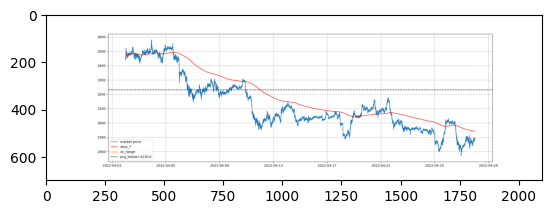

In [154]:
import matplotlib.cm as cm
# import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
frames = [] # for storing the generated images
fig = plt.figure()
# for i in range(len(img)):
#     frames.append([plt.imshow(img[i], animated=True)])

# ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
#                                 repeat_delay=1000)
metadata = dict(title='Results', artist='Cruize')
writer = PillowWriter(fps=30, metadata=metadata)
with writer.saving(fig, "result.gif", 100):
    for i in range(len(img)):
        plt.imshow(img[i])
        writer.grab_frame()

# Volatility analysis

## ETH

We will use the whole period 2019.09.01 to 2022.09.01

In [22]:
log_returns = np.log(eth_historical['close']) \
    - np.log(eth_historical['close'].shift(1))
log_returns = log_returns.dropna()
abs_log_returns=abs(log_returns)

In [72]:
def volatility_analysis(data):
    log_returns = np.log(data['close']) \
        - np.log(data['close'].shift(1))
    log_returns = log_returns.dropna()
    abs_log_returns=abs(log_returns)
    #############################
    # Of log-returns
    emw_log_returns = log_returns.ewm(alpha=0.8, adjust=False)
    mu_ema_log_returns = emw_log_returns.mean().mean()

    std_ema_log_returns = emw_log_returns.std().mean()

    # max and min
    log_returns_max = log_returns.max()
    log_returns_min = log_returns.min()
    ##############################
    # Of abs log-returns
    emw_abs_log_returns = abs_log_returns.ewm(alpha=0.8, adjust=False)
    mu_ema_abs_log_returns = emw_abs_log_returns.mean().mean()
    std_ema_abs_log_returns = emw_abs_log_returns.std().mean()


    # Others
    abs_log_returns_max = abs_log_returns.max()
    abs_log_returns_min = abs_log_returns.min()
    return mu_ema_log_returns, std_ema_log_returns, mu_ema_abs_log_returns, std_ema_abs_log_returns, log_returns_max, log_returns_min,abs_log_returns_max,abs_log_returns_min

In [24]:
mu_ema_log_returns, std_ema_log_returns, mu_ema_abs_log_returns, std_ema_abs_log_returns,log_returns_max, log_returns_min,abs_log_returns_max,abs_log_returns_min = volatility_analysis(eth_historical)

In [94]:
i_th_month = 4
data = eth_historical.loc[months_eth[i_th_month][0][0]:months_eth[i_th_month][0][1]]
log_returns = np.log(data['close']) \
    - np.log(data['close'].shift(1))
log_returns = log_returns.dropna()
abs_log_returns=abs(log_returns)
mu_ema_log_returns, std_ema_log_returns, mu_ema_abs_log_returns, std_ema_abs_log_returns,log_returns_max, log_returns_min,abs_log_returns_max,abs_log_returns_min = volatility_analysis(data)

Let's see that mostly of data falls between mean of EMA +- 5 std.

Jumps of log(prices) (log_returns):
Mean of EMA price jump: -2.4e-05%
Std (of Mean EMA): 0.064839%
Max jump: 1.506117%
Min jump: -3.280876%
Mean of EMA +-2*Std (of Mean EMA): ['-0.13%', '0.13%']
Percentage of jumps within Mean of EMA +-2*Std (of Mean EMA): 86.896%
Mean of EMA +-3*Std (of Mean EMA): ['-0.195%', '0.194%']
Percentage of jumps within Mean of EMA +-3*Std (of Mean EMA): 93.318%
Mean of EMA +-4*Std (of Mean EMA): ['-0.259%', '0.259%']
Percentage of jumps within Mean of EMA +-4*Std (of Mean EMA): 96.579%


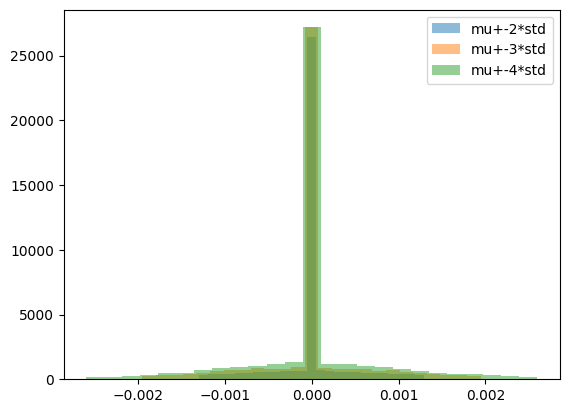

In [95]:
print("Jumps of log(prices) (log_returns):")
print("Mean of EMA price jump:",str(round(mu_ema_log_returns*100,6))+"%")
print("Std (of Mean EMA):",str(round(std_ema_log_returns*100,6))+"%")
print("Max jump:",str(round(log_returns_max*100,6))+"%")
print("Min jump:",str(round(log_returns_min*100,6))+"%")
for K in range(2,5):
    globals()["condition_"+str(K)] = (mu_ema_log_returns-K*std_ema_log_returns<log_returns)&(log_returns<mu_ema_log_returns+K*std_ema_log_returns)
    print("Mean of EMA +-" +str(K)+"*Std (of Mean EMA):", [str(round((mu_ema_log_returns-K*std_ema_log_returns)*100,3))+"%",str(round((mu_ema_log_returns+K*std_ema_log_returns)*100,3))+"%"])
    print("Percentage of jumps within Mean of EMA +-" +str(K)+"*Std (of Mean EMA):", str(round(len(log_returns[globals()["condition_"+str(K)]])/len(log_returns)*100,3))+"%")
    plt.hist(log_returns[globals()["condition_"+str(K)]], bins=25, alpha = 0.5, label = "mu+-"+str(K)+"*std")
plt.legend(loc='upper right')
plt.show()

Let's see that mostly of data falls between mean of abs EMA +- 5 std.

Jumps of log(prices) (abs_log_returns):
Average price jump of EMA: 0.047383%
Std (of Mean EMA): 0.052646%
Max jump: 3.280876%
Min jump: 0.0%
Mean of EMA +-2*Std (of Mean EMA): ['-0.058%', '0.153%']
Percentage of jumps within Mean of EMA +-2*Std (of Mean EMA): 89.642%
Mean of EMA +-3*Std (of Mean EMA): ['-0.111%', '0.205%']
Percentage of jumps within Mean of EMA +-3*Std (of Mean EMA): 94.067%
Mean of EMA +-4*Std (of Mean EMA): ['-0.163%', '0.258%']
Percentage of jumps within Mean of EMA +-4*Std (of Mean EMA): 96.518%


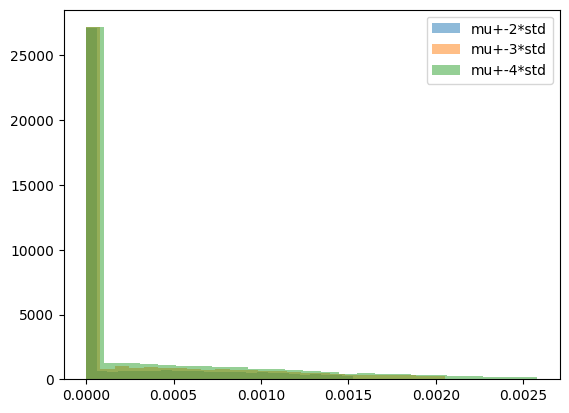

In [96]:
print("Jumps of log(prices) (abs_log_returns):")
print("Average price jump of EMA:",str(round(mu_ema_abs_log_returns*100,6))+"%")
print("Std (of Mean EMA):",str(round(std_ema_abs_log_returns*100,6))+"%")
print("Max jump:",str(round(abs_log_returns_max*100,6))+"%")
print("Min jump:",str(round(abs_log_returns_min*100,6))+"%")
for K in range(2,5):
    globals()["condition_"+str(K)] = (mu_ema_abs_log_returns-K*std_ema_abs_log_returns<abs_log_returns)&(abs_log_returns<mu_ema_abs_log_returns+K*std_ema_abs_log_returns)
    print("Mean of EMA +-" +str(K)+"*Std (of Mean EMA):", [str(round((mu_ema_abs_log_returns-K*std_ema_abs_log_returns)*100,3))+"%",str(round((mu_ema_abs_log_returns+K*std_ema_abs_log_returns)*100,3))+"%"])
    print("Percentage of jumps within Mean of EMA +-" +str(K)+"*Std (of Mean EMA):", str(round(len(abs_log_returns[globals()["condition_"+str(K)]])/len(abs_log_returns)*100,3))+"%")
    plt.hist(abs_log_returns[globals()["condition_"+str(K)]], bins=25, alpha = 0.5, label = "mu+-"+str(K)+"*std")
plt.legend(loc='upper right')
plt.show()

Based on the hypotesis of log_returns ~ N(mu, sigma) then the volatility estimation (for each K) we should take in order to be covered against "most" common price movement within minutes is

In [20]:
print("Increments based on H1: log_r ~ N(mu_ema, sigma_ema): math.e ** (mu_ema_log_returns-std_ema_log_returns^2/2 + factor *std_ema_log_returns)")
for K in range(1,6):
    print("factor = "+str(K), str(round((math.e ** (mu_ema_log_returns-std_ema_log_returns**2/2 + K *std_ema_log_returns)-1)*100,6))+"%")
    print("1+mu+K*sigma, K = "+str(K), str(round((mu_ema_log_returns+ K *std_ema_log_returns)*100,6))+"%")

Increments based on H1: log_r ~ N(mu_ema, sigma_ema): math.e ** (mu_ema_log_returns-std_ema_log_returns^2/2 + factor *std_ema_log_returns)
factor = 1 0.094955%
1+mu+K*sigma, K = 1 0.094955%
factor = 2 0.189905%
1+mu+K*sigma, K = 2 0.189769%
factor = 3 0.284944%
1+mu+K*sigma, K = 3 0.284584%
factor = 4 0.380074%
1+mu+K*sigma, K = 4 0.379399%
factor = 5 0.475294%
1+mu+K*sigma, K = 5 0.474213%


#### Non-stationarity

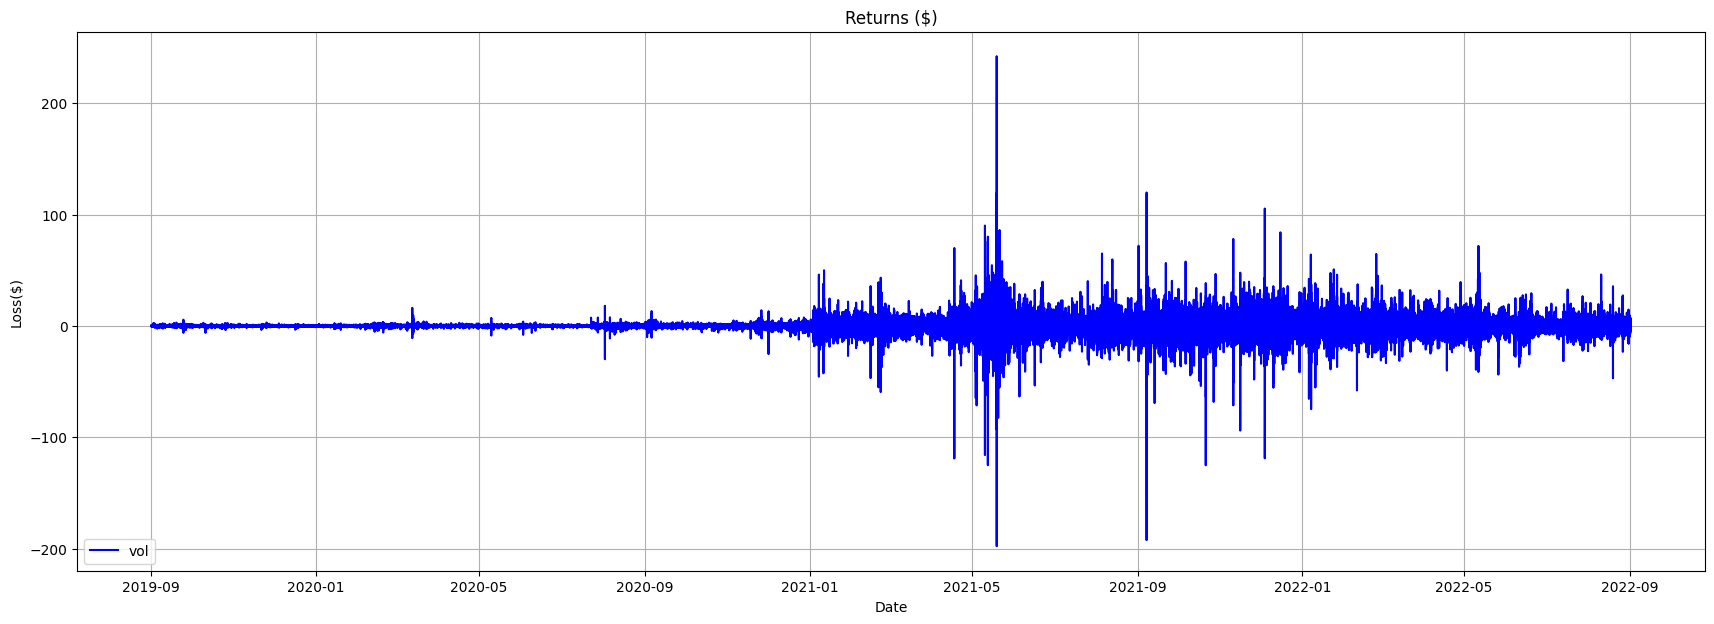

In [21]:
# Changes in vol historically
data = eth_historical
data_2019_2020 = eth_historical.loc["2019-09-01 00:00:00":"2020-09-01 00:00:00"]
data_2020_2021 = eth_historical.loc["2020-09-01 00:00:00":"2021-09-01 00:00:00"]
data_2021_2022 = eth_historical.loc["2021-09-01 00:00:00":"2022-09-01 00:00:00"]
returns_usd = data['close'] - data['close'].shift(1)
log_returns = np.log(data['close']) - np.log(data['close'].shift(1))
log_returns_2019_2020 = np.log(data_2019_2020['close']) - np.log(data_2019_2020['close'].shift(1))
log_returns_2020_2021 = np.log(data_2020_2021['close']) - np.log(data_2020_2021['close'].shift(1))
log_returns_2021_2022 = np.log(data_2021_2022['close']) - np.log(data_2021_2022['close'].shift(1))
fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.set_title('Returns ($)')
axs.set_xlabel('Date')
axs.set_ylabel('Loss($)')
# axs.plot(log_returns.ewm(alpha=0.8, adjust=False).std(), label='vol', color='blue')
axs.plot(returns_usd, label='vol', color='blue')
# axs.plot(log_returns_2020_2021, label='vol', color='red')
# axs.plot(log_returns_2021_2022, label='vol', color='orange')
axs.grid()
axs.legend(loc='lower left')
plt.show()
# plt.savefig('Files/foo.png')

## BTC

We will use the whole period 2019.09.01 to 2022.09.01

In [29]:
log_returns = np.log(btc_historical['close']) \
    - np.log(btc_historical['close'].shift(1))
log_returns = log_returns.dropna()
abs_log_returns=abs(log_returns)

In [30]:
mu_ema_log_returns, std_ema_log_returns, mu_ema_abs_log_returns, std_ema_abs_log_returns,log_returns_max, log_returns_min,abs_log_returns_max,abs_log_returns_min = volatility_analysis(btc_historical)

Let's see that mostly of data falls between mean of EMA +- 5 std.

Jumps of log(prices) (log_returns):
Mean of EMA price jump: 4.4e-05%
Std of Mean EMA: 0.075587%
Max jump: 6.531379%
Min jump: -6.425794%
Mean of EMA +-2*Std of Mean EMA: ['-0.151%', '0.151%']
Percentage of jumps within Mean of EMA +-2*Std of Mean EMA: 90.205%
Mean of EMA +-3*Std of Mean EMA: ['-0.227%', '0.227%']
Percentage of jumps within Mean of EMA +-3*Std of Mean EMA: 95.909%
Mean of EMA +-4*Std of Mean EMA: ['-0.302%', '0.302%']
Percentage of jumps within Mean of EMA +-4*Std of Mean EMA: 97.954%


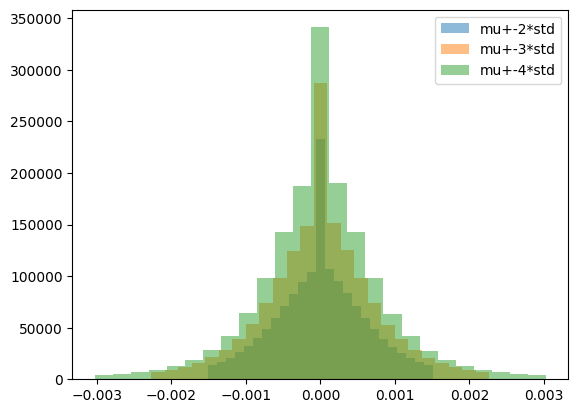

In [31]:
print("Jumps of log(prices) (log_returns):")
print("Mean of EMA price jump:",str(round(mu_ema_log_returns*100,6))+"%")
print("Std of Mean EMA:",str(round(std_ema_log_returns*100,6))+"%")
print("Max jump:",str(round(log_returns_max*100,6))+"%")
print("Min jump:",str(round(log_returns_min*100,6))+"%")
for K in range(2,5):
    globals()["condition_"+str(K)] = (mu_ema_log_returns-K*std_ema_log_returns<log_returns)&(log_returns<mu_ema_log_returns+K*std_ema_log_returns)
    print("Mean of EMA +-" +str(K)+"*Std of Mean EMA:", [str(round((mu_ema_log_returns-K*std_ema_log_returns)*100,3))+"%",str(round((mu_ema_log_returns+K*std_ema_log_returns)*100,3))+"%"])
    print("Percentage of jumps within Mean of EMA +-" +str(K)+"*Std of Mean EMA:", str(round(len(log_returns[globals()["condition_"+str(K)]])/len(log_returns)*100,3))+"%")
    plt.hist(log_returns[globals()["condition_"+str(K)]], bins=25, alpha = 0.5, label = "mu+-"+str(K)+"*std")
plt.legend(loc='upper right')
plt.show()

Let's see that mostly of data falls between mean of abs EMA +- 5 std.

Jumps of log(prices) (abs_log_returns):
Average price jump of EMA: 0.066743%
Std of average value of EMA: 0.046327%
Max jump: 6.531379%
Min jump: 0.0%
Mean of EMA +-2*Std of Mean EMA: ['-0.026%', '0.159%']
Percentage of jumps within Mean of EMA +-2*Std of Mean EMA: 91.194%
Mean of EMA +-3*Std of Mean EMA: ['-0.072%', '0.206%']
Percentage of jumps within Mean of EMA +-3*Std of Mean EMA: 94.905%
Mean of EMA +-4*Std of Mean EMA: ['-0.119%', '0.252%']
Percentage of jumps within Mean of EMA +-4*Std of Mean EMA: 96.809%


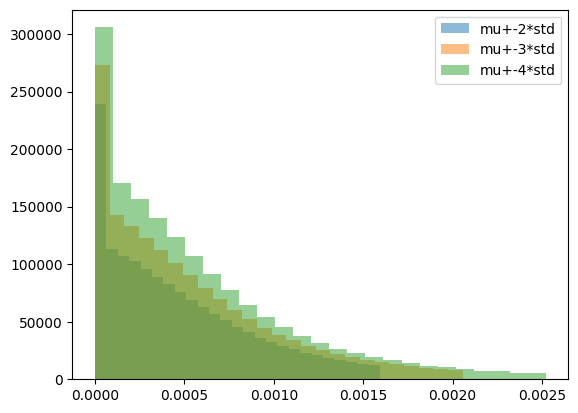

In [32]:
print("Jumps of log(prices) (abs_log_returns):")
print("Average price jump of EMA:",str(round(mu_ema_abs_log_returns*100,6))+"%")
print("Std of average value of EMA:",str(round(std_ema_abs_log_returns*100,6))+"%")
print("Max jump:",str(round(abs_log_returns_max*100,6))+"%")
print("Min jump:",str(round(abs_log_returns_min*100,6))+"%")
for K in range(2,5):
    globals()["condition_"+str(K)] = (mu_ema_abs_log_returns-K*std_ema_abs_log_returns<abs_log_returns)&(abs_log_returns<mu_ema_abs_log_returns+K*std_ema_abs_log_returns)
    print("Mean of EMA +-" +str(K)+"*Std of Mean EMA:", [str(round((mu_ema_abs_log_returns-K*std_ema_abs_log_returns)*100,3))+"%",str(round((mu_ema_abs_log_returns+K*std_ema_abs_log_returns)*100,3))+"%"])
    print("Percentage of jumps within Mean of EMA +-" +str(K)+"*Std of Mean EMA:", str(round(len(abs_log_returns[globals()["condition_"+str(K)]])/len(abs_log_returns)*100,3))+"%")
    plt.hist(abs_log_returns[globals()["condition_"+str(K)]], bins=25, alpha = 0.5, label = "mu+-"+str(K)+"*std")
plt.legend(loc='upper right')
plt.show()

Based on the hypotesis of log_returns ~ N(mu, sigma) then the volatility estimation (for each K) we should take in order to be covered against "most" common price movement within minutes is

In [26]:
print("Increments based on H1: log_r ~ N(mu_ema, sigma_ema): math.e ** (mu_ema_log_returns-std_ema_log_returns^2/2 + factor *std_ema_log_returns)")
for K in range(1,6):
    print("factor = "+str(K), str(round((math.e ** (mu_ema_log_returns-std_ema_log_returns**2/2 + K *std_ema_log_returns)-1)*100,6))+"%")
    print("1+mu+K*sigma, K = "+str(K), str(round((mu_ema_log_returns+ K *std_ema_log_returns)*100,6))+"%")

Increments based on H1: log_r ~ N(mu_ema, sigma_ema): math.e ** (mu_ema_log_returns-std_ema_log_returns^2/2 + factor *std_ema_log_returns)
factor = 1 0.075631%
1+mu+K*sigma, K = 1 0.075631%
factor = 2 0.151304%
1+mu+K*sigma, K = 2 0.151218%
factor = 3 0.227034%
1+mu+K*sigma, K = 3 0.226805%
factor = 4 0.302821%
1+mu+K*sigma, K = 4 0.302392%
factor = 5 0.378666%
1+mu+K*sigma, K = 5 0.377979%


#### Non-stationarity

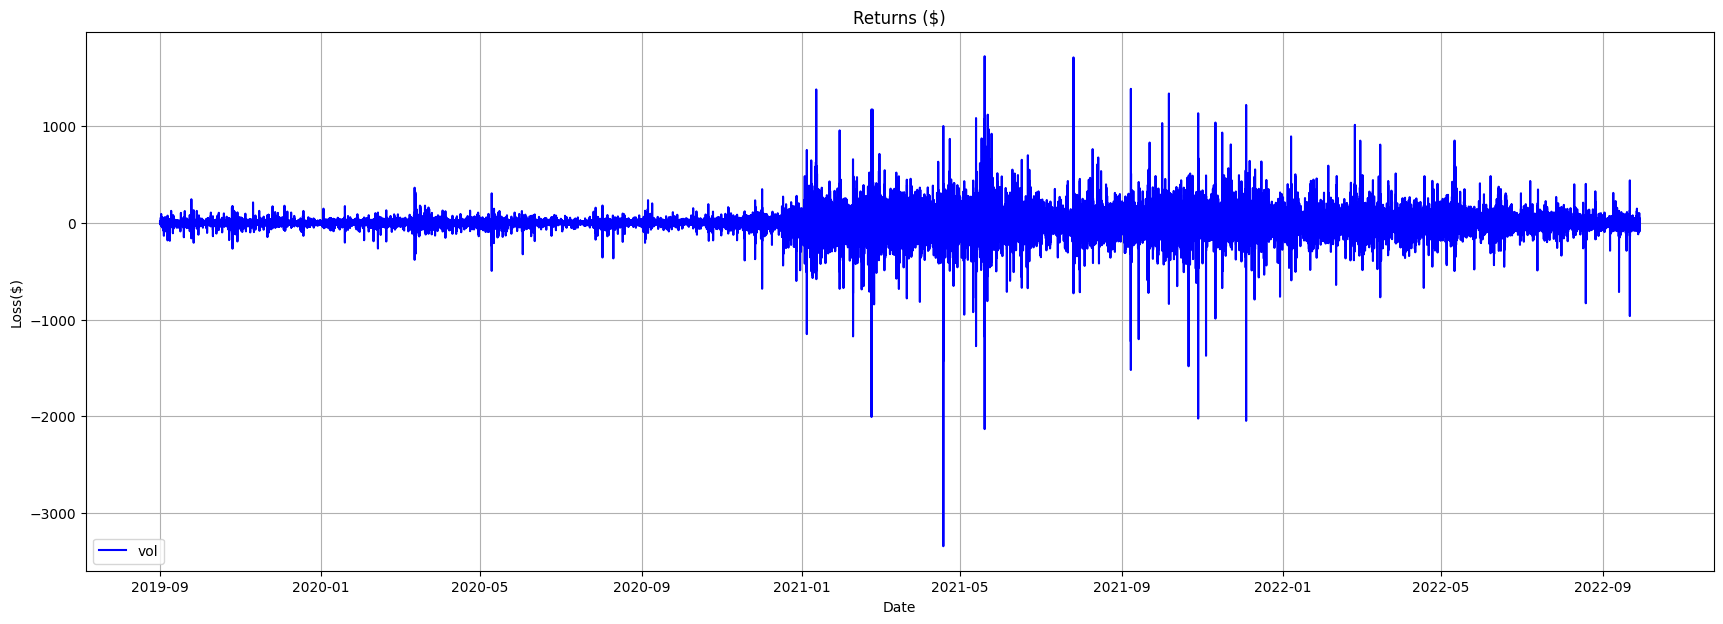

In [28]:
# Changes in vol historically
data = btc_historical
data_2019_2020 = btc_historical.loc["2019-09-01 00:00:00":"2020-09-01 00:00:00"]
data_2020_2021 = btc_historical.loc["2020-09-01 00:00:00":"2021-09-01 00:00:00"]
data_2021_2022 = btc_historical.loc["2021-09-01 00:00:00":"2022-09-01 00:00:00"]
returns_usd = data['close'] - data['close'].shift(1)
log_returns = np.log(data['close']) - np.log(data['close'].shift(1))
log_returns_2019_2020 = np.log(data_2019_2020['close']) - np.log(data_2019_2020['close'].shift(1))
log_returns_2020_2021 = np.log(data_2020_2021['close']) - np.log(data_2020_2021['close'].shift(1))
log_returns_2021_2022 = np.log(data_2021_2022['close']) - np.log(data_2021_2022['close'].shift(1))
fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.set_title('Returns ($)')
axs.set_xlabel('Date')
axs.set_ylabel('Loss($)')
# axs.plot(log_returns.ewm(alpha=0.8, adjust=False).std(), label='vol', color='blue')
axs.plot(returns_usd, label='vol', color='blue')
# axs.plot(log_returns_2020_2021, label='vol', color='red')
# axs.plot(log_returns_2021_2022, label='vol', color='orange')
axs.grid()
axs.legend(loc='lower left')
plt.show()
# plt.savefig('Files/foo.png')

# Simulations

We define the parameter values for the simulations.

In [109]:
stk = 1000000
slippage = 0.0005
pcgs_below = [0.05] # 0.01, 0.02, 0.03, 
taker_fees_counter_lengths = {}
realised_pnl_results = {}
unrealised_pnl_results = {}
ema_days = []
for i in [7]: # 0.25,0.5,1,
    globals()['window_sma_'+str(i)+'_days'] = i*24*60
    ema_days.append(i*24*60)
    
fractions = [1/2]

## ETH

In order to test pnl/costs of the whole strategy under different stress sncearios we will use high volatile periods of time, and for each one we will take one price that was crossed many times as the floor.

Now let's define a list with some periods of time and relevant prices to use for calling the previous function and run several simulations at once.

In [20]:
# Best cases 0 to 50 crosses
best_1_month_eth = [["2022-04-02 00:00:00","2022-05-01 00:00:00"], 3400]

# Normal cases 50 to 150 crosses
normal_1_month_eth = [[["2020-05-31 00:00:00","2020-06-30 00:00:00"], 240],
                  [["2021-12-01 00:00:00","2022-01-01 00:00:00"], eth_historical['close'].max()*0.8],
                 [["2019-11-15 00:00:00","2019-12-15 00:00:00"], 182]]

# Worst cases 150+ crosses
worst_1_month_eth = [["2019-10-01 03:00:00","2019-11-01 00:00:00"],183]

worst_3_month_eth = [ [["2020-05-31 00:00:00","2020-09-01 00:00:00"],240], [["2019-09-15 00:00:00","2019-12-15 00:00:00"],182]]
worst_6_month_eth = [ [["2020-02-20 00:00:00","2020-09-01 00:00:00"],240], [["2019-09-15 00:00:00","2020-03-15 00:00:00"],182]]
worst_1_year_eth = [ ["2019-09-01 00:00:00","2020-09-01 00:00:00"],170] 

In [195]:
# Period of Simulations
names_eth = [
    "best_1_month_eth",
    "normal_1_month_eth[0]",
    "normal_1_month_eth[1]",
    "normal_1_month_eth[2]",
    "worst_1_month_eth"
]
months_eth = [
    best_1_month_eth,
    normal_1_month_eth[0], 
    normal_1_month_eth[1], 
    normal_1_month_eth[2], 
    worst_1_month_eth
]

three_months_eth_names = [
    "worst_3_months_eth[0]",
    "worst_3_months_eth[1]"
]

three_months_eth = [
    worst_3_month_eth[0],
    worst_3_month_eth[1]
]

### Plots

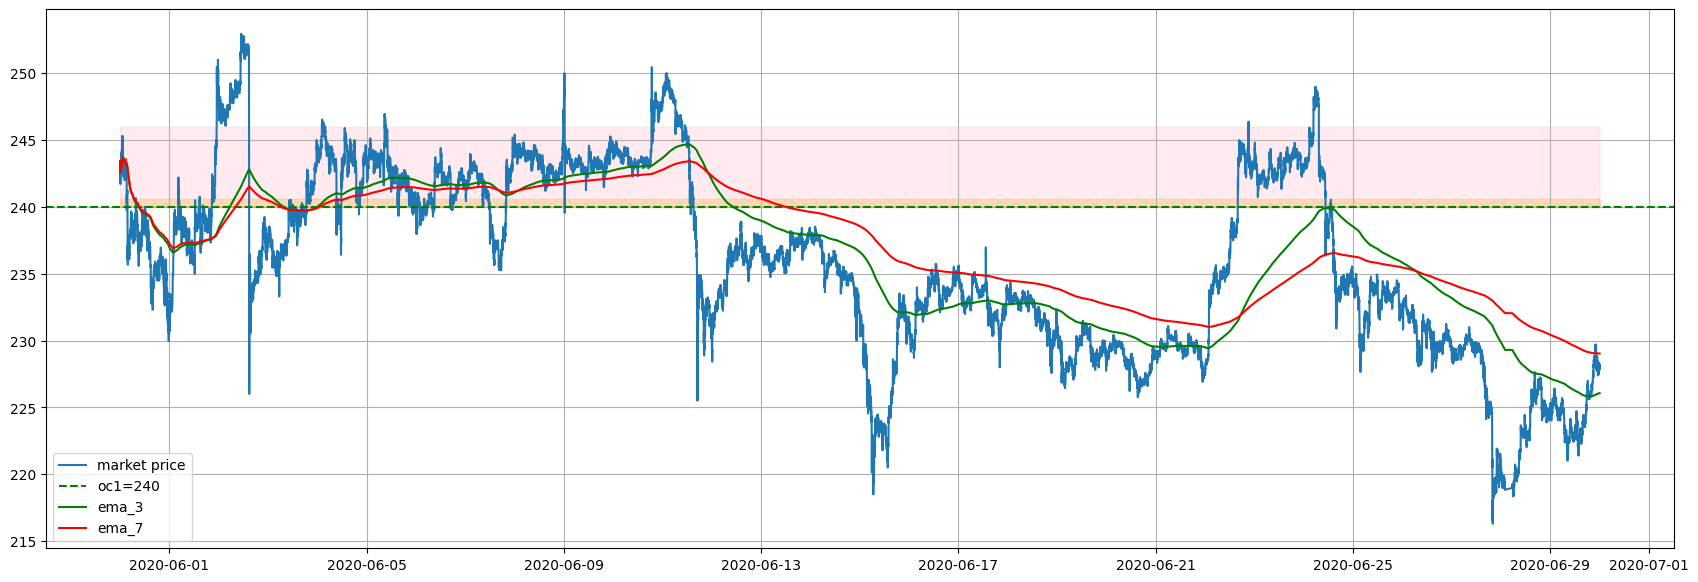

In [63]:
# Period of Simulations

slippage = 0.0005
# worst_6_month = [[["2020-02-20 00:00:00","2020-09-01 00:00:00"],240]]
# worst_1_year = [[["2019-09-01 00:00:00","2020-03-01 00:00:00"],170]]
# periods_n_open_close = [["2019-11-10 00:00:00","2019-12-15 00:00:00"],182]
periods_n_open_close=[["2020-05-31 00:00:00","2020-06-30 00:00:00"], 240]#months_eth[1]
period = periods_n_open_close[0]
data = eth_historical.loc[period[0]:period[1]]
ema_span = data['close'].ewm(span=1*7*24*60).mean()
ema_alpha = data['close'].ewm(alpha=0.0005, adjust=False).mean()
sma = data['close'].rolling(window=1*7*24*60).mean()
parameter_manager = ParameterManager()
last_date = period[1]
vol = parameter_manager.calc_vol(last_date, data)
mu, sigma = vol
open_close = periods_n_open_close[1]
# floor just in order to get triger_price['open_close_1'] = open_close_1
floor = open_close / ((1+slippage)*(1+mu+2*sigma))
fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.plot(data['close'], color='tab:blue', label='market price')
axs.axhline(y=open_close, 
            color='green', 
            linestyle='--', 
            label='oc1='+str(round(open_close,3)))
# axs.plot(ema_span, label='ema_span', color='magenta')
# axs.plot(ema_alpha, label='ema_alpha', color='green')
# axs.plot(sma, label='sma', color='red')
# for i in range(1,8):
#     globals()['sma_'+str(i)]=data['close'].rolling(window=1*i*24*60).mean()
#     axs.plot(globals()['sma_'+str(i)], label='sma_'+str(i), color='green')
# for i in range(1,8):
#     globals()['ema_'+str(i)]=data['close'].ewm(span=1*i*24*60).mean()
#     axs.plot(globals()['ema_'+str(i)], label='ema_'+str(i), color='red')
axs.plot(data['close'].ewm(span=1*3*24*60).mean(), label='ema_3', color='green')
axs.plot(data['close'].ewm(span=1*7*24*60).mean(), label='ema_7', color='red')
plt.fill_between(data['close'].index, open_close,open_close*(1+0.0001),color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
plt.fill_between(data['close'].index, open_close,open_close*(1+0.0025),color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
plt.fill_between(data['close'].index, open_close,open_close*(1+0.025),color='pink', alpha=0.3)#,hatch="X",edgecolor="b")

# axs.axhline(y=(min(data['close'])+open_close)/2, 
#             color='red', 
#             linestyle='--', 
#             label='oc1='+str(round((min(data['close'])+open_close)/2,3)))
axs.grid()
axs.legend(loc='lower left')
plt.show()
# plt.savefig('Files/foo.png')

For each one let's see how the price moved and how many times the candidate to floor was crossed.

In [ ]:
ema_days_test = []
for i in [0.25,0.5,1,3,7]: # 
    globals()['window_sma_'+str(i)+'_days'] = i*24*60
    ema_days_test.append(i*24*60)

In [ ]:
kama(data, changes_period, fast_period, slow_period)

Period best_1_month_eth
The price 3400 was crossed 1 times.
The period looks like this...


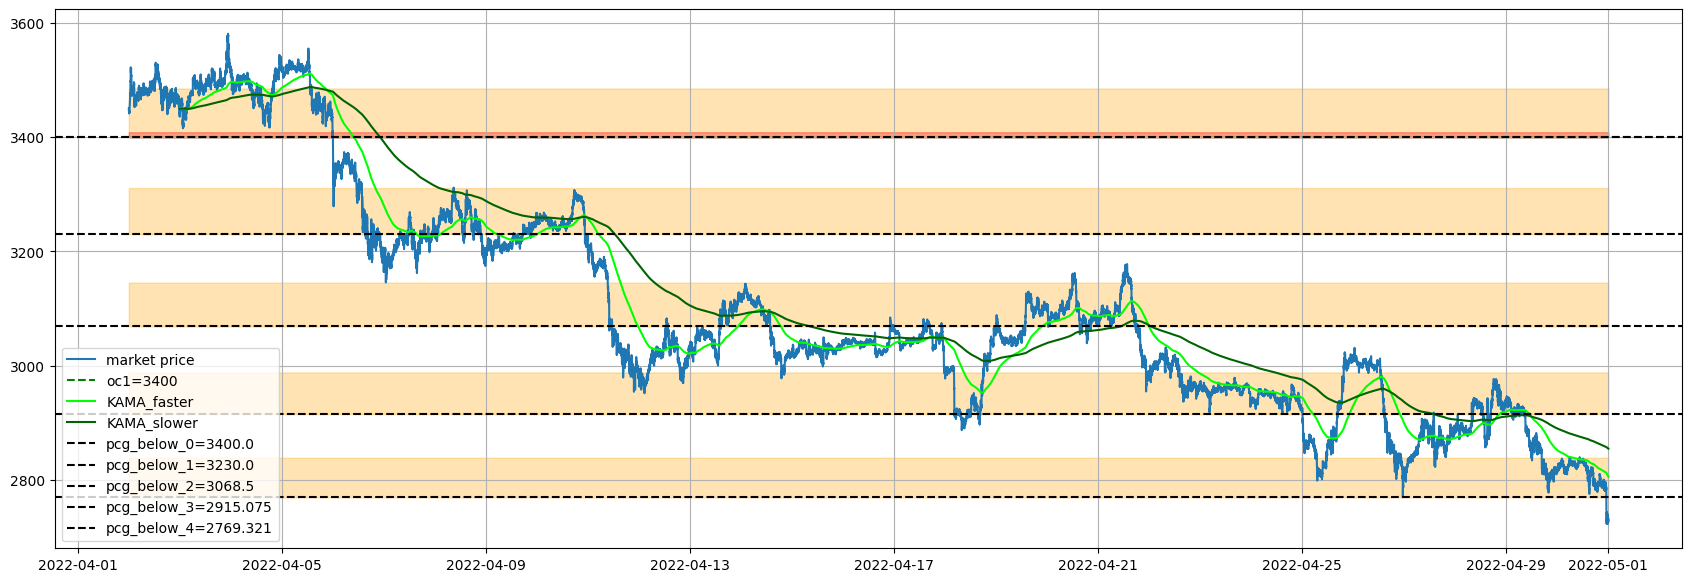

################################## 

Period normal_1_month_eth[0]
The price 240 was crossed 121 times.
The period looks like this...


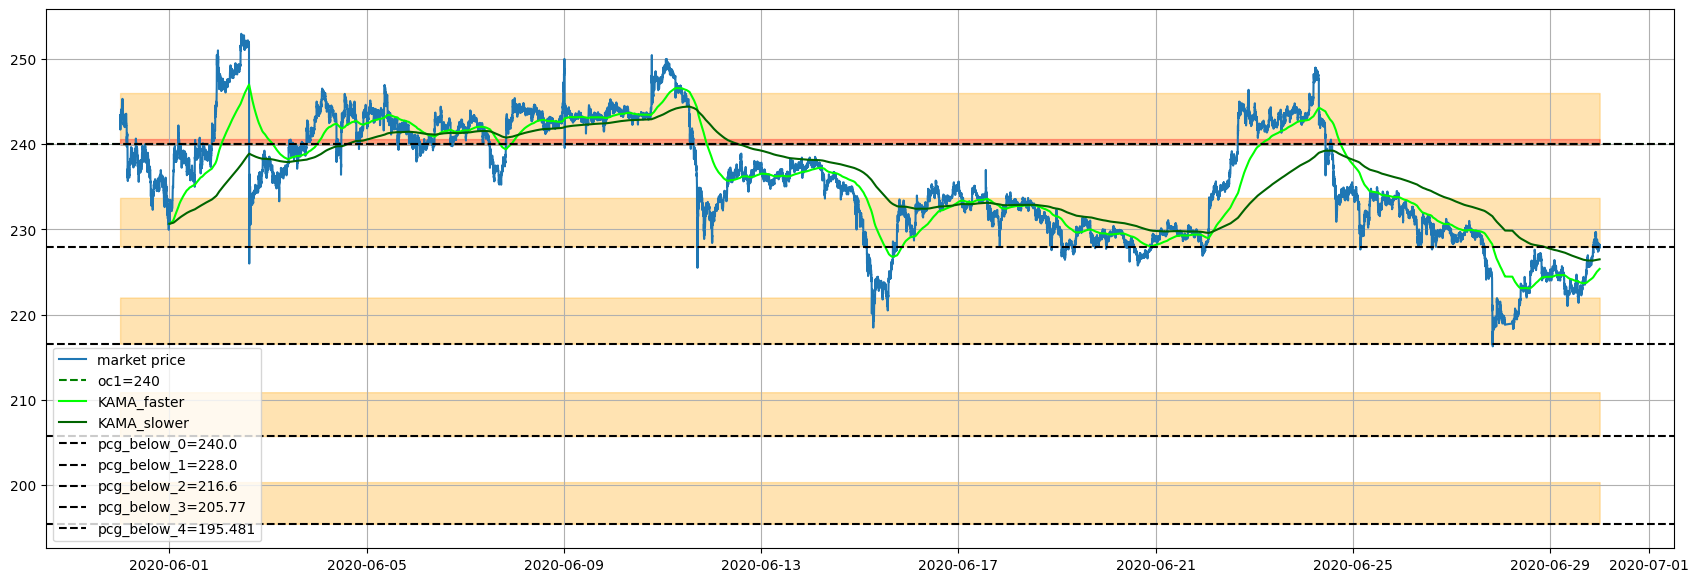

################################## 

Period normal_1_month_eth[1]
The price 3891.8 was crossed 145 times.
The period looks like this...


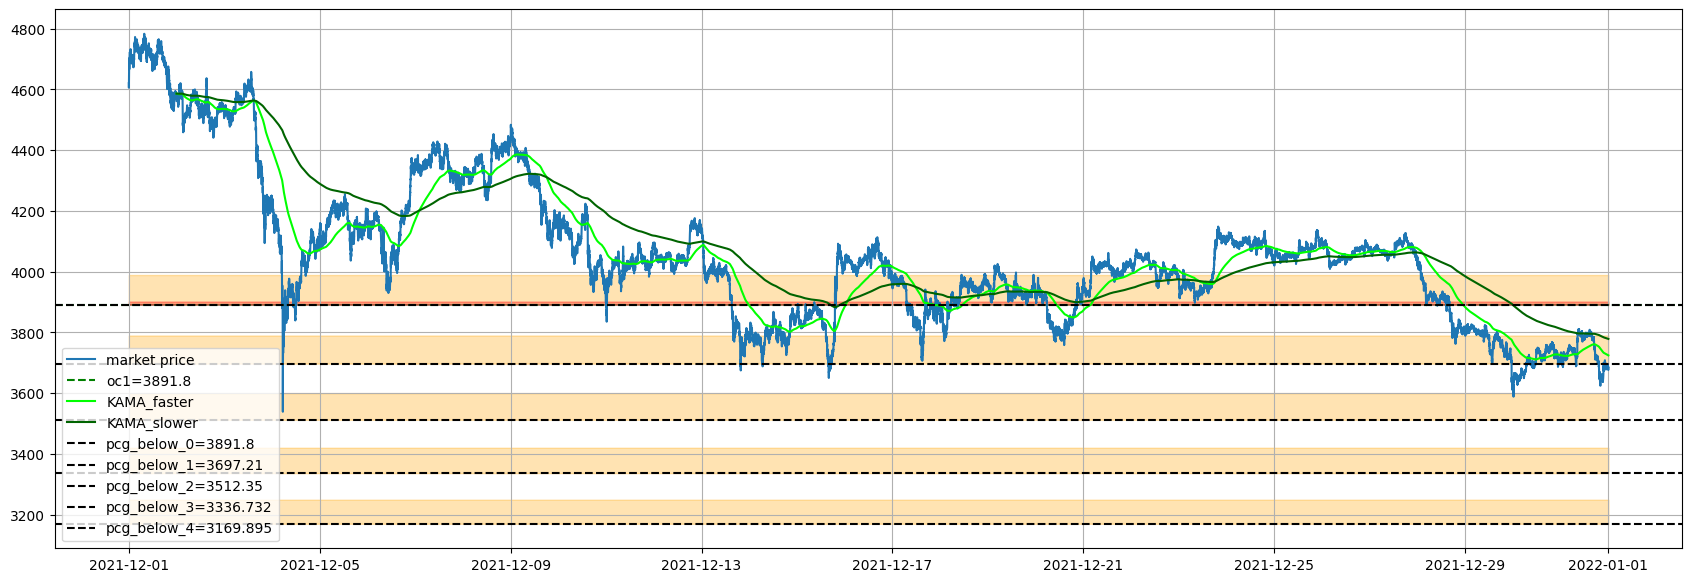

################################## 

Period normal_1_month_eth[2]
The price 182 was crossed 56 times.
The period looks like this...


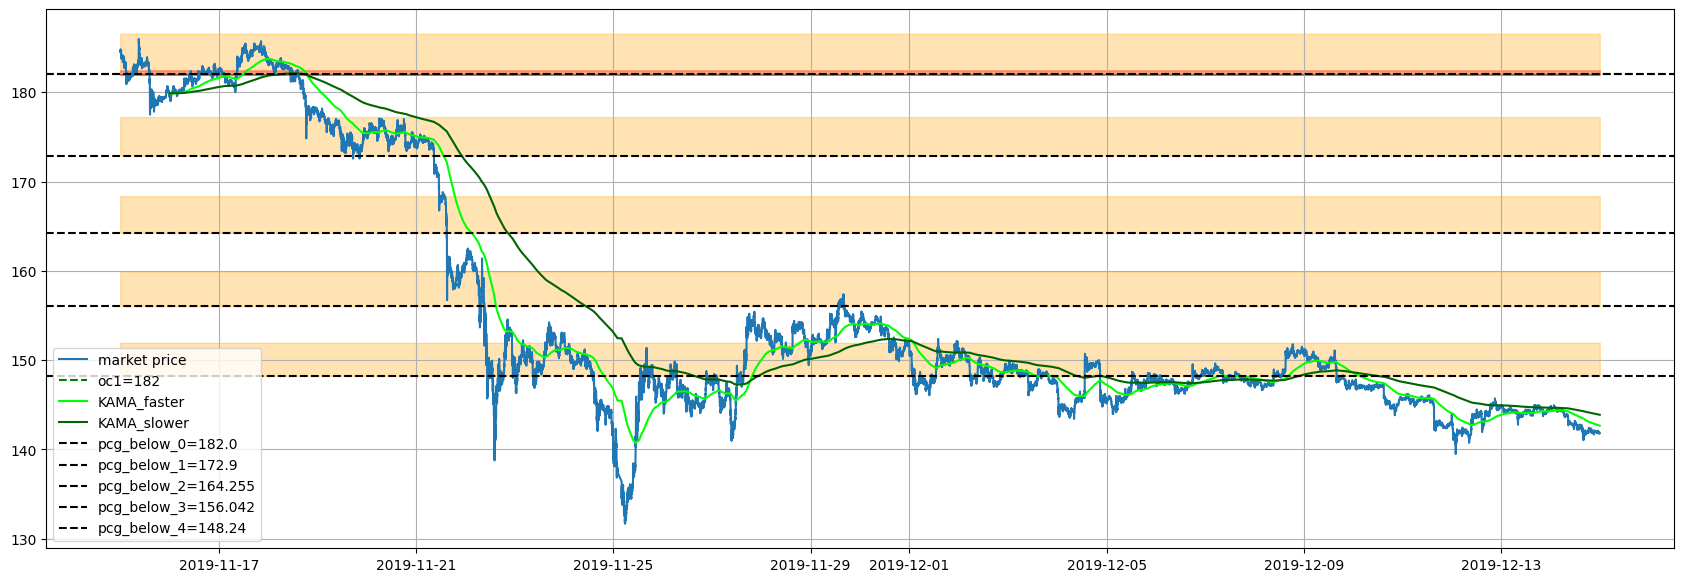

################################## 

Period worst_1_month_eth
The price 183 was crossed 297 times.
The period looks like this...


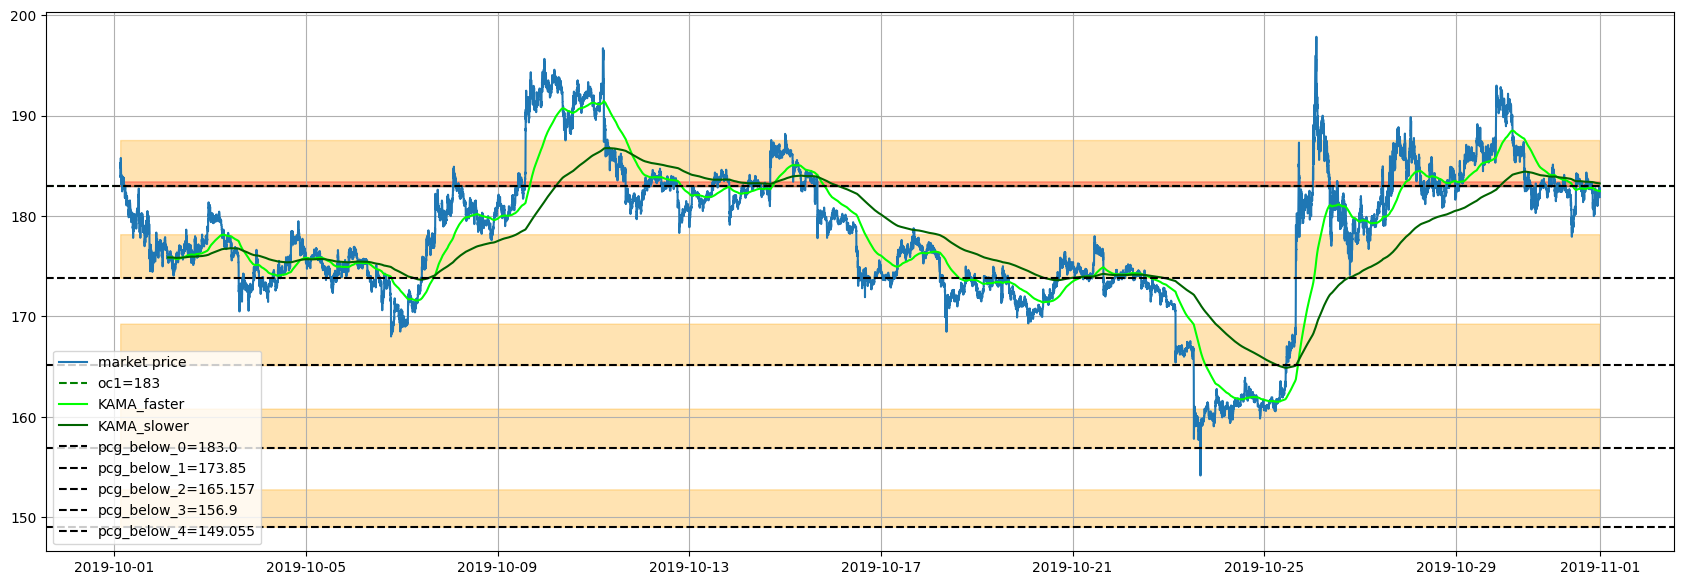

################################## 



In [203]:
for i in range(len(names_eth)):
    periods_n_open_close = months_eth[i]
    name = names_eth[i]
    period = periods_n_open_close[0]
    p = periods_n_open_close[1]
    data_set = eth_historical.loc[period[0]:period[1]]
    crosses = cross_counter(data_set, p)
    oc_width = 0.00001
    pcg_below = 0.05
    fraction = 1/2
    print("Period", name)
    print("The price "+str(p)+" was crossed "+str(crosses['down']['crossed_down'] + crosses['up']['crossed_up'])+" times.")
    print("The period looks like this...")
    # plot_period(data_set, periods_n_open_close, slippage, oc_width, ema_days)
    parameter_manager = ParameterManager()
    last_date = period[1]
    vol = parameter_manager.calc_vol(last_date, data_set)
    mu, sigma = vol
    open_close = periods_n_open_close[1]
    floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
    fig, axs = plt.subplots(1, 1, figsize=(21, 7))
    axs.plot(data_set['close'], color='tab:blue', label='market price')
    axs.axhline(y=open_close, 
                color='green', 
                linestyle='--', 
                label='oc1='+str(round(open_close,3)))
    # color=cm.rainbow(np.linspace(0,1,int(ema_days_test[-1]/(24*60))+2))
    # for ema_day in ema_days_test[2:]:
    #     axs.plot(data_set['close'].ewm(span=ema_day).mean(), 
    #              label='ema_'+str(int(ema_day/(24*60))), 
    #              color=color[int(ema_day/(24*60))+1])
    
    # DEMA Double EMA
    # axs.plot(2*data_set['close'].ewm(span=12*60).mean()-data_set['close'].ewm(span=12*60).mean().ewm(span=6*60).mean(), 
    #              label='ema_'+str(0.5), color='orange') 
    #              # color=color[int(0.5)])
    
    # MA for different spans
    # axs.plot(data_set['close'].ewm(span=7*24*60).mean(), 
    #              label='ema_'+str(7), color = 'black') 
    # axs.plot(data_set['close'].ewm(span=5*24*60).mean(), 
    #              label='ema_'+str(5), color = 'magenta') 
    # axs.plot(data_set['close'].ewm(span=3*24*60).mean(), 
    #              label='ema_'+str(3), color = 'orange') 
    
    # KAMA Adaptive MA
    axs.plot(kama(data_set['close'], 24*60, 30, 50), 
         color='lime', label='KAMA_faster')
    axs.plot(kama(data_set['close'], 24*60, 10, 100), 
         color='darkgreen', label='KAMA_slower')
                 # color=color[int(0.25)+1])
    
    # Ranges as they change
    for i in range(5):
        axs.axhline(y=open_close*(1-pcg_below)**i, 
                color='black', 
                linestyle='--', 
                label='pcg_below_'+str(i)+"="+str(round(open_close*(1-pcg_below)**i,3)))
        plt.fill_between(data_set['close'].index, 
                         open_close*(1-pcg_below)**i,
                         open_close*(1-pcg_below)**i*(1+pcg_below*fraction),
                         color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
    plt.fill_between(data_set['close'].index, 
                     open_close,open_close*(1+0.0025),
                     color='red', alpha=0.3)#,hatch="X",edgecolor="b")
    plt.fill_between(data_set['close'].index, open_close,open_close*(1+oc_width),color='black', alpha=0.3)#,hatch="X",edgecolor="b")
    axs.grid()
    axs.legend(loc='lower left')
    plt.show()
    print("################################## \n")
    # plt.savefig(name+'_test.png')

Period best_1_month_eth
The price 3400 was crossed 1 times.
The period looks like this...


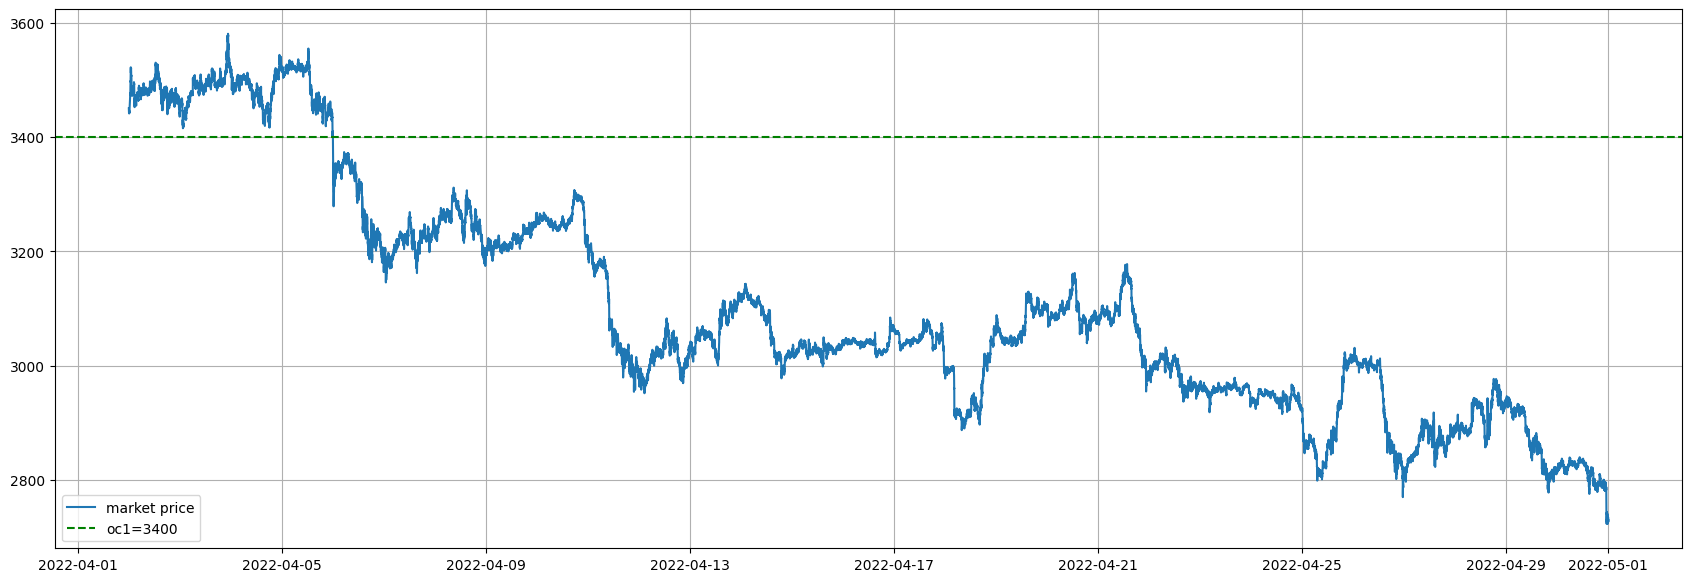

##################################

Period normal_1_month_eth[0]
The price 240 was crossed 121 times.
The period looks like this...


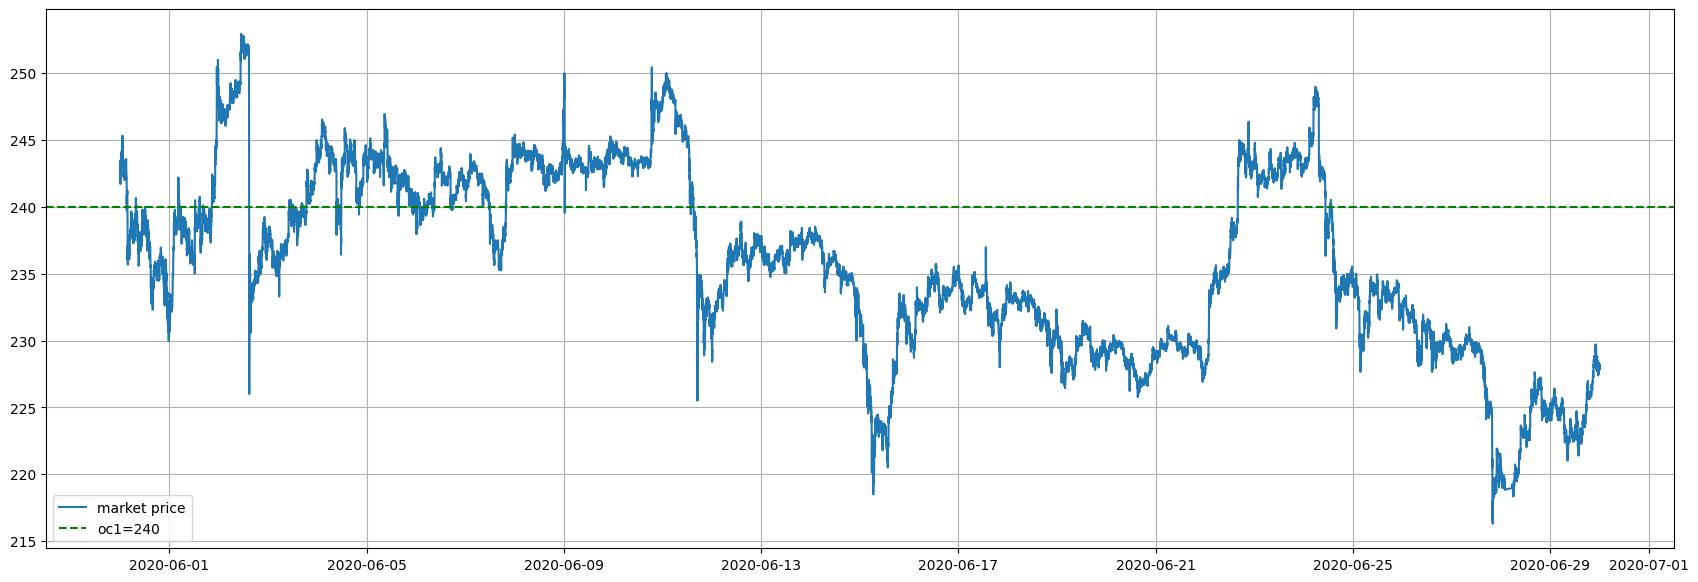

##################################

Period normal_1_month_eth[1]
The price 3891.8 was crossed 145 times.
The period looks like this...


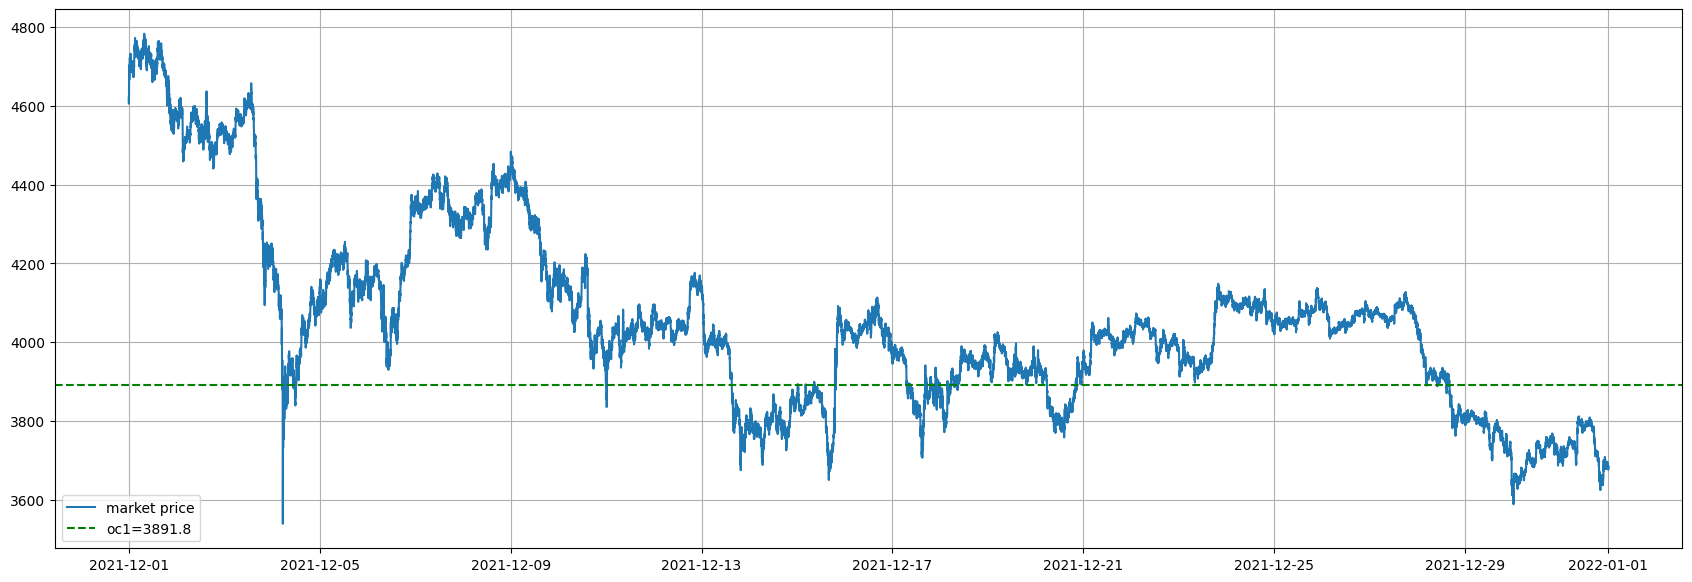

##################################

Period normal_1_month_eth[2]
The price 182 was crossed 56 times.
The period looks like this...


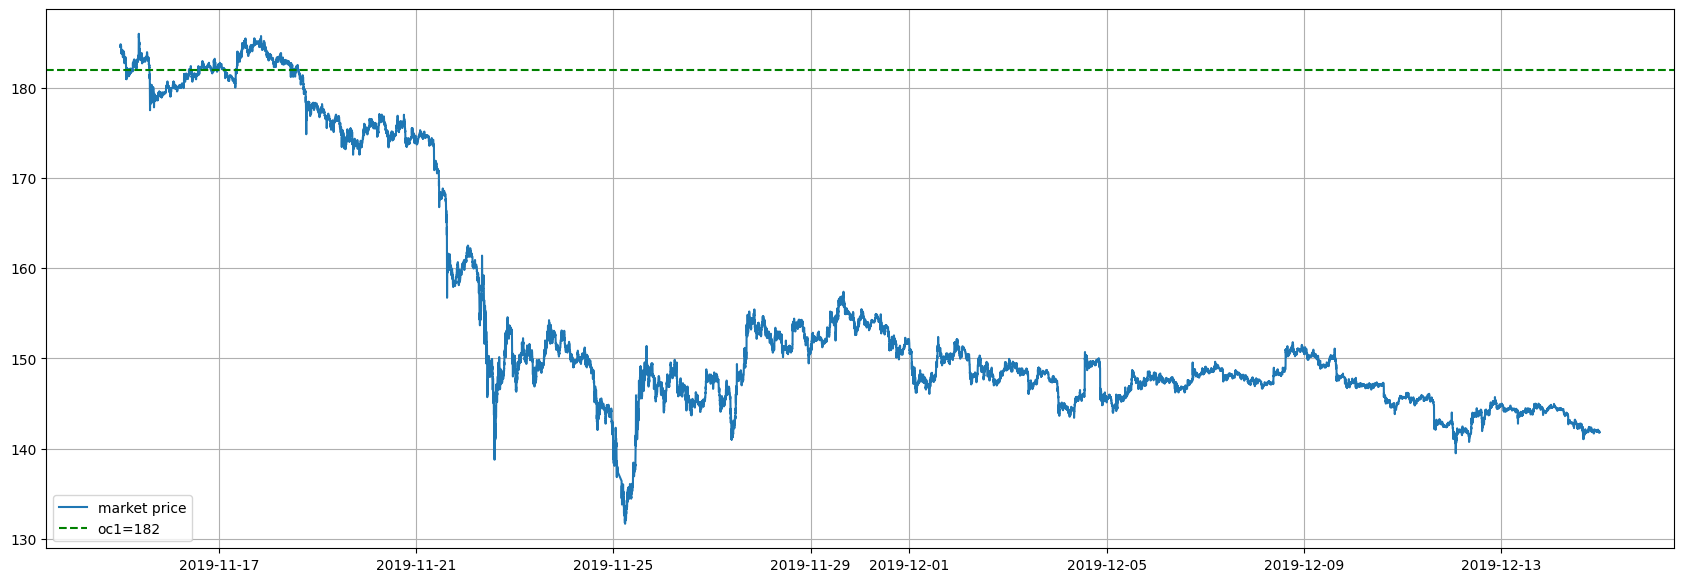

##################################

Period worst_1_month_eth
The price 183 was crossed 297 times.
The period looks like this...


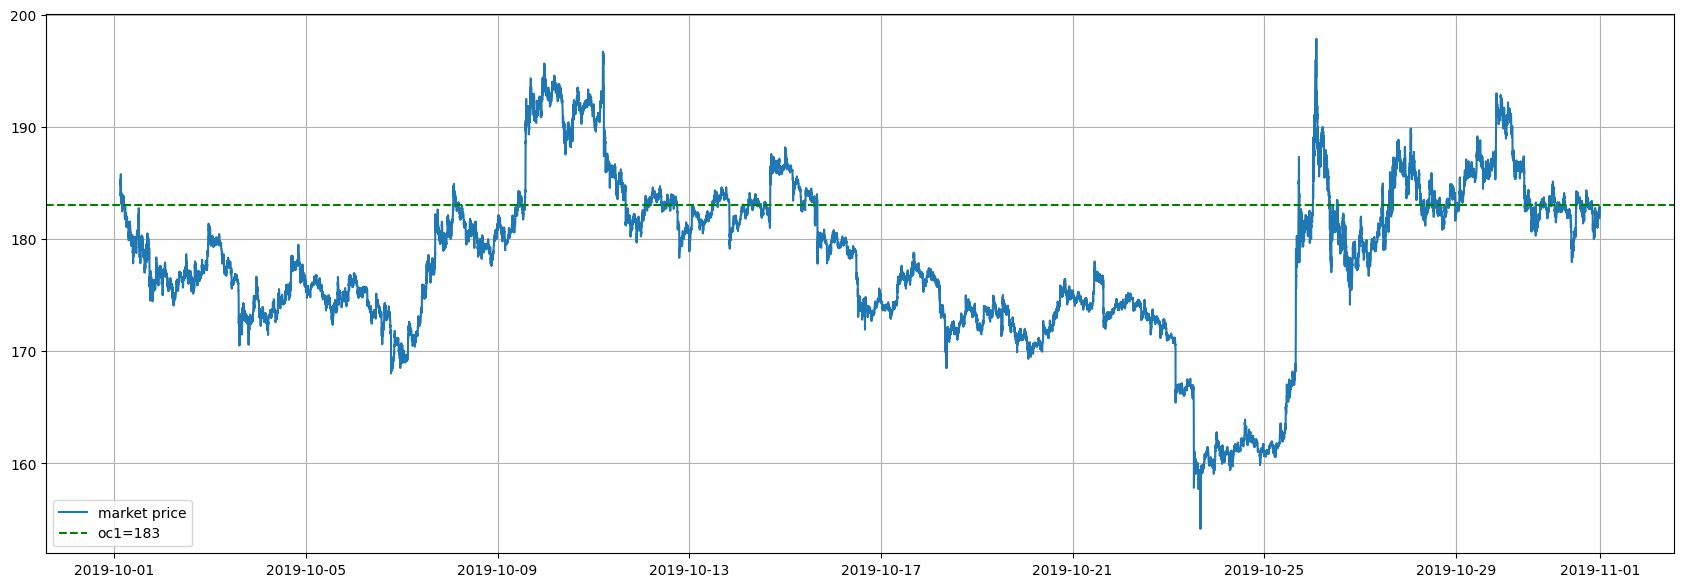

##################################



In [35]:
for i in range(len(months_eth)):
    periods_n_open_close = months_eth[i]
    name = names_eth[i]
    period = periods_n_open_close[0]
    p = periods_n_open_close[1]
    data_set = eth_historical.loc[period[0]:period[1]]
    crosses = cross_counter(data_set, p)
    oc_width = 0.025
    print("Period", name)
    print("The price "+str(p)+" was crossed "+str(crosses['down']['crossed_down'] + crosses['up']['crossed_up'])+" times.")
    print("The period looks like this...")
    plot_period(data_set, periods_n_open_close, slippage, oc_width, ema_days)
    print("##################################\n")
    # plt.savefig(name+'_test.png')

### EMA Slope Analysis

In [23]:
i_th_month = 2
data = eth_historical['close'].loc[months_eth[i_th_month][0][0]:months_eth[i_th_month][0][1]]
# data = btc_historical['close'].loc[months_btc[i_th_month][0][0]:months_btc[i_th_month][0][1]]
ema_7 = data.ewm(span=7*24*60).mean()
ema_5 = data.ewm(span=5*24*60).mean()
ema_3 = data.ewm(span=3*24*60).mean()
ema_1 = data.ewm(span=1*24*60).mean()
ema_0_25 = data.ewm(span=12*60).mean()
ema = ema_7
ema_2 = ema.ewm(span=7*24*60).mean()
ema_3 = ema_2.ewm(span=7*24*60).mean()
dema = 2*ema - ema_2
tema = 3*ema - 3*ema_2 + ema_3
tema_0_25 = 3*ema_0_25 - 3*ema_0_25.ewm(span=6*60).mean() + ema_0_25.ewm(span=6*60).mean().ewm(span=6*60).mean()
fast_slope = ema.pct_change().dropna()
slope_period = 1*12*60
ema_slow_slope = ema.pct_change(slope_period).dropna()
dema_slow_slope = dema.pct_change(slope_period).dropna()
tema_slow_slope = tema.pct_change(slope_period).dropna()
slow_slope_slope = ema_slow_slope.pct_change().dropna()
n_slope_fast = 1*60
n_slope_slow = 12*60
slope_as_derivative_fast = (ema-ema.shift(n_slope_fast))/(n_slope_fast)
slope_as_derivative_slow = (ema-ema.shift(n_slope_slow))/(n_slope_slow)
# slp_slp_slow = slp_slow.pct_change().dropna()
fast_ema_of_slope = fast_slope.ewm(span=0.5*24*60).mean()
slow_ema_of_slope = fast_slope.ewm(span=1*24*60).mean()
###########################
# zero ema
lag_7 = int(((7*24*60 + 1) - 1)/2) #+1 in order to end up with an odd lag when substracting 1 and dividing by 2 in lag definition
lag_5 = int(((5*24*60 + 1) - 1)/2)
lag_3 = int(((3*24*60 + 1) - 1)/2)
longer_period_for_zero_ema = datetime.fromisoformat(months_eth[i_th_month][0][0]) - timedelta(minutes=lag_7)
data_for_zero_ema = eth_historical['close'].loc[longer_period_for_zero_ema:months_eth[i_th_month][0][1]]
delagged_data_7 = data + (data-data.shift(lag_7))
delagged_data_7_with_longer_data = data_for_zero_ema + (data_for_zero_ema-data_for_zero_ema.shift(lag_7))
delagged_data_5 = data + (data-data.shift(lag_5))
delagged_data_5_with_longer_data = data_for_zero_ema + (data_for_zero_ema-data_for_zero_ema.shift(lag_5))
delagged_data_3 = data + (data-data.shift(lag_3))
delagged_data_3_with_longer_data = data_for_zero_ema + (data_for_zero_ema-data_for_zero_ema.shift(lag_3))
zero_ema_7 = delagged_data_7.ewm(span=7*24*60+1).mean()
zero_ema_7_with_longer_data = delagged_data_7_with_longer_data.ewm(span=7*24*60+1).mean()
zero_ema_5 = delagged_data_5.ewm(span=5*24*60+1).mean()
zero_ema_5_with_longer_data = delagged_data_5_with_longer_data.ewm(span=5*24*60+1).mean()
zero_ema_3 = delagged_data_3.ewm(span=3*24*60+1).mean()
zero_ema_3_with_longer_data = delagged_data_3_with_longer_data.ewm(span=3*24*60+1).mean()
zero_ema_1_with_longer_data = delagged_data_3_with_longer_data.ewm(span=1*24*60+1).mean()
############################
# our ema
ema_sum = 2/3*zero_ema_1_with_longer_data + ema * 1/3
ema_sum = ema_sum.dropna()[-len(ema):]
mix_ema = pd.DataFrame([i if i<j else j for i,j in zip(ema_sum, ema)], index=ema.index)#indicator(zero_ema_1_with_longer_data.dropna()[-len(ema):][i], ema[i]) for i in range(len(ema))]
###########################
# KAMA
changes_period = 24 * 60
change = abs(data-data.shift(changes_period)).dropna()
# Volatility sum
vol_sum = sum(abs(data-data.shift()).dropna())
# ER ratio
ER = change / vol_sum
# Smoothing constant
fast_period_faster = 30
fastest_sc_faster = 2/(fast_period_faster+1)
slow_period_faster = 50
slowest_sc_faster = 2/(slow_period_faster+1)
SC_faster = (ER * (fastest_sc_faster - slowest_sc_faster) + slowest_sc_faster)**2

fast_period_slower = 10
fastest_sc_slower = 2/(fast_period_slower+1)
slow_period_slower = 100
slowest_sc_slower = 2/(slow_period_slower+1)
SC_slower = (ER * (fastest_sc_slower - slowest_sc_slower) + slowest_sc_slower)**2
# KAMA
kama_faster = data[changes_period:].copy()
for i in range(1,len(kama_faster)):
    kama_faster[i] = kama_faster[i-1] + SC_faster[i] * (data[i+changes_period]-kama_faster[i-1])
kama_slower = data[changes_period:].copy()
for i in range(1,len(kama_slower)):
    kama_slower[i] = kama_slower[i-1] + SC_slower[i] * (data[i+changes_period]-kama_slower[i-1])

In [64]:
lowest_slope = 3e-04
index_of_lowest_slope = list(slow_slope.lsloweroc[(slow_slope<lowest_slope) & (slow_slope>-lowest_slope)].index)
print("Pcg of ema slope between +-lowest_slope: " + str(round(sum((slow_slope<lowest_slope) & (slow_slope>-lowest_slope)) / len(slow_slope) * 100,3))+"%")

Pcg of ema slope between +-lowest_slope: 6.952%


(array([ 410.,  494.,  359.,  393.,  649.,  409.,  822.,  759.,  994.,
         396.,  119.,  237., 1031., 1130., 1596., 1288., 2395., 4121.,
        5963., 6450., 3878., 3670., 3086., 1201.,  511.]),
 array([-2.09399267e-02, -1.99414916e-02, -1.89430565e-02, -1.79446214e-02,
        -1.69461862e-02, -1.59477511e-02, -1.49493160e-02, -1.39508809e-02,
        -1.29524458e-02, -1.19540106e-02, -1.09555755e-02, -9.95714041e-03,
        -8.95870529e-03, -7.96027017e-03, -6.96183505e-03, -5.96339994e-03,
        -4.96496482e-03, -3.96652970e-03, -2.96809458e-03, -1.96965946e-03,
        -9.71224345e-04,  2.72107729e-05,  1.02564589e-03,  2.02408101e-03,
         3.02251613e-03,  4.02095125e-03]),
 <BarContainer object of 25 artists>)

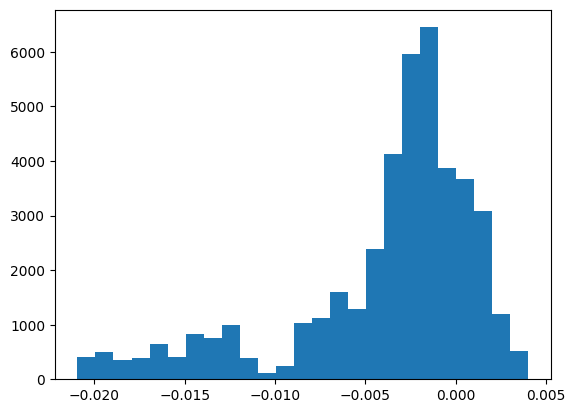

In [65]:
plt.hist(slow_slope, bins=25)#.loc['2019-10-13 00:00:00':'2019-10-14 00:00:00']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


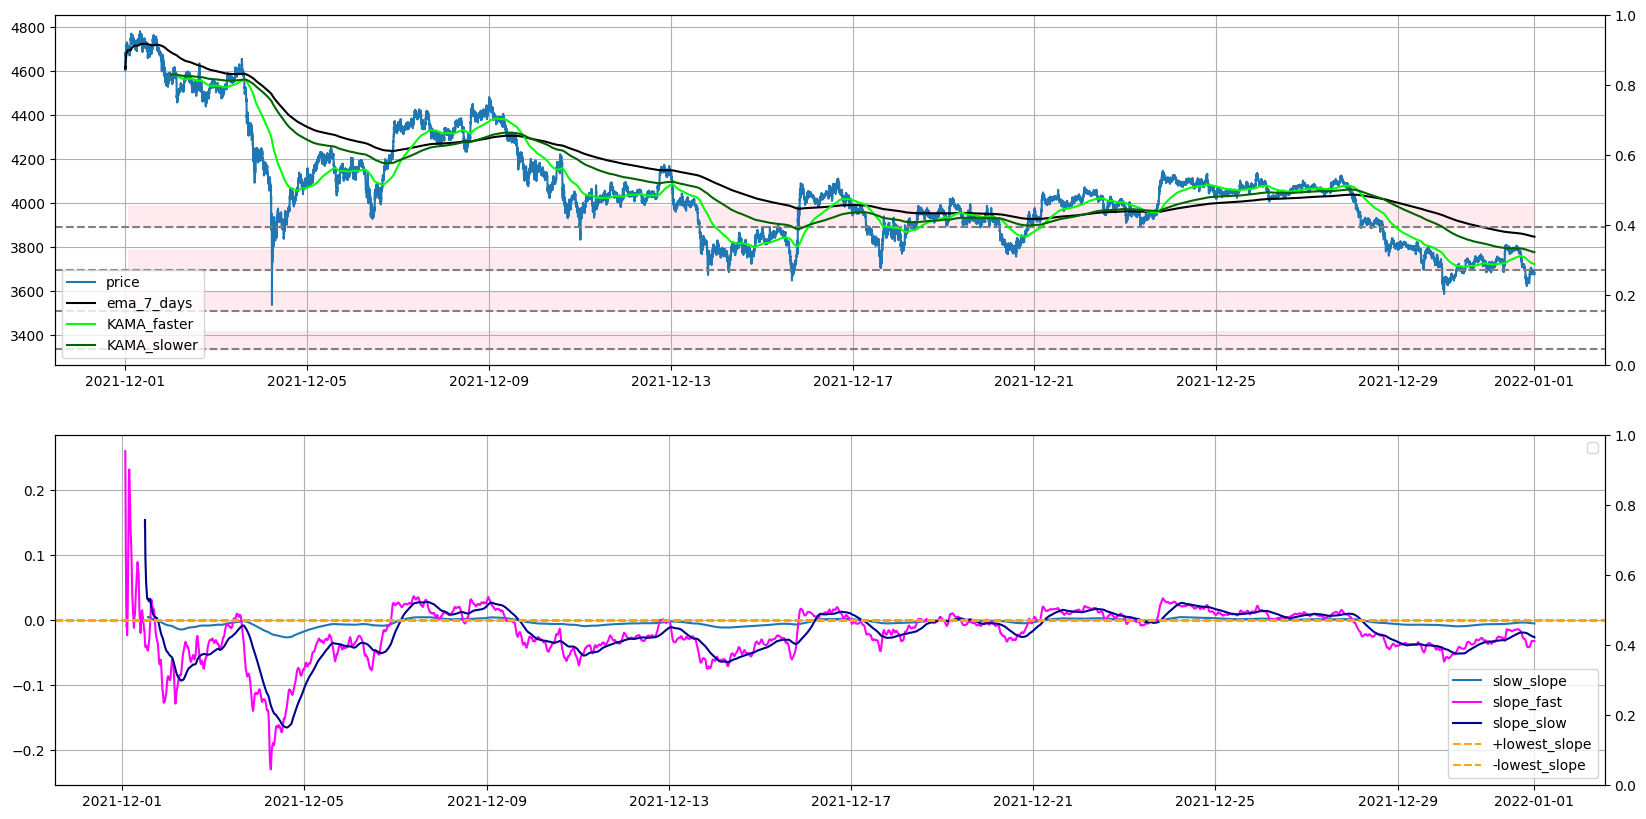

In [25]:
open_close = months_eth[i_th_month][1]
# open_close = months_btc[i_th_month][1]
pcg_below = 0.05
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(data, 
         color='tab:blue', label='price')
axs[0].plot(ema, 
         color='black', label='ema_7_days')
# axs[0].plot(ema_0_25, 
#          color='red', label='ema_6_hours')
# axs[0].plot(tema_0_25, 
#          color='black', label='tema_6_hours')
# axs[0].plot(ema*(1+slow_slope), 
#          color='brown', label='ema_7_days_plus_slope')
# axs[0].plot(ema*(1+slow_slope+1/2*slow_slope_slope), 
#          color='magenta', label='ema_7_days')
axs_0=axs[0].twinx()
###################
# 2) Zero lag ema
# axs[0].plot(zero_ema_7, 
#          color='brown', label='zero_ema_7')
# axs[0].plot(zero_ema_7_with_longer_data, 
#          color='magenta', label='zero_ema_7_with_longer_data')
# # axs[0].plot(zero_ema_5, 
# #          color='brown', label='zero_ema')
# axs[0].plot(zero_ema_5_with_longer_data, 
#          color='red', label='zero_ema_with_longer_data')
# axs[0].plot(zero_ema_3, 
#          color='brown', label='zero_ema')
# axs[0].plot(zero_ema_3_with_longer_data, 
#          color='pink', label='zero_ema_with_longer_data')
# axs[0].plot(zero_ema_1_with_longer_data, 
#          color='pink', label='zero_ema_with_longer_data')
###################
# 3) ema.shift()
# axs[0].plot(ema.shift(-2*24*60), 
#          color='pink', label='ema_shifted')
# 4) our ema
# axs[0].plot(1/2*zero_ema_3_with_longer_data + ema * 1/2, 
#          color='magenta', label='1/2*zero_ema_3_with_longer_data + ema * 1/2')
# axs[0].plot(1/3*data + ema * 2/3, 
#          color='red', label='1/3*data + ema * 2/3')
# axs[0].plot(mix_ema, 
#          color='green', label='mix_ema')
for i in range(4):
        axs[0].axhline(y=open_close*(1-pcg_below)**i, 
                color='grey', 
                linestyle='--')
                # label='pcg_below_'+str(i)+"="+str(round(open_close*(1-pcg_below)**i,3)))
        axs[0].fill_between(data[100:].index, 
                         open_close*(1-pcg_below)**i,
                         open_close*(1-pcg_below)**i*(1+pcg_below/2),
                         color='pink', alpha=0.3)#,hatch="X",edgecolor="b")
#####################
# 5) KAMA
axs[0].plot(kama_faster, 
         color='lime', label='KAMA_faster')
axs[0].plot(kama_slower, 
         color='darkgreen', label='KAMA_slower')
#####################
# 6) DEMA, TEMA
# axs[0].plot(dema, 
         # color='orange', label='dema')
# axs[0].plot(tema, 
#          color='brown', label='tema')
#####################
# 7) DEMA, TEMA + SLOPE
# axs[0].plot(dema, 
#          color='orange', label='dema')
# axs[0].plot(ema*(1+ema_slow_slope), 
#          color='orange', label='dema+slope')
axs[0].legend(loc='lower left')
axs[0].grid()
###
# 1) Slope as derivative
axs[1].plot(ema_slow_slope[100:], label='slow_slope')
axs[1].plot(slope_as_derivative_fast[100:], 
         color='magenta', label='slope_fast')
axs[1].plot(slope_as_derivative_slow[100:], 
         color='darkblue', label='slope_slow')
# axs[1].plot(slp_slp_slow[100:], label='slope_fast', color='orange')
# axs[1].set_ylim(-5,5)
axs_=axs[1].twinx()
# axs_.plot(fast_ema_of_slope[100:], label='fast_ema_of_slope', color='green')
# axs_.plot(slow_ema_of_slope[100:], label='slow_ema_of_slope', color='red')
axs[1].axhline(y=1e-03,
            color='orange', 
            linestyle='--', 
            label='+lowest_slope')
axs[1].axhline(y=-1e-03,
            color='orange', 
            linestyle='--', 
            label='-lowest_slope')
# for i in range(len(index_of_lowest_slope)):
#     axs[0].axvline(x=index_of_lowest_slope[i],
#                 color='orange', 
#                 linestyle='--', 
#                 label='+lowest_slope')
#     axs[1].axvline(x=index_of_lowest_slope[i],
#                 color='orange', 
#                 linestyle='--', 
#                 label='+lowest_slope')
axs_.legend(loc='upper right')
axs[1].legend(loc='lower right')
axs[1].grid()

### Simulation Results

In [206]:
from joblib import Parallel, delayed
import time
from datetime import timedelta
starttime = time.time()
# print('starttime:', starttime)

parallel_pool = Parallel(n_jobs=len(months_eth))
delayed_function = [delayed(run)(data=eth_historical, stk=stk, slippage=slippage, 
                                 pcgs_below=pcgs_below, ema_days=ema_days,
                                 period_name=name, periods_n_open_close=month, 
                                 # run_sim_func = run_sim_EMA_PLUS_SLOPE,
                                 # run_sim_func = run_sim_DEMA,
                                 # run_sim_func = run_sim_TEMA,
                                 # run_sim_func = run_sim_DEMA_SLOPE,
                                 # run_sim_func = run_sim_TEMA_SLOPE,
                                 # run_sim_func = run_sim_REPORT,
                                 # run_sim_func = run_sim_FIRST_APPROACH,
                                 # run_sim_func = run_sim_DEMA_0_5,
                                 # run_sim_func = run_sim_TEMA_0_5,
                                 run_sim_func = run_sim_KAMA,
                                 case = 'with_pcg_below') for name,month in zip(three_months_eth_names, three_months_eth)]
all_results = parallel_pool(delayed_function)
endtime = time.time()
# print('endtime:', endtime)
# print(str(timedelta(seconds=endtime - starttime)))

In [207]:
for period_name in three_months_eth_names:
    path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
    f = open(path_to_results, 'r')
    file_contents = f.read()
    print(file_contents)
    f.close()

Simulation for period  worst_3_months_eth[0]
User expectation: -8461.26 ---> -0.85%
Generated PnL: -78288.89 ---> -7.83%
Difference:  -6.98%
############################################### 


Simulation for period  worst_3_months_eth[1]
User expectation: 200475.58 ---> 20.05%
Generated PnL: -54046.41 ---> -5.4%
Difference:  -25.45%
############################################### 




In [58]:
# all_results[0].sort_values(by=['final_result_pcg'], ascending = False)
# for results_df, results_report in zip(all_results, all_results_REPORT):
#     trigger_oc_results = results_df.sort_values(by=['final_result_pcg'], ascending = False)['final_result_pcg']
#     report_results = results_report.sort_values(by=['final_result_pcg'], ascending = False)['final_result_pcg']
#     comparison = pd.DataFrame([trigger_oc_results, report_results]).T
#     comparison.columns = ['trigger_oc', 'report']
#     print(comparison)

   trigger_oc  report
0      -6.547  -6.547
2      -6.547  -6.547
1      -6.605  -6.605
3      -6.605  -6.605
   trigger_oc  report
3      -1.159  -1.159
2      -2.001  -2.001
1      -5.847  -5.847
0     -11.026 -11.026
   trigger_oc  report
2      -0.781  -0.781
1      -3.609  -3.609
3      -3.609  -3.609
0      -9.618  -9.618
   trigger_oc  report
3      -3.457  -3.457
2      -3.672  -3.672
1      -5.978  -5.978
0      -6.725  -6.725
   trigger_oc  report
3      -1.059  -1.059
2      -5.368  -5.368
0      -9.593  -9.593
1     -11.148 -11.148
   oc_width  pcg_below  EMA_days  taker_fees_counter  final_result_pcg
0   0.00001      0.005       3.0                 1.0            -6.547
1   0.00001      0.005       7.0                 1.0            -6.605
2   0.00001      0.050       3.0                 1.0            -6.547
3   0.00001      0.050       7.0                 1.0            -6.605
   oc_width  pcg_below  EMA_days  taker_fees_counter  final_result_pcg
0    0.0025      0.005  

In [45]:
# from joblib import Parallel, delayed
# import time
# from datetime import timedelta
# starttime = time.time()
# print('starttime:', starttime)

# parallel_pool = Parallel(n_jobs=len(months_eth))
# delayed_function = [delayed(run)(data=eth_historical, stk=stk, slippage=slippage, 
#                                  pcgs_below=pcgs_below, ema_days=ema_days,
#                                  period_name=name, periods_n_open_close=month, run_sim_func = run_sim_FIRST_APPROACH,
#                                               case = 'with_pcg_below') for name,month in zip(names_eth, months_eth)]
# all_results_FIRST_APPROACH = parallel_pool(delayed_function)
# endtime = time.time()
# print('endtime:', endtime)
# print(str(timedelta(seconds=endtime - starttime)))

In [46]:
# for period_name in names_eth:
#     path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
#     f = open(path_to_results, 'r')
#     file_contents = f.read()
#     print(file_contents)
#     f.close()

## BTC

In [159]:
# Period of Simulations
best_1_month_btc = [["2022-05-01 00:00:00","2022-06-01 00:00:00"],37500]
normal_1_month_btc = [[["2019-09-03 13:00:00","2019-10-03 13:00:00"],10500],
                  [["2020-09-01 00:00:00","2020-10-01 00:00:00"],10500],
                  [["2022-08-08 12:00:00","2022-09-08 12:00:00"],23750]]
worst_1_month_btc = [["2021-11-01 00:00:00","2021-12-01 00:00:00"], 61000]
# worst_1_month_btc = [[["2020-05-03 00:00:00","2020-06-03 00:00:00"],8900],
#                  [["2020-05-07 20:00:00","2020-06-07 20:00:00"],9550],
#                  [["2021-11-01 00:00:00","2021-12-01 00:00:00"], 61000],
#                  [["2021-11-01 00:00:00","2021-12-01 00:00:00"], 57000]]

In [160]:
# Period of Simulations
names_btc = [
    "best_1_month_btc",
    "normal_1_month_btc[0]",
    "normal_1_month_btc[1]",
    "normal_1_month_btc[2]",
    "worst_1_month_btc"
]
months_btc = [
    best_1_month_btc,
    normal_1_month_btc[0], 
    normal_1_month_btc[1], 
    normal_1_month_btc[2], 
    worst_1_month_btc
]

### Plots

169


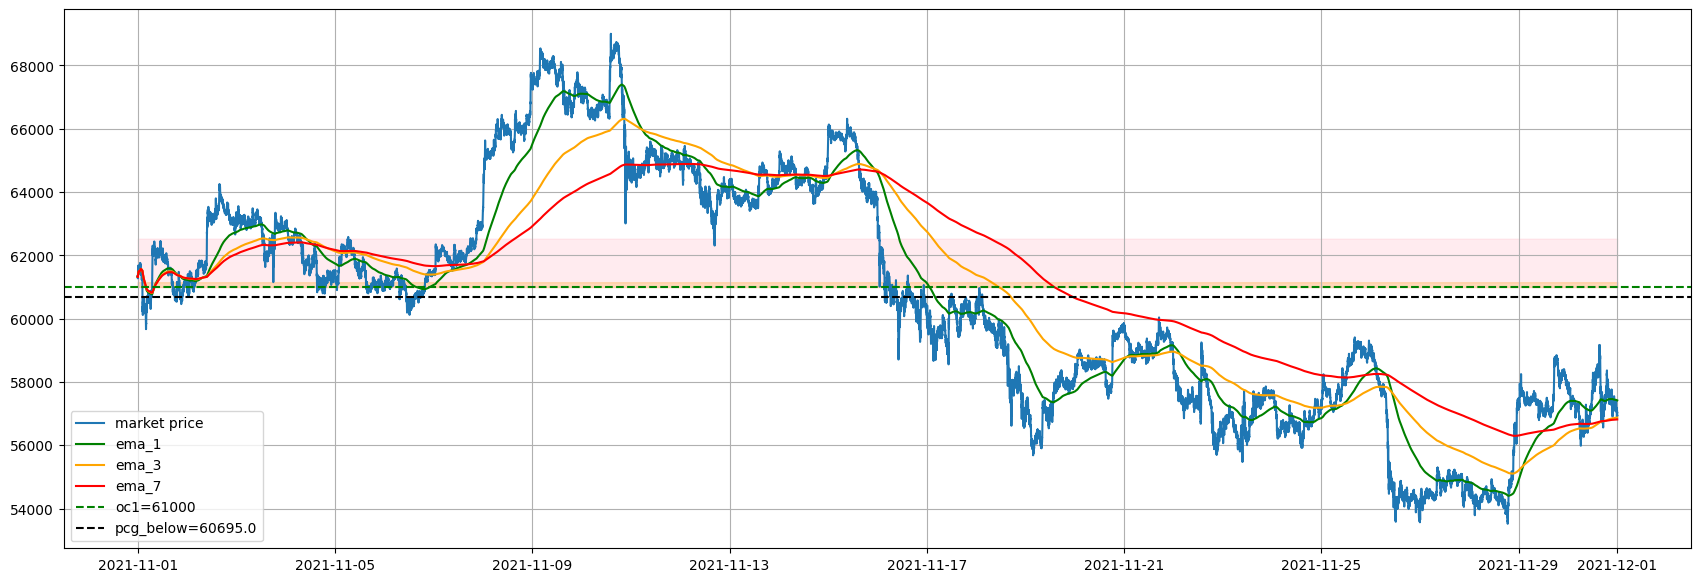

In [33]:
periods_n_open_close = months_btc[4]
period = periods_n_open_close[0]
data = btc_historical.loc[period[0]:period[1]]
fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.plot(data, color='tab:blue', label='market price')
axs.plot(data['close'].ewm(span=1*1*24*60).mean(), label='ema_1', color='green')
axs.plot(data['close'].ewm(span=1*3*24*60).mean(), label='ema_3', color='orange')
axs.plot(data['close'].ewm(span=1*7*24*60).mean(), label='ema_7', color='red')
open_close = periods_n_open_close[1]
pcg_below = 0.005
axs.axhline(y=open_close, 
            color='green', 
            linestyle='--', 
            label='oc1='+str(round(open_close,3)))
axs.axhline(y=open_close*(1-pcg_below), 
            color='black', 
            linestyle='--', 
            label='pcg_below='+str(round(open_close*(1-pcg_below),3)))
# plt.fill_between(data['close'].index, open_close,open_close*(1+0.0001),color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
plt.fill_between(data['close'].index, open_close,open_close*(1+0.0025),color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
plt.fill_between(data['close'].index, open_close,open_close*(1+0.025),color='pink', alpha=0.3)#,hatch="X",edgecolor="b")
axs.grid()
axs.legend(loc='lower left')
crosses = cross_counter(data, open_close)
print(crosses['down']['crossed_down'] + crosses['up']['crossed_up'])
plt.show()
# plt.savefig('Files/foo.png')

In [60]:
data['close'][-1]

56922.34

Period best_1_month_btc
The price 37500 was crossed 1 times.
The period looks like this...


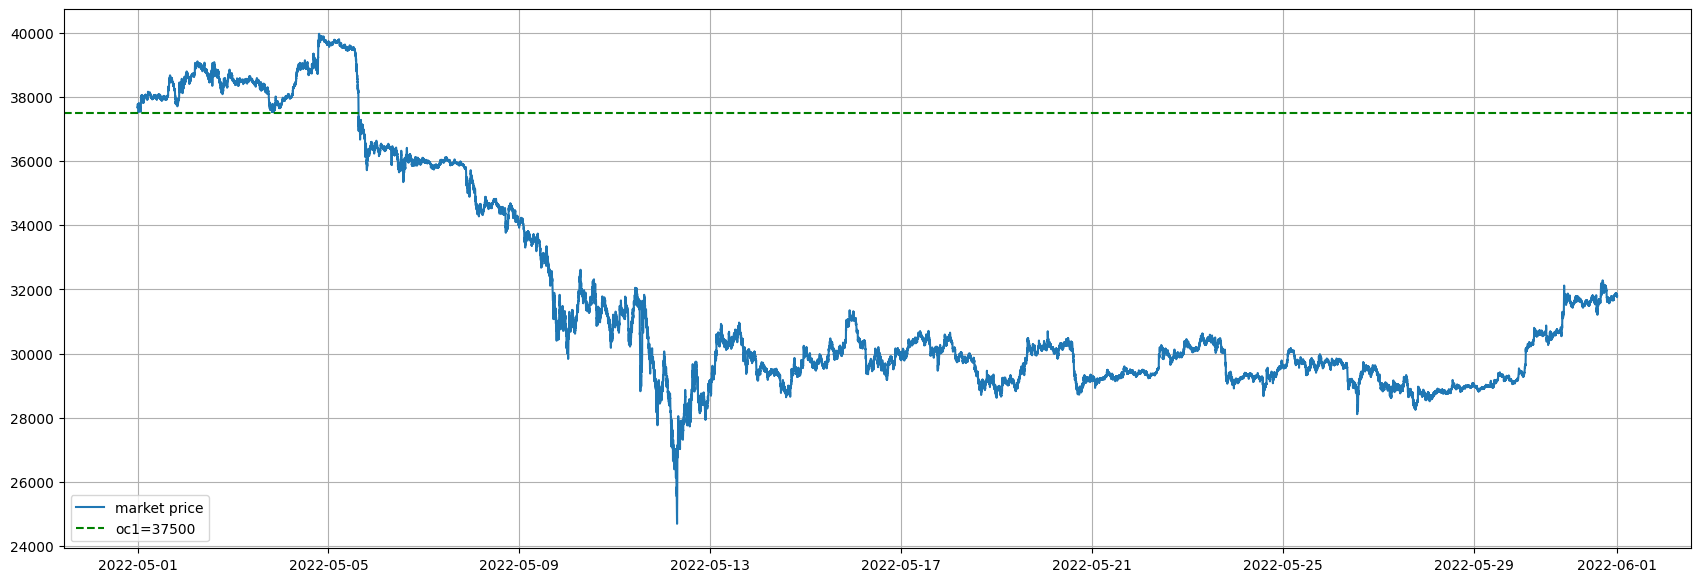

##################################

Period normal_1_month_btc[0]
The price 10500 was crossed 97 times.
The period looks like this...


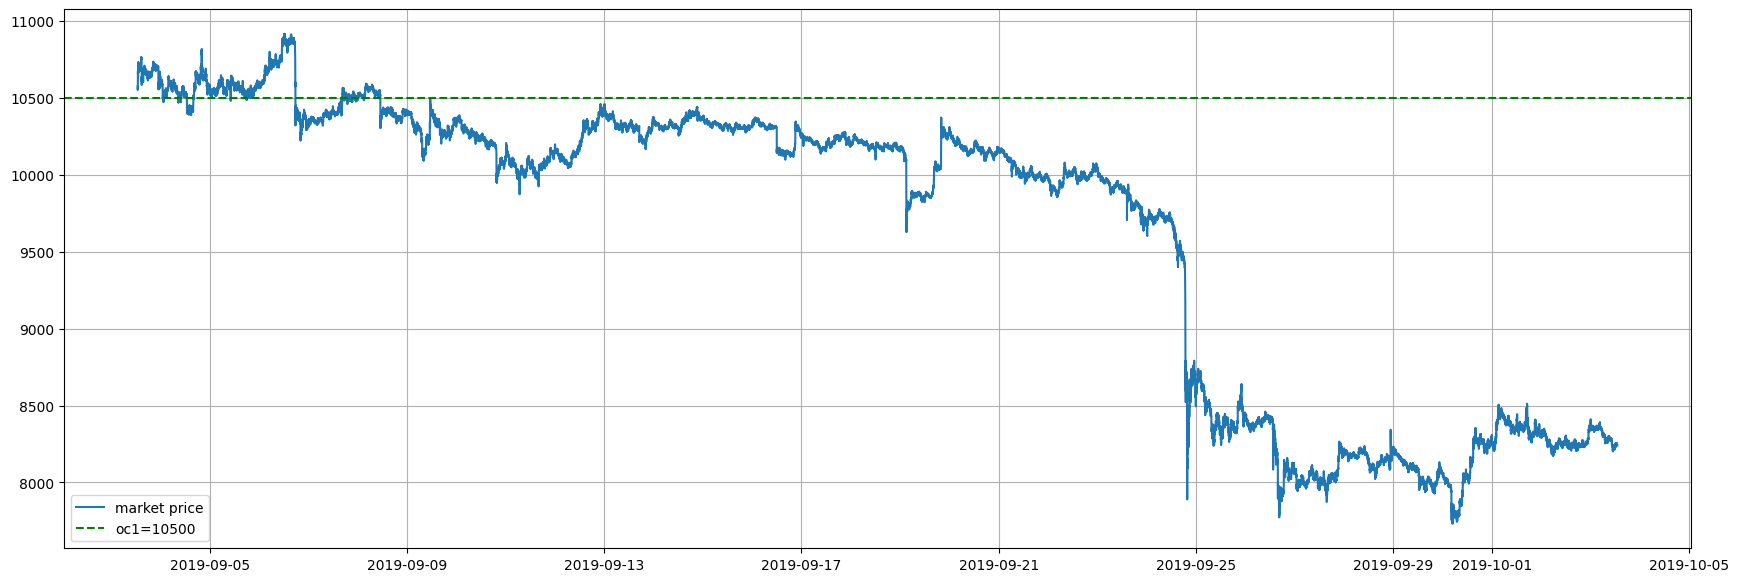

##################################

Period normal_1_month_btc[1]
The price 10500 was crossed 142 times.
The period looks like this...


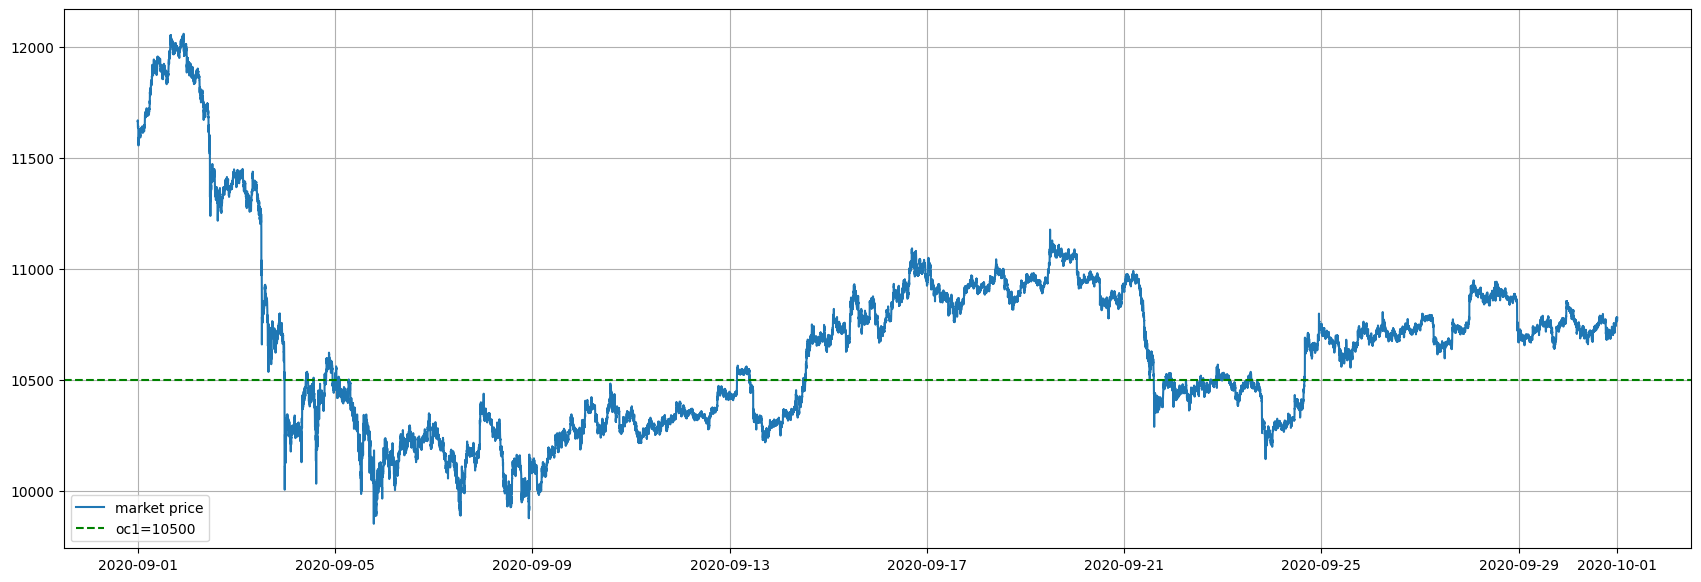

##################################

Period normal_1_month_btc[2]
The price 23750 was crossed 71 times.
The period looks like this...


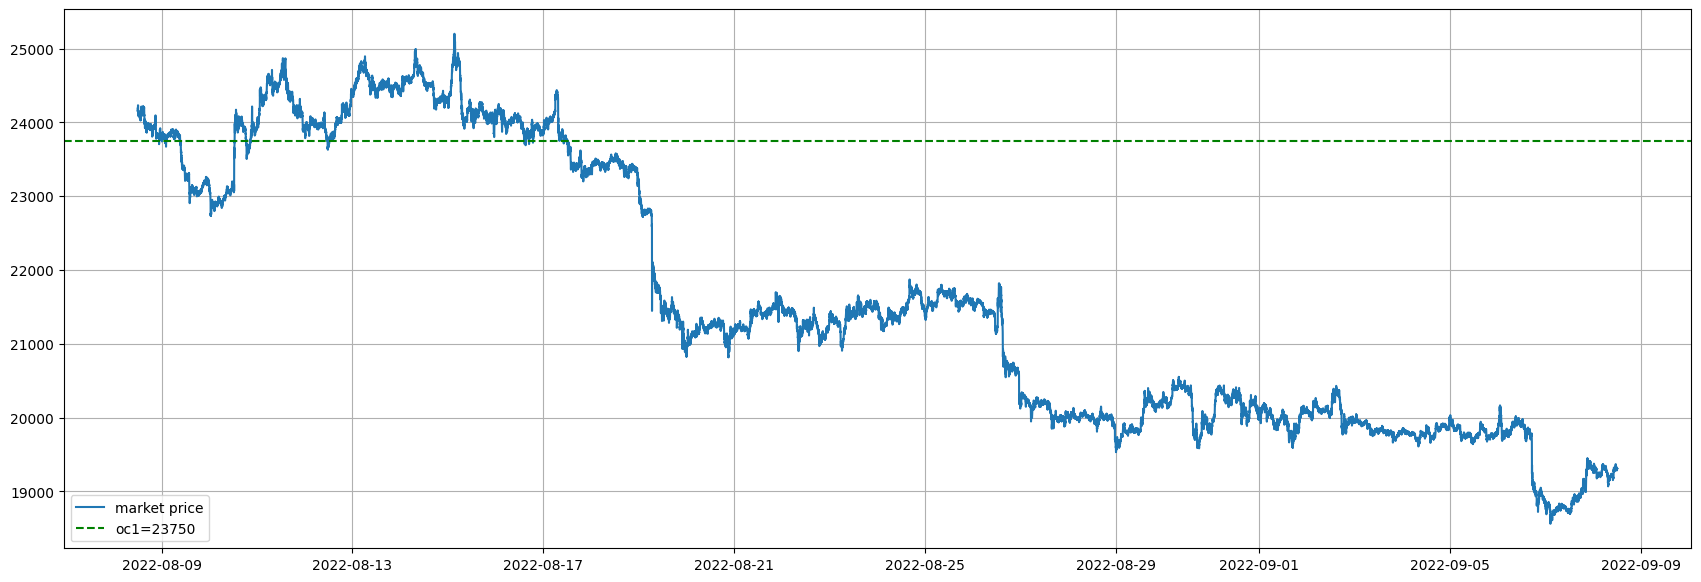

##################################

Period worst_1_month_btc
The price 61000 was crossed 169 times.
The period looks like this...


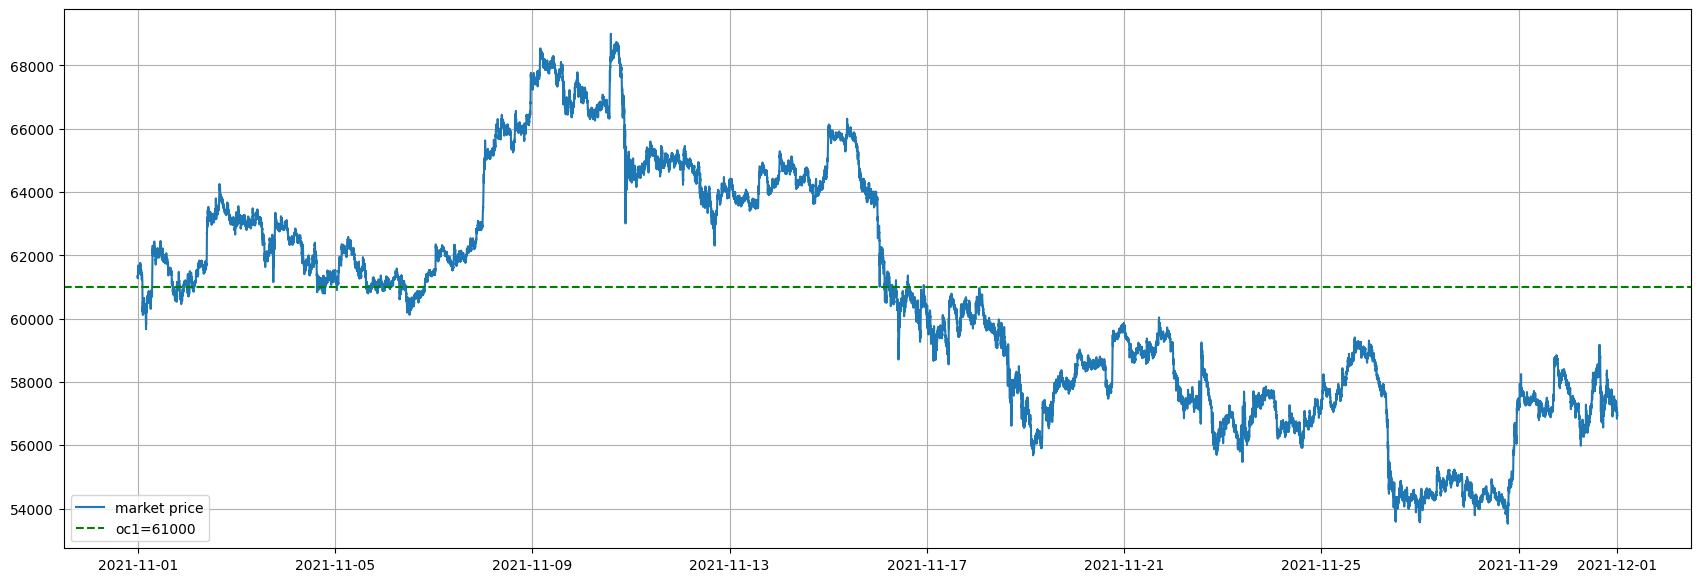

##################################



In [42]:
for i in range(len(months_btc)):
    periods_n_open_close = months_btc[i]
    name = names_btc[i]
    period = periods_n_open_close[0]
    p = periods_n_open_close[1]
    data_set = btc_historical.loc[period[0]:period[1]]
    crosses = cross_counter(data_set, p)
    oc_width = 0.025
    print("Period", name)
    print("The price "+str(p)+" was crossed "+str(crosses['down']['crossed_down'] + crosses['up']['crossed_up'])+" times.")
    print("The period looks like this...")
    plot_period(data_set, periods_n_open_close, slippage, oc_width, ema_days)
    print("##################################\n")
    # plt.savefig(name+'_test.png')

### Simulation Results

In [184]:
from joblib import Parallel, delayed
import time
from datetime import timedelta
starttime = time.time()
# print('starttime:', starttime)

parallel_pool = Parallel(n_jobs=len(months_btc))
# parallel_pool = Parallel(n_jobs=1)
delayed_function = [delayed(run)(data=btc_historical, stk=stk, slippage=slippage, 
                                 pcgs_below=pcgs_below, ema_days=ema_days,
                                 period_name=name, periods_n_open_close=month, 
                                 # run_sim_func = run_sim_DEMA,
                                 # run_sim_func = run_sim_TEMA,
                                 # run_sim_func = run_sim_DEMA_SLOPE,
                                 # run_sim_func = run_sim_TEMA_SLOPE,
                                 # run_sim_func = run_sim_TEMA_0_5,
                                 # run_sim_func = run_sim_REPORT,
                                 run_sim_func = run_sim_EMA_PLUS_SLOPE,
                                 # run_sim_func = run_sim_FIRST_APPROACH,
                                case = 'with_pcg_below') for name,month in zip(names_btc, months_btc)]
all_results = parallel_pool(delayed_function)

endtime = time.time()
# print('endtime:', endtime)
# print(str(timedelta(seconds=endtime - starttime)))

In [185]:
for period_name in names_btc:
    path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
    f = open(path_to_results, 'r')
    file_contents = f.read()
    print(file_contents)
    f.close()

Simulation for period  best_1_month_btc
User expectation: 147316.98 ---> 14.73%
Generated PnL: 7639.51 ---> 0.76%
Difference:  -13.97%
############################################### 


Simulation for period  normal_1_month_btc[0]
User expectation: 211423.31 ---> 21.14%
Generated PnL: 103914.53 ---> 10.39%
Difference:  -10.75%
############################################### 


Simulation for period  normal_1_month_btc[1]
User expectation: -24297.47 ---> -2.43%
Generated PnL: 8804.56 ---> 0.88%
Difference:  3.31%
############################################### 


Simulation for period  normal_1_month_btc[2]
User expectation: 179082.48 ---> 17.91%
Generated PnL: 137234.89 ---> 13.72%
Difference:  -4.18%
############################################### 


Simulation for period  worst_1_month_btc
User expectation: 65384.9 ---> 6.54%
Generated PnL: -8560.58 ---> -0.86%
Difference:  -7.39%
############################################### 


Short position should be open for this first price!
S

In [102]:
# # from joblib import Parallel, delayed
# # import time
# # from datetime import timedelta
# # starttime = time.time()
# # print('starttime:', starttime)

# parallel_pool = Parallel(n_jobs=len(months_eth))
# delayed_function = [delayed(run)(data=btc_historical, stk=stk, slippage=slippage, 
#                                  pcgs_below=pcgs_below, ema_days=ema_days,
#                                  period_name=name, periods_n_open_close=month, run_sim_func = run_sim_REPORT,
#                                               case = 'with_pcg_below') for name,month in zip(names_btc, months_btc)]
# all_results_FIRST_APPROACH = parallel_pool(delayed_function)
# # endtime = time.time()
# # print('endtime:', endtime)
# # print(str(timedelta(seconds=endtime - starttime)))

In [103]:
# for period_name in names_btc:
#     path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
#     f = open(path_to_results, 'r')
#     file_contents = f.read()
#     print(file_contents)
#     f.close()

## Montecarlo

In [35]:
def simulated_data(P, start_date, end_date, pred_end_date,
              dt, scen_size):
    '''
    P has to be a df with columns: 'close', 'Returns'
    granularity of data should be less or equal to dt [Ex: data in 5 minutes span and dt = 10*60 (10minutes)]
    dt has to be expressed in seconds in order to contemplate differents time scales [seconds, minutes, hours, days, etc]
    'Returns' are the returns in the last dt units of time
    P.index has to be dates expressed in "%Y-%m-%d %H:%M:%S" form
    scen_size is the number of paths we want to generate
    '''
    # start_date = ETH.index[0].strftime("%Y-%m-%d %H:%M:%S")
    # end_date = ETH.index[len(ETH)-1].strftime("%Y-%m-%d %H:%M:%S")
    # pred_end_date = '2022-07-10 12:00:00'


    S_=P['close']
    S_['Date']=P.index

    # returns = P['Returns']
    returns = P['close'].pct_change().dropna()
    # print('Lista de retornos:', returns.tolist())

    # Parameter Assignments
    So = P['close'][len(P)-1]
    # dt = 5 # minutes   # User input

    # We calculate the number of seconds, n_of_seconds, between end_date and pred_end_date
    # one way
    start = pd.to_datetime(end_date, format = "%Y-%m-%d %H:%M:%S") #+ pd.Timedelta('5 minutes')
    end = pd.to_datetime(pred_end_date, format = "%Y-%m-%d %H:%M:%S")
    date_difference = end - start
    n_of_seconds = date_difference.total_seconds()

    # another way
    # n_of_minutes = len(pd.date_range(start, end, freq = 'min')[1:])

    T = n_of_seconds
    # number of dt jumps
    N = T / dt
    t = np.arange(1, int(N) + 1)

    # we calculate drift and std for our time scale
    mu = np.mean(returns)
    sigma = np.std(returns)

    # we generate scen_size paths
    # scen_size = 50 # User input
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma**2) * t
    # print('\n\n drift--->', drift)
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
    # print('\n\n difussion--->', diffusion)

    # Making the predictions
    # Usamos la solución explícita de la integral estocástica
    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
    # print('\n\n S---->', S)

    # Dataframe format for predictions - first 10 scenarios only
    Preds_df = pd.DataFrame(S.swapaxes(0, 1)).set_index(
            pd.date_range(start = S_['Date'].max(), 
                  end = pred_end_date, freq = str(dt)+'S')).reset_index(drop = False)
    return {'Predictions as list': S, # S is a list of list. Ex: S[0,:] is the first path, S[1,:] the second path, etc
          'Predictions as df': Preds_df}

def plot_simulated_data(predictions_as_list, P, 
                        end_date, pred_end_date,
                        dt, scen_size):
    plt.figure(figsize = (20,10))
    returns = P['close'].pct_change().dropna()
    sigma = np.std(returns)
    S = predictions_as_list
    for i in range(scen_size):
        plt.title(str(dt)+'S'+" Volatility: " + str(sigma))
        plt.plot(pd.date_range(start = end_date, 
                  end = pred_end_date, freq = str(dt)+'S'), S[i, :])
        plt.ylabel('Stock Prices, USD')
        plt.xlabel('Prediction '+str(dt)+'S')
    plt.show()


In [210]:
ith_month = 1
periods_n_open_close = three_months_eth[ith_month]
period = periods_n_open_close[0]
data = eth_historical.loc[period[0]:period[1]]
start_date = period[0]
end_date = period[1]
pred_end_date = pd.to_datetime(end_date, format = "%Y-%m-%d %H:%M:%S") + pd.Timedelta('90 days')
S = simulated_data(P = data , 
               start_date = start_date, 
               end_date = end_date,
               pred_end_date = pred_end_date,
              dt = 1*60, scen_size = 50)['Predictions as list']

/tmp/ipykernel_1694/2950526095.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S_['Date']=P.index


In [239]:
data

,close
timestamp,
2019-09-15 00:00:00,188.86
2019-09-15 00:01:00,188.90
2019-09-15 00:02:00,188.90
2019-09-15 00:03:00,189.36
2019-09-15 00:04:00,189.13
...,...
2019-12-14 23:56:00,141.89
2019-12-14 23:57:00,141.89
2019-12-14 23:58:00,141.89


In [215]:
data

,close
timestamp,
2019-09-15 00:00:00,188.86
2019-09-15 00:01:00,188.90
2019-09-15 00:02:00,188.90
2019-09-15 00:03:00,189.36
2019-09-15 00:04:00,189.13
...,...
2019-12-14 23:56:00,141.89
2019-12-14 23:57:00,141.89
2019-12-14 23:58:00,141.89


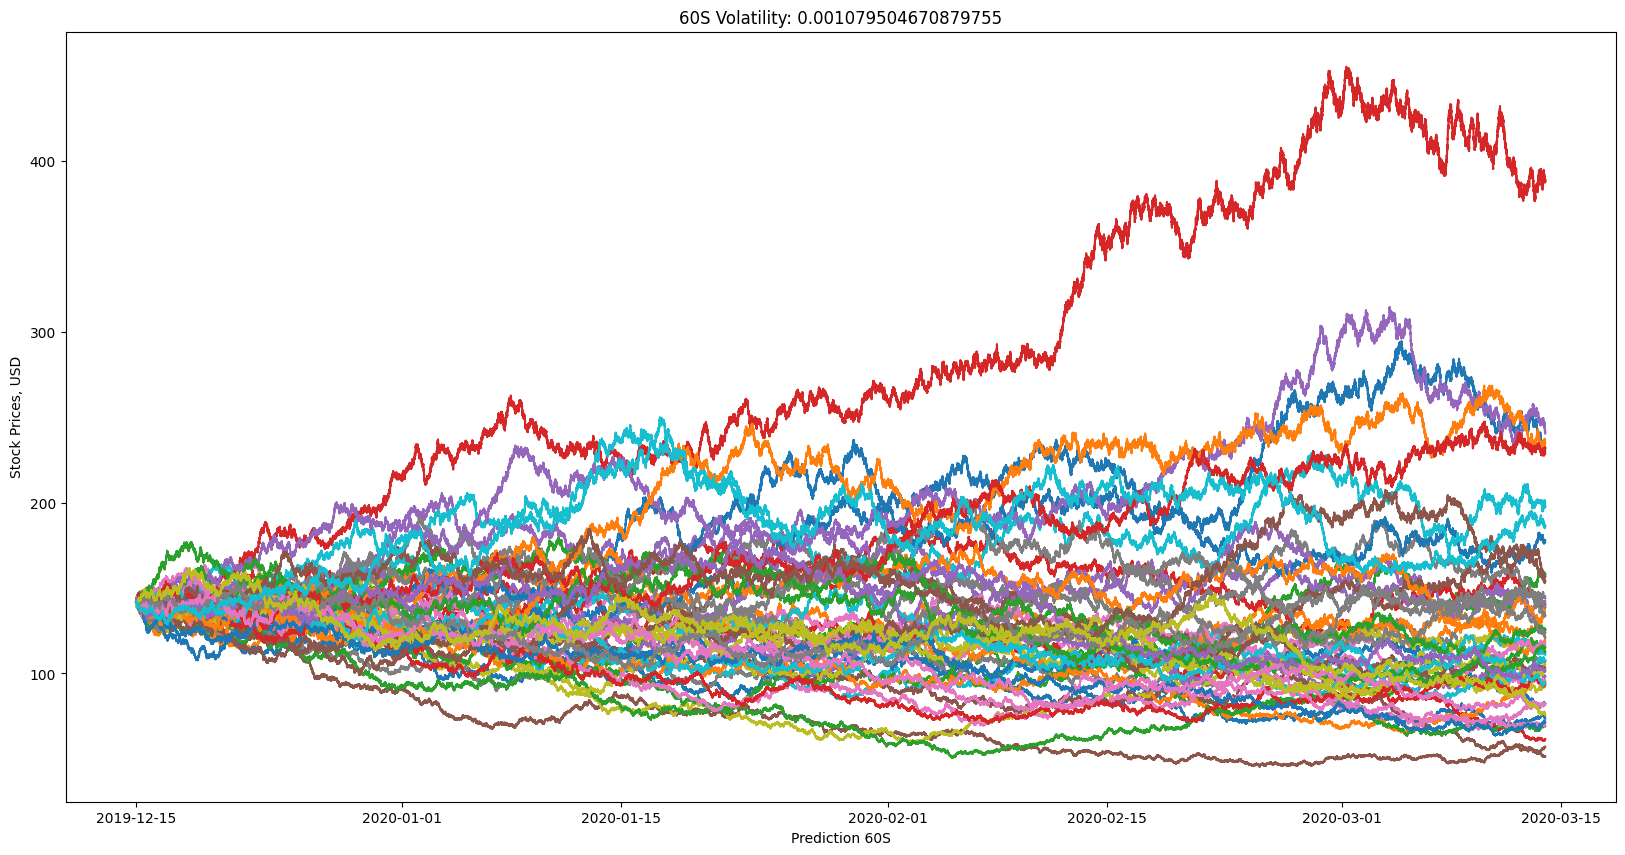

In [211]:
plot_simulated_data(predictions_as_list = S, 
                    P = data,
                    end_date = end_date,
                    pred_end_date = pred_end_date,
                    dt = 1*60, scen_size = 50)

In [63]:
# aux=pd.DataFrame(S).T.mean(axis=1)
ETH_pred=pd.DataFrame(S[1],columns=['close'])
ETH_pred.index=pd.date_range(start = data.index.max(), 
                end = pred_end_date, freq = '1min')
# ETH_pred=ETH_pred[['Date','Price']]

In [64]:
ETH_pred

,close
2022-01-01 00:00:00,3684.840000
2022-01-01 00:01:00,3687.623656
2022-01-01 00:02:00,3688.292627
2022-01-01 00:03:00,3693.429793
2022-01-01 00:04:00,3692.226290
...,...
2022-01-30 23:56:00,2551.924725
2022-01-30 23:57:00,2550.698007
2022-01-30 23:58:00,2552.164639
2022-01-30 23:59:00,2552.981453


Period Montecarlo path
The price 183 was crossed 109 times.
The period looks like this...


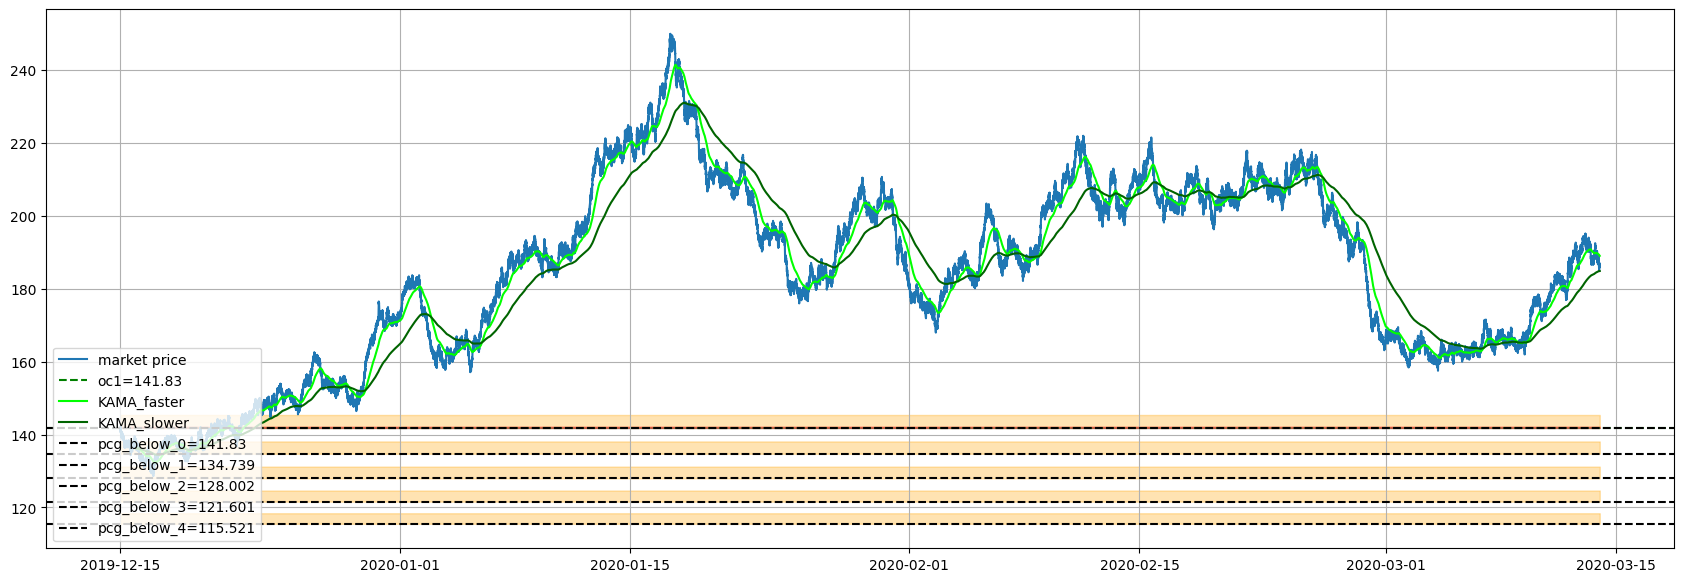

################################## 

Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position sho

In [240]:
name_pred = "Montecarlo path"
# period = periods_n_open_close[0]
p_pred = 141.83
periods_n_open_close_pred = [[str(ETH_pred.index[0]),str(ETH_pred.index[-1])], p_pred]
data_set = ETH_pred
crosses = cross_counter(ETH_pred, p_pred)
oc_width = 0.00001
pcg_below = 0.05
fraction = 1/2
print("Period", "Montecarlo path")
print("The price "+str(p)+" was crossed "+str(crosses['down']['crossed_down'] + crosses['up']['crossed_up'])+" times.")
print("The period looks like this...")
# plot_period(data_set, periods_n_open_close, slippage, oc_width, ema_days)
parameter_manager = ParameterManager()
last_date = period[1]
vol = parameter_manager.calc_vol(last_date, data_set)
mu, sigma = vol
open_close = p_pred
floor = open_close #/ ((1+slippage)*(1+mu+2*sigma))
fig, axs = plt.subplots(1, 1, figsize=(21, 7))
axs.plot(data_set['close'], color='tab:blue', label='market price')
axs.axhline(y=open_close, 
            color='green', 
            linestyle='--', 
            label='oc1='+str(round(open_close,3)))
# color=cm.rainbow(np.linspace(0,1,int(ema_days_test[-1]/(24*60))+2))
# for ema_day in ema_days_test[2:]:
#     axs.plot(data_set['close'].ewm(span=ema_day).mean(), 
#              label='ema_'+str(int(ema_day/(24*60))), 
#              color=color[int(ema_day/(24*60))+1])

# DEMA Double EMA
# axs.plot(2*data_set['close'].ewm(span=12*60).mean()-data_set['close'].ewm(span=12*60).mean().ewm(span=6*60).mean(), 
#              label='ema_'+str(0.5), color='orange') 
#              # color=color[int(0.5)])

# MA for different spans
# axs.plot(data_set['close'].ewm(span=7*24*60).mean(), 
#              label='ema_'+str(7), color = 'black') 
# axs.plot(data_set['close'].ewm(span=5*24*60).mean(), 
#              label='ema_'+str(5), color = 'magenta') 
# axs.plot(data_set['close'].ewm(span=3*24*60).mean(), 
#              label='ema_'+str(3), color = 'orange') 

# KAMA Adaptive MA
axs.plot(kama(data_set['close'], 24*60, 30, 50), 
     color='lime', label='KAMA_faster')
axs.plot(kama(data_set['close'], 24*60, 10, 100), 
     color='darkgreen', label='KAMA_slower')
             # color=color[int(0.25)+1])

# Ranges as they change
for i in range(5):
    axs.axhline(y=open_close*(1-pcg_below)**i, 
            color='black', 
            linestyle='--', 
            label='pcg_below_'+str(i)+"="+str(round(open_close*(1-pcg_below)**i,3)))
    plt.fill_between(data_set['close'].index, 
                     open_close*(1-pcg_below)**i,
                     open_close*(1-pcg_below)**i*(1+pcg_below*fraction),
                     color='orange', alpha=0.3)#,hatch="X",edgecolor="b")
plt.fill_between(data_set['close'].index, 
                 open_close,open_close*(1+0.0025),
                 color='red', alpha=0.3)#,hatch="X",edgecolor="b")
plt.fill_between(data_set['close'].index, open_close,open_close*(1+oc_width),color='black', alpha=0.3)#,hatch="X",edgecolor="b")
axs.grid()
axs.legend(loc='lower left')
plt.show()
print("################################## \n")
# plt.savefig(name+'_test.png')

In [241]:
# 
months_eth_pred = []
names_eth_pred = []
ith_month = 1 # paths after normal_month_eth[1]
start_date = three_months_eth[ith_month][0][1]
p_pred = 141.83
for i in range(len(S)):
    ETH_pred=pd.DataFrame(S[i],columns=['close'],index=pd.date_range(start = start_date, 
                end = pred_end_date, freq = '1min'))
    periods_n_open_close_pred = [[str(ETH_pred.index[0]),str(ETH_pred.index[-1])], p_pred]
    months_eth_pred.append(periods_n_open_close_pred)
    names_eth_pred.append("Montecarlo 3 months "+str(i)+"-th path")

In [242]:
S[2]

array([141.83      , 141.85190995, 142.15356057, ..., 157.87197087,
       157.88037518, 157.92318583])

In [176]:
total_crosses = []
p_pred = 3500
for i in range(len(S)):
    ETH_pred=pd.DataFrame(S[i],columns=['close'],index=pd.date_range(start = start_date, 
                end = pred_end_date, freq = '1min'))
    data_set = ETH_pred
    crosses = cross_counter(data_set, p_pred)
    # print(crosses['down']['crossed_down']+crosses['up']['crossed_up'])
    total_crosses.append(crosses['down']['crossed_down']+crosses['up']['crossed_up'])

In [181]:
print(total_crosses)
print(np.mean(total_crosses))

[7, 23, 11, 131, 37, 71, 81, 85, 139, 1, 153, 17, 85, 25, 49, 263, 348, 325, 0, 143, 42, 1, 59, 9, 129, 135, 171, 133, 33, 27, 99, 59, 49, 27, 474, 21, 140, 91, 93, 153, 71, 7, 87, 7, 40, 13, 135, 33, 13, 3]
86.96


In [ ]:
from_index = 0
to_index = 51
parallel_pool = Parallel(n_jobs=len(months_eth_pred[from_index:to_index])) #[10:20], [20:30], [30:40], [40:51]
delayed_function = [delayed(run)(data=pd.DataFrame(S[i],columns=['close'],
                                                   index=pd.date_range(start = start_date, end = pred_end_date, freq = '1min')), stk=stk, slippage=slippage, 
                                 pcgs_below=pcgs_below, ema_days=ema_days,
                                 period_name=names_eth_pred[i], 
                                 periods_n_open_close=months_eth_pred[i], 
                                 # run_sim_func = run_sim_EMA_PLUS_SLOPE,
                                 # run_sim_func = run_sim_DEMA,
                                 # run_sim_func = run_sim_TEMA,
                                 # run_sim_func = run_sim_DEMA_SLOPE,
                                 # run_sim_func = run_sim_TEMA_SLOPE,
                                 # run_sim_func = run_sim_REPORT,
                                 # run_sim_func = run_sim_FIRST_APPROACH,
                                 # run_sim_func = run_sim_DEMA_0_5,
                                 # run_sim_func = run_sim_TEMA_0_5,
                                 run_sim_func = run_sim_KAMA,
                                 case = 'with_pcg_below') for i in range(len(S[from_index:to_index]))]
all_results = parallel_pool(delayed_function)

Short position should be open for this first price!...breaking


/home/ubuntu/cruize/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking
Short position should be open for this first price!...breaking


In [ ]:
for period_name in names_eth_pred[from_index:to_index]:
    path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
    f = open(path_to_results, 'r')
    file_contents = f.read()
    print(file_contents)
    f.close()

In [ ]:
results = []
for period_name in names_eth_pred[from_index:to_index]:
    path_to_results = 'Ideas/Files/results_for_%s.txt' % (period_name)
    f = open(path_to_results, 'r')
    lines = f.readlines()
    result = lines[3]
    results.append(float(result[13:-2]))
    f.close()
array_results = np.array(results)

In [ ]:
print("Proportion of results worse than -10%: " + str(round(len(array_results[array_results < -10]) / len(array_results), 2)*100) + "%")
print("i.e. " + str(len(array_results[array_results < -10])) + " paths were worse than -10% from a total of " + str(len(array_results)) + " paths.")

In [ ]:
print("Results are: ", pd.DataFrame(results))

In [ ]:
plt.hist(array_results, bins = 50)